# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

# Goals: 


The goal of this project is to have you complete a very common real-world task in regard to time series modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer. While the main task in this project is time series modeling, that isn't the overall goal -- it is important to understand that time series modeling is a tool in your toolbox, and the forecasts it provides you are what you'll use to answer important questions.

In short, to pass this project, demonstrating the quality and thoughtfulness of your overall recommendation is at least as important as successfully building a time series model!

# Data Understanding

Data info:

    RegiondID - zillow's own ID
    RegionName - Zipcodes, renamed to zipcode
    City - City
    State - State 
    Metro - Metropolitan area
    CountyName- - County
    SizeRank - ranking of zipcode sizes?
    The rest - datas and their median monthly house sales

In [1]:
#"The expectations of life depend upon diligence; the mechanic that would perfect his work must first sharpen his tools."
#- Confucius

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import xgboost as xgb

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_csv('zillow_data.zip')
df = df.rename(columns={'RegionName': 'zipcode'})
df['pct_change'] = ((df['2018-04'] / df['1996-04']) - 1)
# df['pct_change'] = ((df['2018-04'] - df['1996-04']) / df['1996-04']) * 100

In [281]:
df

#last columns are in a "Wide" format 

RegionID  zipcode          City State              Metro CountyName  \
0         84654    60657       Chicago    IL            Chicago       Cook   
1         90668    75070      McKinney    TX  Dallas-Fort Worth     Collin   
2         91982    77494          Katy    TX            Houston     Harris   
3         84616    60614       Chicago    IL            Chicago       Cook   
4         93144    79936       El Paso    TX            El Paso    El Paso   
...         ...      ...           ...   ...                ...        ...   
14716     99032    97028  Rhododendron    OR           Portland  Clackamas   
14718     58333     1338      Ashfield    MA    Greenfield Town   Franklin   
14719     59107     3293     Woodstock    NH          Claremont    Grafton   
14720     75672    40404         Berea    KY           Richmond    Madison   
14722     95851    89155      Mesquite    NV          Las Vegas      Clark   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-08  2017-09  2017-10  \
0             1  334200.0  335400.0  336500.0  ...  1007500  1007800  1009600   
1             2  235700.0  236900.0  236700.0  ...   310000   312500   314100   
2             3  210400.0  212200.0  212200.0  ...   320600   320200   320400   
3             4  498100.0  500900.0  503100.0  ...  1287700  1287400  1291500   
4             5   77300.0   77300.0   77300.0  ...   119400   120000   120300   
...         ...       ...       ...       ...  ...      ...      ...      ...   
14716     14717  136200.0  136600.0  136800.0  ...   332900   335600   338900   
14718     14719   94600.0   94300.0   94000.0  ...   217700   218600   218500   
14719     14720   92700.0   92500.0   92400.0  ...   208400   212200   215200   
14720     14721   57100.0   57300.0   57500.0  ...   122800   124600   126700   
14722     14723  176400.0  176300.0  176100.0  ...   336400   339700   343800   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  pct_change  
0      1013300  1018700  1024400  1030700  1033800  1030600    2.083782  
1       315000   316600   318100   319600   321100   321800    0.365295  
2       320800   321200   321200   323000   326900   329900    0.567966  
3      1296600  1299000  1302700  1306400  1308500  1307000    1.623971  
4       120300   120300   120300   120500   121000   121500    0.571798  
...        ...      ...      ...      ...      ...      ...         ...  
14716   340500   341000   342300   345000   348000   349300    1.564611  
14718   218100   216400   213100   209800   209200   209300    1.212474  
14719   214300   213100   213700   218300   222700   225800    1.435814  
14720   128800   130600   131700   132500   133000   133400    1.336252  
14722   346800   348900   350400   353000   356000   357200    1.024943  

[12895 rows x 273 columns]

In [4]:
df.info

<bound method DataFrame.info of        RegionID  zipcode                 City State              Metro  \
0         84654    60657              Chicago    IL            Chicago   
1         90668    75070             McKinney    TX  Dallas-Fort Worth   
2         91982    77494                 Katy    TX            Houston   
3         84616    60614              Chicago    IL            Chicago   
4         93144    79936              El Paso    TX            El Paso   
...         ...      ...                  ...   ...                ...   
14718     58333     1338             Ashfield    MA    Greenfield Town   
14719     59107     3293            Woodstock    NH          Claremont   
14720     75672    40404                Berea    KY           Richmond   
14721     93733    81225  Mount Crested Butte    CO                NaN   
14722     95851    89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-08  \
0    

In [5]:
df['RegionID'].value_counts()

73724     1
70551     1
99221     1
76688     1
82829     1
         ..
71176     1
91654     1
65029     1
100380    1
98304     1
Name: RegionID, Length: 14723, dtype: int64

In [6]:
df.describe()

RegionID       zipcode      SizeRank       1996-04       1996-05  \
count   14723.000000  14723.000000  14723.000000  1.368400e+04  1.368400e+04   
mean    81075.010052  48222.348706   7362.000000  1.182991e+05  1.184190e+05   
std     31934.118525  29359.325439   4250.308342  8.600251e+04  8.615567e+04   
min     58196.000000   1001.000000      1.000000  1.130000e+04  1.150000e+04   
25%     67174.500000  22101.500000   3681.500000  6.880000e+04  6.890000e+04   
50%     78007.000000  46106.000000   7362.000000  9.950000e+04  9.950000e+04   
75%     90920.500000  75205.500000  11042.500000  1.432000e+05  1.433000e+05   
max    753844.000000  99901.000000  14723.000000  3.676700e+06  3.704200e+06   

            1996-06       1996-07       1996-08       1996-09       1996-10  \
count  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04   
mean   1.185374e+05  1.186531e+05  1.187803e+05  1.189275e+05  1.191205e+05   
std    8.630923e+04  8.646795e+04  8.665094e+04  8.687208e+04  8.715185e+04   
min    1.160000e+04  1.180000e+04  1.180000e+04  1.200000e+04  1.210000e+04   
25%    6.910000e+04  6.920000e+04  6.937500e+04  6.950000e+04  6.960000e+04   
50%    9.970000e+04  9.970000e+04  9.980000e+04  9.990000e+04  9.995000e+04   
75%    1.432250e+05  1.432250e+05  1.435000e+05  1.437000e+05  1.439000e+05   
max    3.729600e+06  3.754600e+06  3.781800e+06  3.813500e+06  3.849600e+06   

       ...       2017-08       2017-09       2017-10       2017-11  \
count  ...  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   ...  2.748658e+05  2.764646e+05  2.780332e+05  2.795209e+05   
std    ...  3.614678e+05  3.627563e+05  3.644610e+05  3.656003e+05   
min    ...  1.450000e+04  1.470000e+04  1.480000e+04  1.450000e+04   
25%    ...  1.275000e+05  1.282000e+05  1.287000e+05  1.292500e+05   
50%    ...  1.896000e+05  1.905000e+05  1.914000e+05  1.925000e+05   
75%    ...  3.066500e+05  3.085000e+05  3.098000e+05  3.117000e+05   
max    ...  1.870350e+07  1.860530e+07  1.856940e+07  1.842880e+07   

            2017-12       2018-01       2018-02       2018-03       2018-04  \
count  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   2.810953e+05  2.826571e+05  2.843687e+05  2.865114e+05  2.880399e+05   
std    3.670454e+05  3.695727e+05  3.717739e+05  3.724612e+05  3.720544e+05   
min    1.430000e+04  1.410000e+04  1.390000e+04  1.380000e+04  1.380000e+04   
25%    1.299000e+05  1.306000e+05  1.310500e+05  1.319500e+05  1.324000e+05   
50%    1.934000e+05  1.941000e+05  1.950000e+05  1.967000e+05  1.981000e+05   
75%    3.134000e+05  3.151000e+05  3.168500e+05  3.188500e+05  3.211000e+05   
max    1.830710e+07  1.836590e+07  1.853040e+07  1.833770e+07  1.789490e+07   

         pct_change  
count  13684.000000  
mean       1.325605  
std        0.866019  
min       -0.532609  
25%        0.785691  
50%        1.139484  
75%        1.619833  
max       11.189940  

[8 rows x 269 columns]

In [7]:
df.isna().sum()

RegionID         0
zipcode          0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

In [8]:
df.dropna(inplace=True)


#Opted for dropping na's because represent 13% loss of total and interpolation or forward/backward filling

In [9]:
#[14723 rows x 272 columns]> / 12895 rows × 272 columns

melted_df = pd.melt(df, id_vars=['RegionID', 'zipcode', 'City', 'State', 'Metro',
                                 'CountyName', 'SizeRank','pct_change'],
                    var_name='Date', value_name='MedianHousingSales')

# 'MedianHousingSales' contains corresponding values for each date and zipcode combination


In [10]:
melted_df

RegionID  zipcode          City State              Metro CountyName  \
0           84654    60657       Chicago    IL            Chicago       Cook   
1           90668    75070      McKinney    TX  Dallas-Fort Worth     Collin   
2           91982    77494          Katy    TX            Houston     Harris   
3           84616    60614       Chicago    IL            Chicago       Cook   
4           93144    79936       El Paso    TX            El Paso    El Paso   
...           ...      ...           ...   ...                ...        ...   
3417170     99032    97028  Rhododendron    OR           Portland  Clackamas   
3417171     58333     1338      Ashfield    MA    Greenfield Town   Franklin   
3417172     59107     3293     Woodstock    NH          Claremont    Grafton   
3417173     75672    40404         Berea    KY           Richmond    Madison   
3417174     95851    89155      Mesquite    NV          Las Vegas      Clark   

         SizeRank  pct_change     Date  MedianHousingSales  
0               1    2.083782  1996-04            334200.0  
1               2    0.365295  1996-04            235700.0  
2               3    0.567966  1996-04            210400.0  
3               4    1.623971  1996-04            498100.0  
4               5    0.571798  1996-04             77300.0  
...           ...         ...      ...                 ...  
3417170     14717    1.564611  2018-04            349300.0  
3417171     14719    1.212474  2018-04            209300.0  
3417172     14720    1.435814  2018-04            225800.0  
3417173     14721    1.336252  2018-04            133400.0  
3417174     14723    1.024943  2018-04            357200.0  

[3417175 rows x 10 columns]

In [11]:
# Reshape
reshaped_df = df.melt(id_vars=['RegionID', 'zipcode', 'City', 'State', 'Metro',
                               'CountyName', 'SizeRank', 'pct_change'],
                      var_name='Date', value_name='MedianHousingSales')

#'Date' column to datetime format
reshaped_df['Date'] = pd.to_datetime(reshaped_df['Date'], format='%Y-%m')

# Pivot
final_df = reshaped_df.pivot_table(index=['Date', 'RegionID', 'zipcode', 'City', 'State', 'Metro',
                                          'CountyName', 'SizeRank', 'pct_change'],
                                   values='MedianHousingSales')

# Reset the index to make 'Date' and other columns separate columns
final_df = final_df.reset_index()


In [12]:
final_df

Date  RegionID  zipcode          City State           Metro  \
0       1996-04-01     58196     1001        Agawam    MA     Springfield   
1       1996-04-01     58197     1002       Amherst    MA     Springfield   
2       1996-04-01     58200     1005         Barre    MA       Worcester   
3       1996-04-01     58201     1007   Belchertown    MA     Springfield   
4       1996-04-01     58202     1008     Blandford    MA     Springfield   
...            ...       ...      ...           ...   ...             ...   
3417170 2018-04-01    677175    84009  South Jordan    UT  Salt Lake City   
3417171 2018-04-01    698721    86005     Flagstaff    AZ       Flagstaff   
3417172 2018-04-01    738092    97003     Beaverton    OR        Portland   
3417173 2018-04-01    753843    97703          Bend    OR            Bend   
3417174 2018-04-01    753844    29486   Summerville    SC      Charleston   

         CountyName  SizeRank  pct_change  MedianHousingSales  
0           Hampden      5851    0.977011            113100.0  
1         Hampshire      4200    1.194410            161000.0  
2         Worcester     11214    1.140640            103100.0  
3         Hampshire      6851    1.028486            133400.0  
4           Hampden     14548    0.822979            117500.0  
...             ...       ...         ...                 ...  
3417170   Salt Lake      4654    1.444182            413800.0  
3417171    Coconino      5836    2.119746            393400.0  
3417172  Washington      3950    1.587838            344700.0  
3417173   Deschutes      2804    2.125336            581000.0  
3417174  Dorchester      3188    1.648383            188300.0  

[3417175 rows x 10 columns]

# Calculating states with highest mean change

In [13]:
def microplot(data, X, y_sort, limit=20, **kwargs):
    '''
    data : dataframe
    x : x axis value
    y_sort : y axis values and what the data gets sorted by
    limit : limt for x output, default is 20
    '''
    
    df_sorted = data.sort_values(by=y_sort, ascending=False, inplace=False)[:limit]
    x_order = df_sorted[X].values.tolist()
    fig, ax = plt.subplots(figsize=(18,12))
    ax = sns.barplot(x= X, y= y_sort, data=df_sorted, palette= 'YlOrRd_r', order=x_order, **kwargs)
    ax.set_title(f'{y_sort} vs. {X}', fontsize=15)
    ax.set_xlabel(data[X].name, fontsize=15)
    ax.set_ylabel(y_sort, fontsize=15)

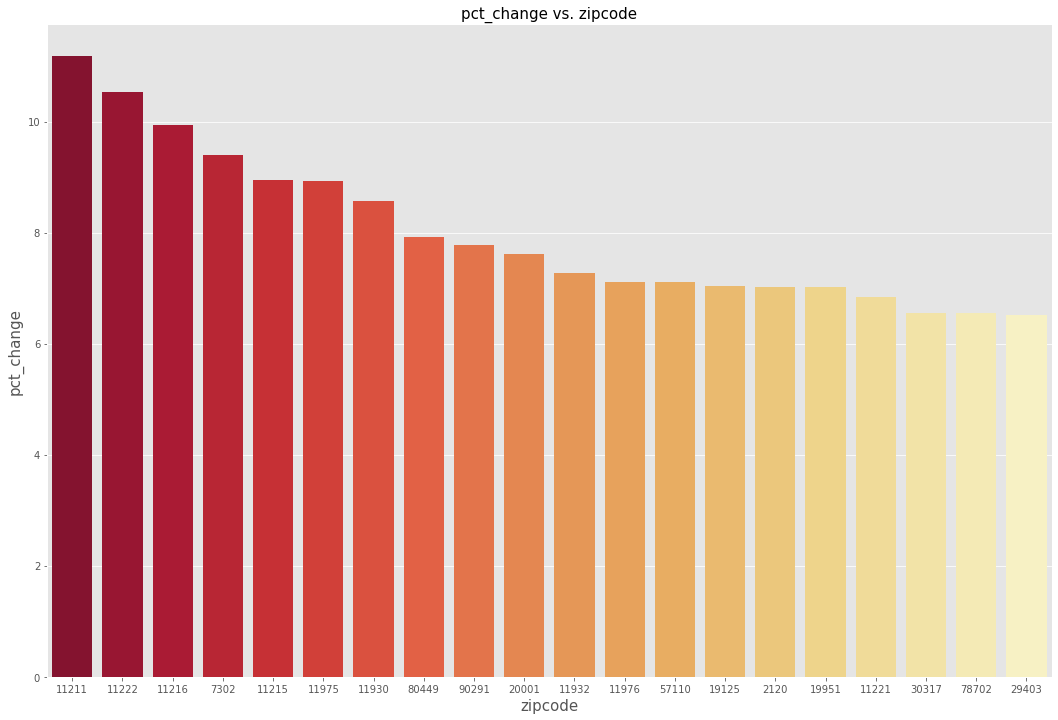

In [14]:
microplot(df, 'zipcode', 'pct_change')

In [15]:
def macroplot(data, group, y, limit=None ,**kwargs):
    '''
    group is the groupby, y is the what aggregate by so price, size
    data : dataframe
    group : groupby column
    y : y column or target
    limit : limit for x output
    '''
    states_df = data.groupby(by= group)[y].mean()
    df_sorted = states_df.sort_values(ascending=False)[:limit]
    x_order = df_sorted.index.tolist()
        
    fig, ax = plt.subplots(figsize=(18,12))
    ax = sns.barplot(x=df_sorted.index, y= df_sorted.values, palette= 'YlOrRd_r', order=x_order, **kwargs)
    ax.set_title(f'{y} vs. {group}', fontsize=15)
    ax.set_xlabel(group, fontsize=15)
    ax.set_ylabel(y, fontsize=15)

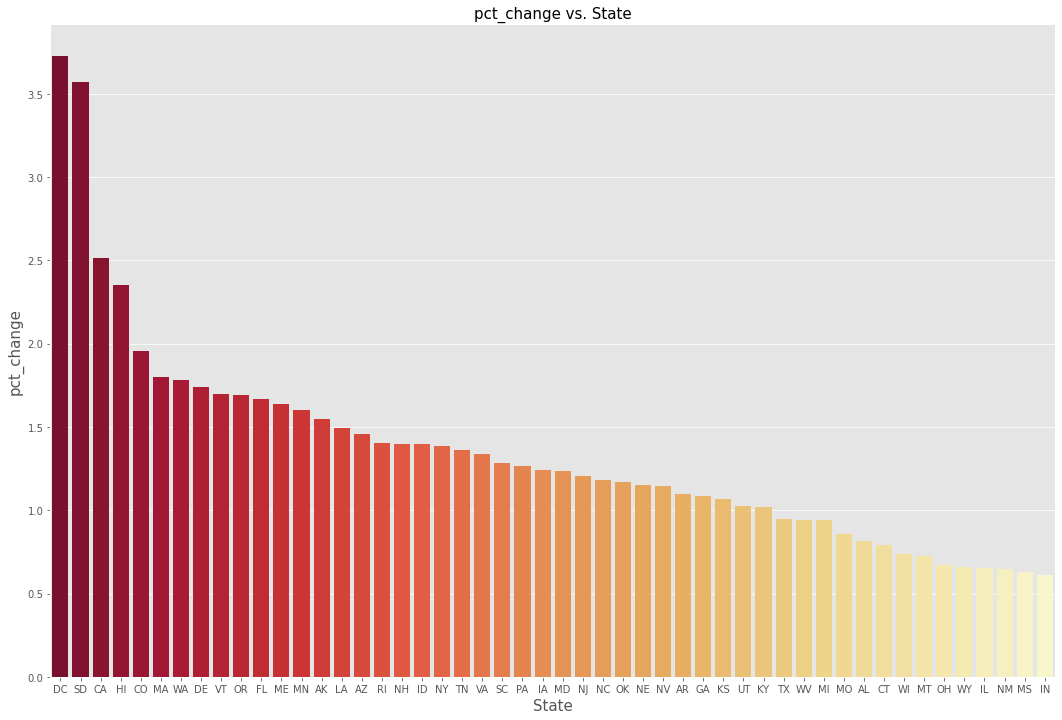

In [16]:
macroplot(df, 'State', 'pct_change')

In [17]:
(10 /4 ) - 1

1.5

In [18]:
((10 - 4) / 4)

1.5

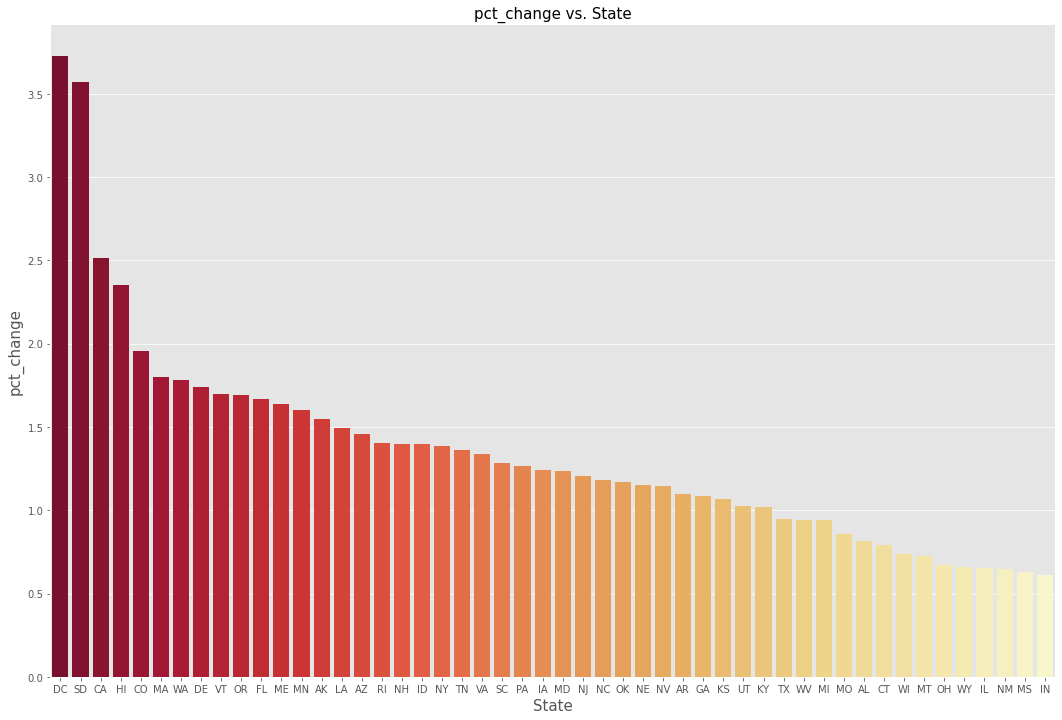

In [19]:
macroplot(final_df, 'State', 'pct_change')

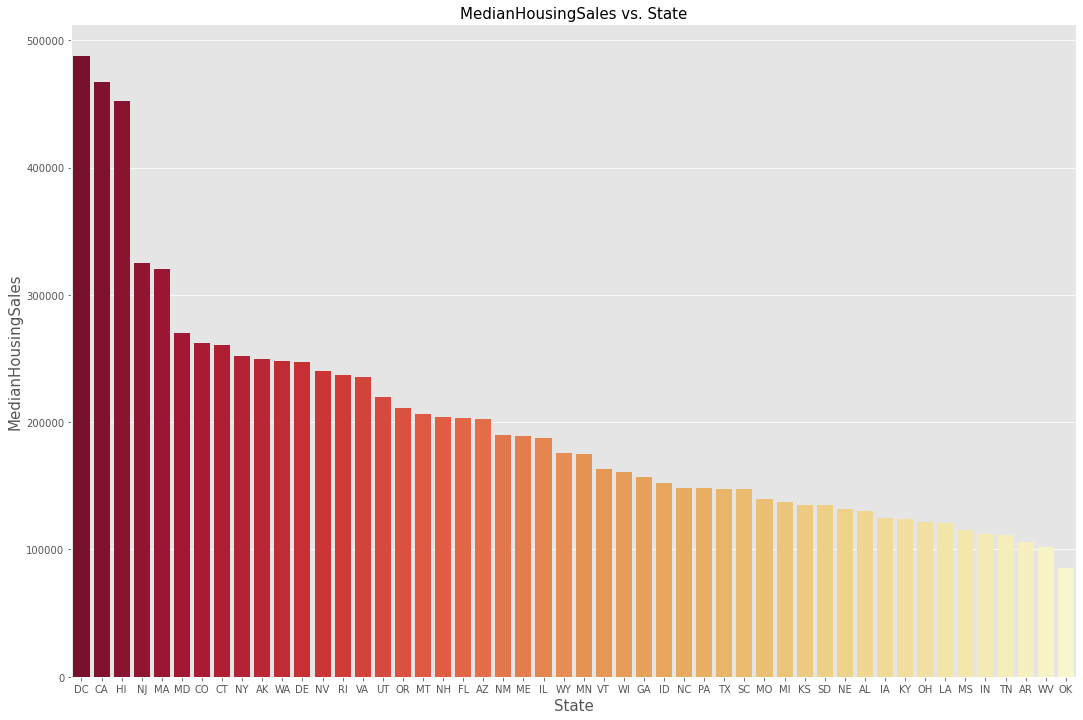

In [20]:
macroplot(final_df, 'State', 'MedianHousingSales')

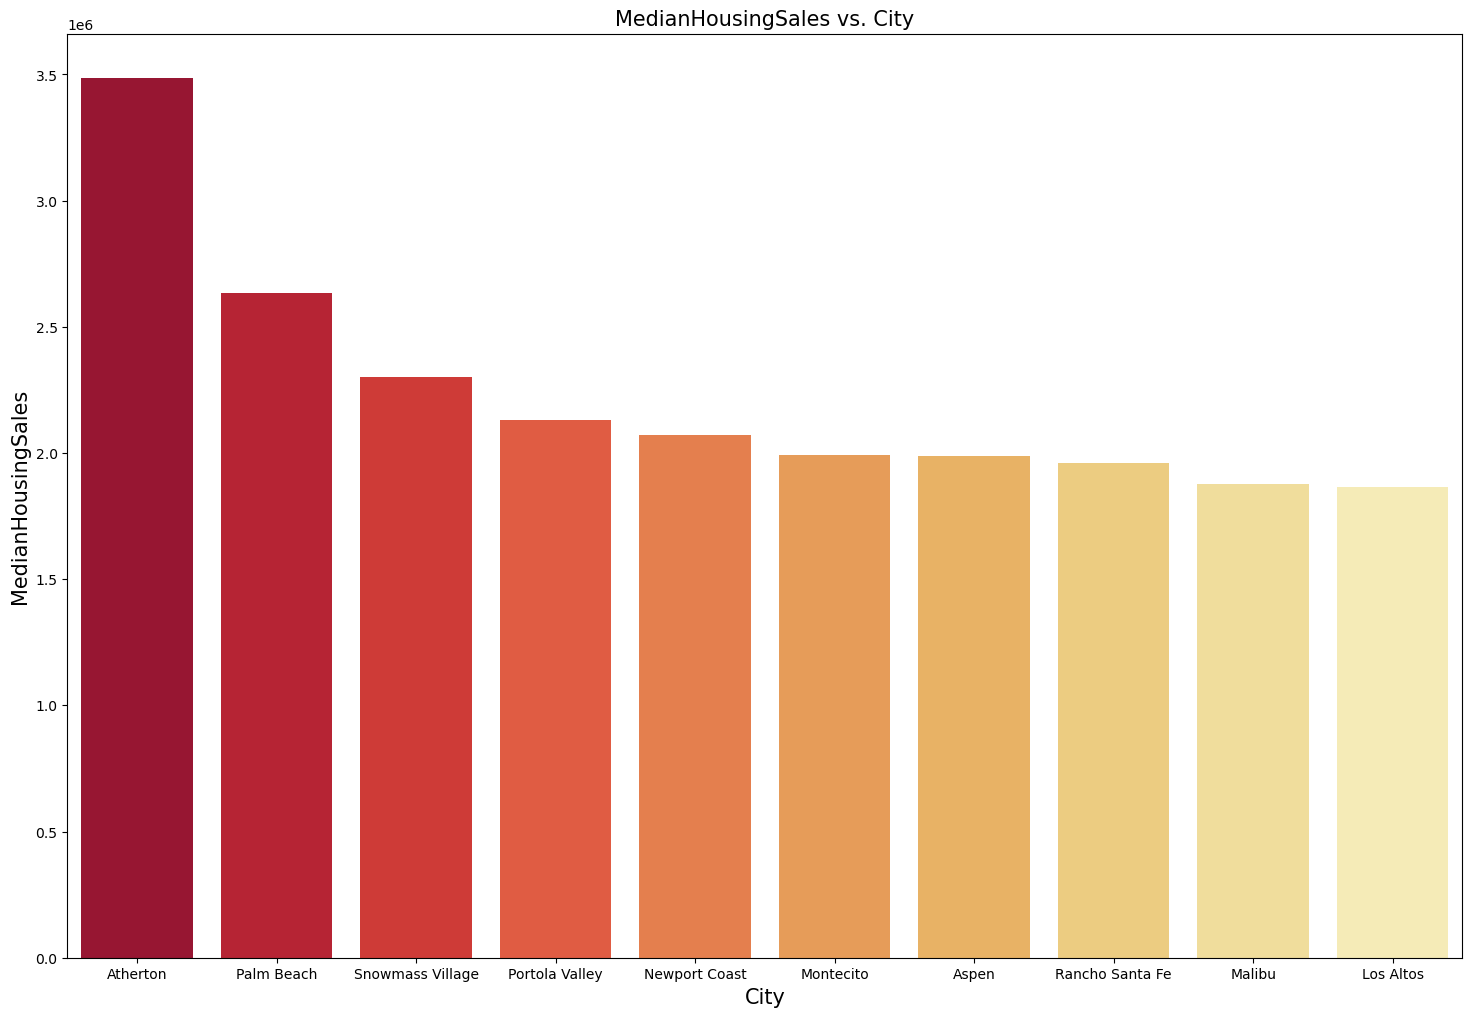

In [23]:
macroplot(final_df, 'City', 'MedianHousingSales', limit=10)

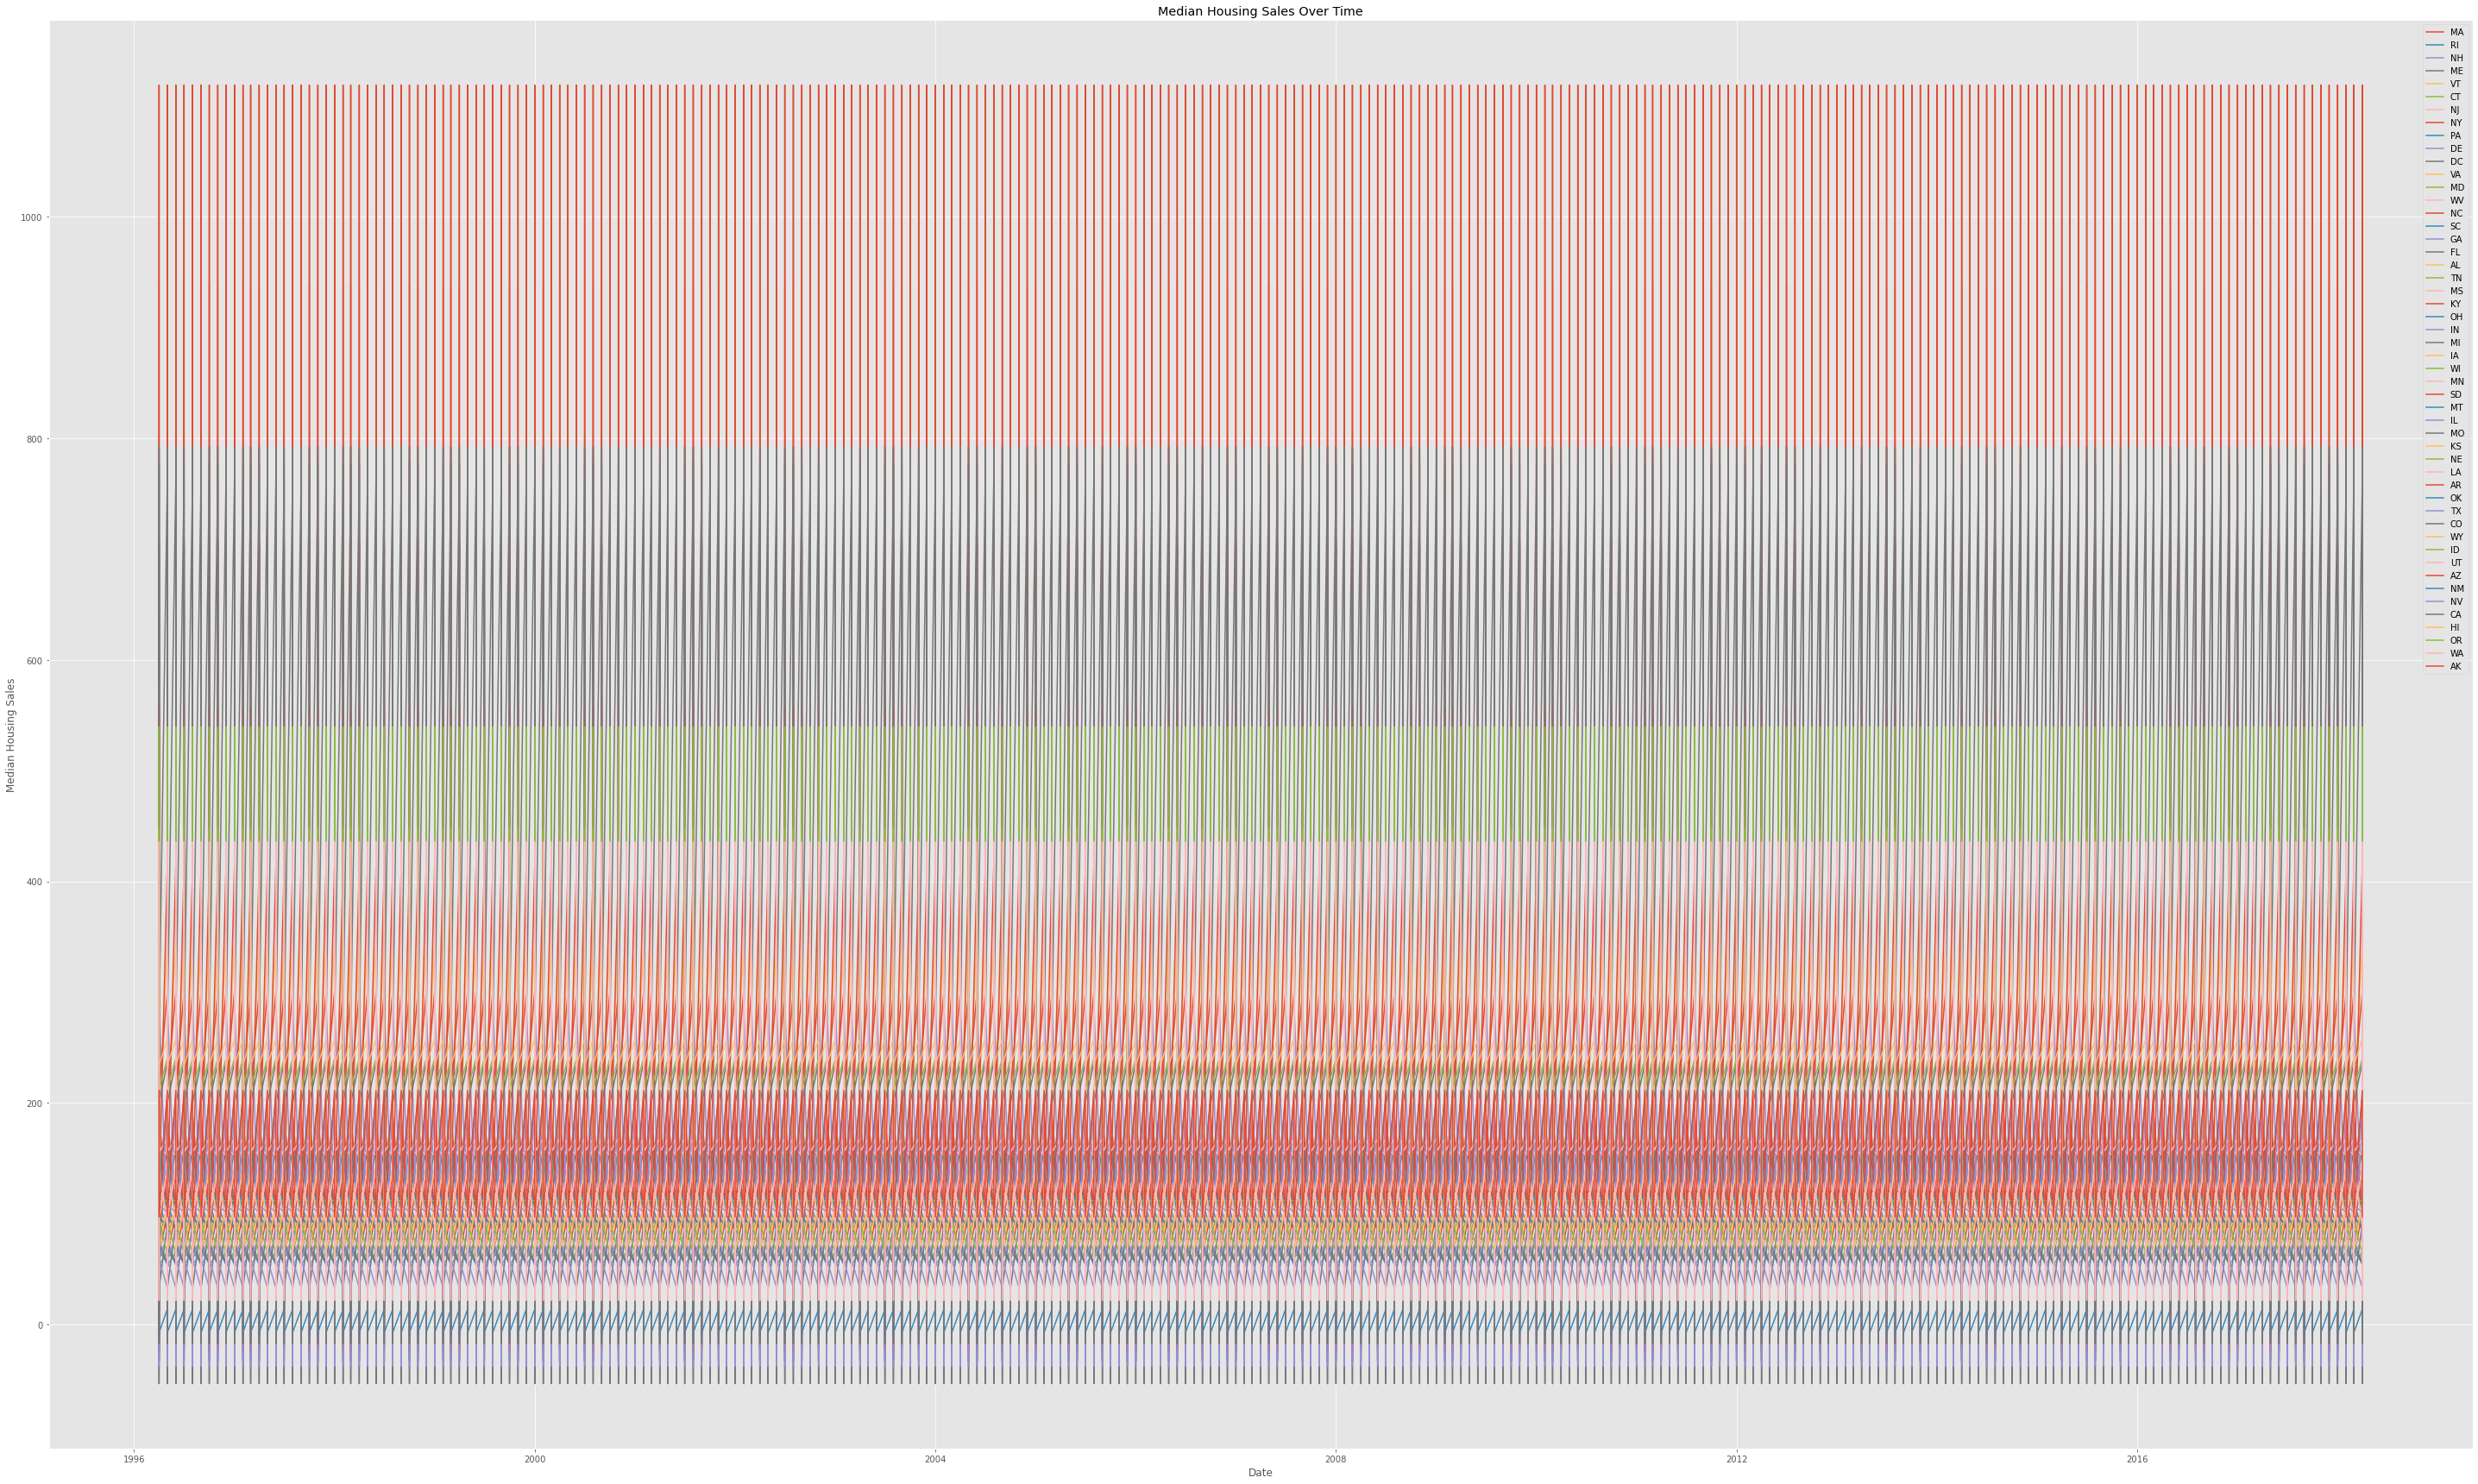

In [223]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24))

# Plotting
for region in final_df['State'].unique():
    data = final_df[final_df['State'] == region]
    plt.plot(data['Date'], data['pct_change'], label=region)

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time')
plt.legend()
plt.tight_layout()  # Ensures proper spacing of the plot elements
plt.show()

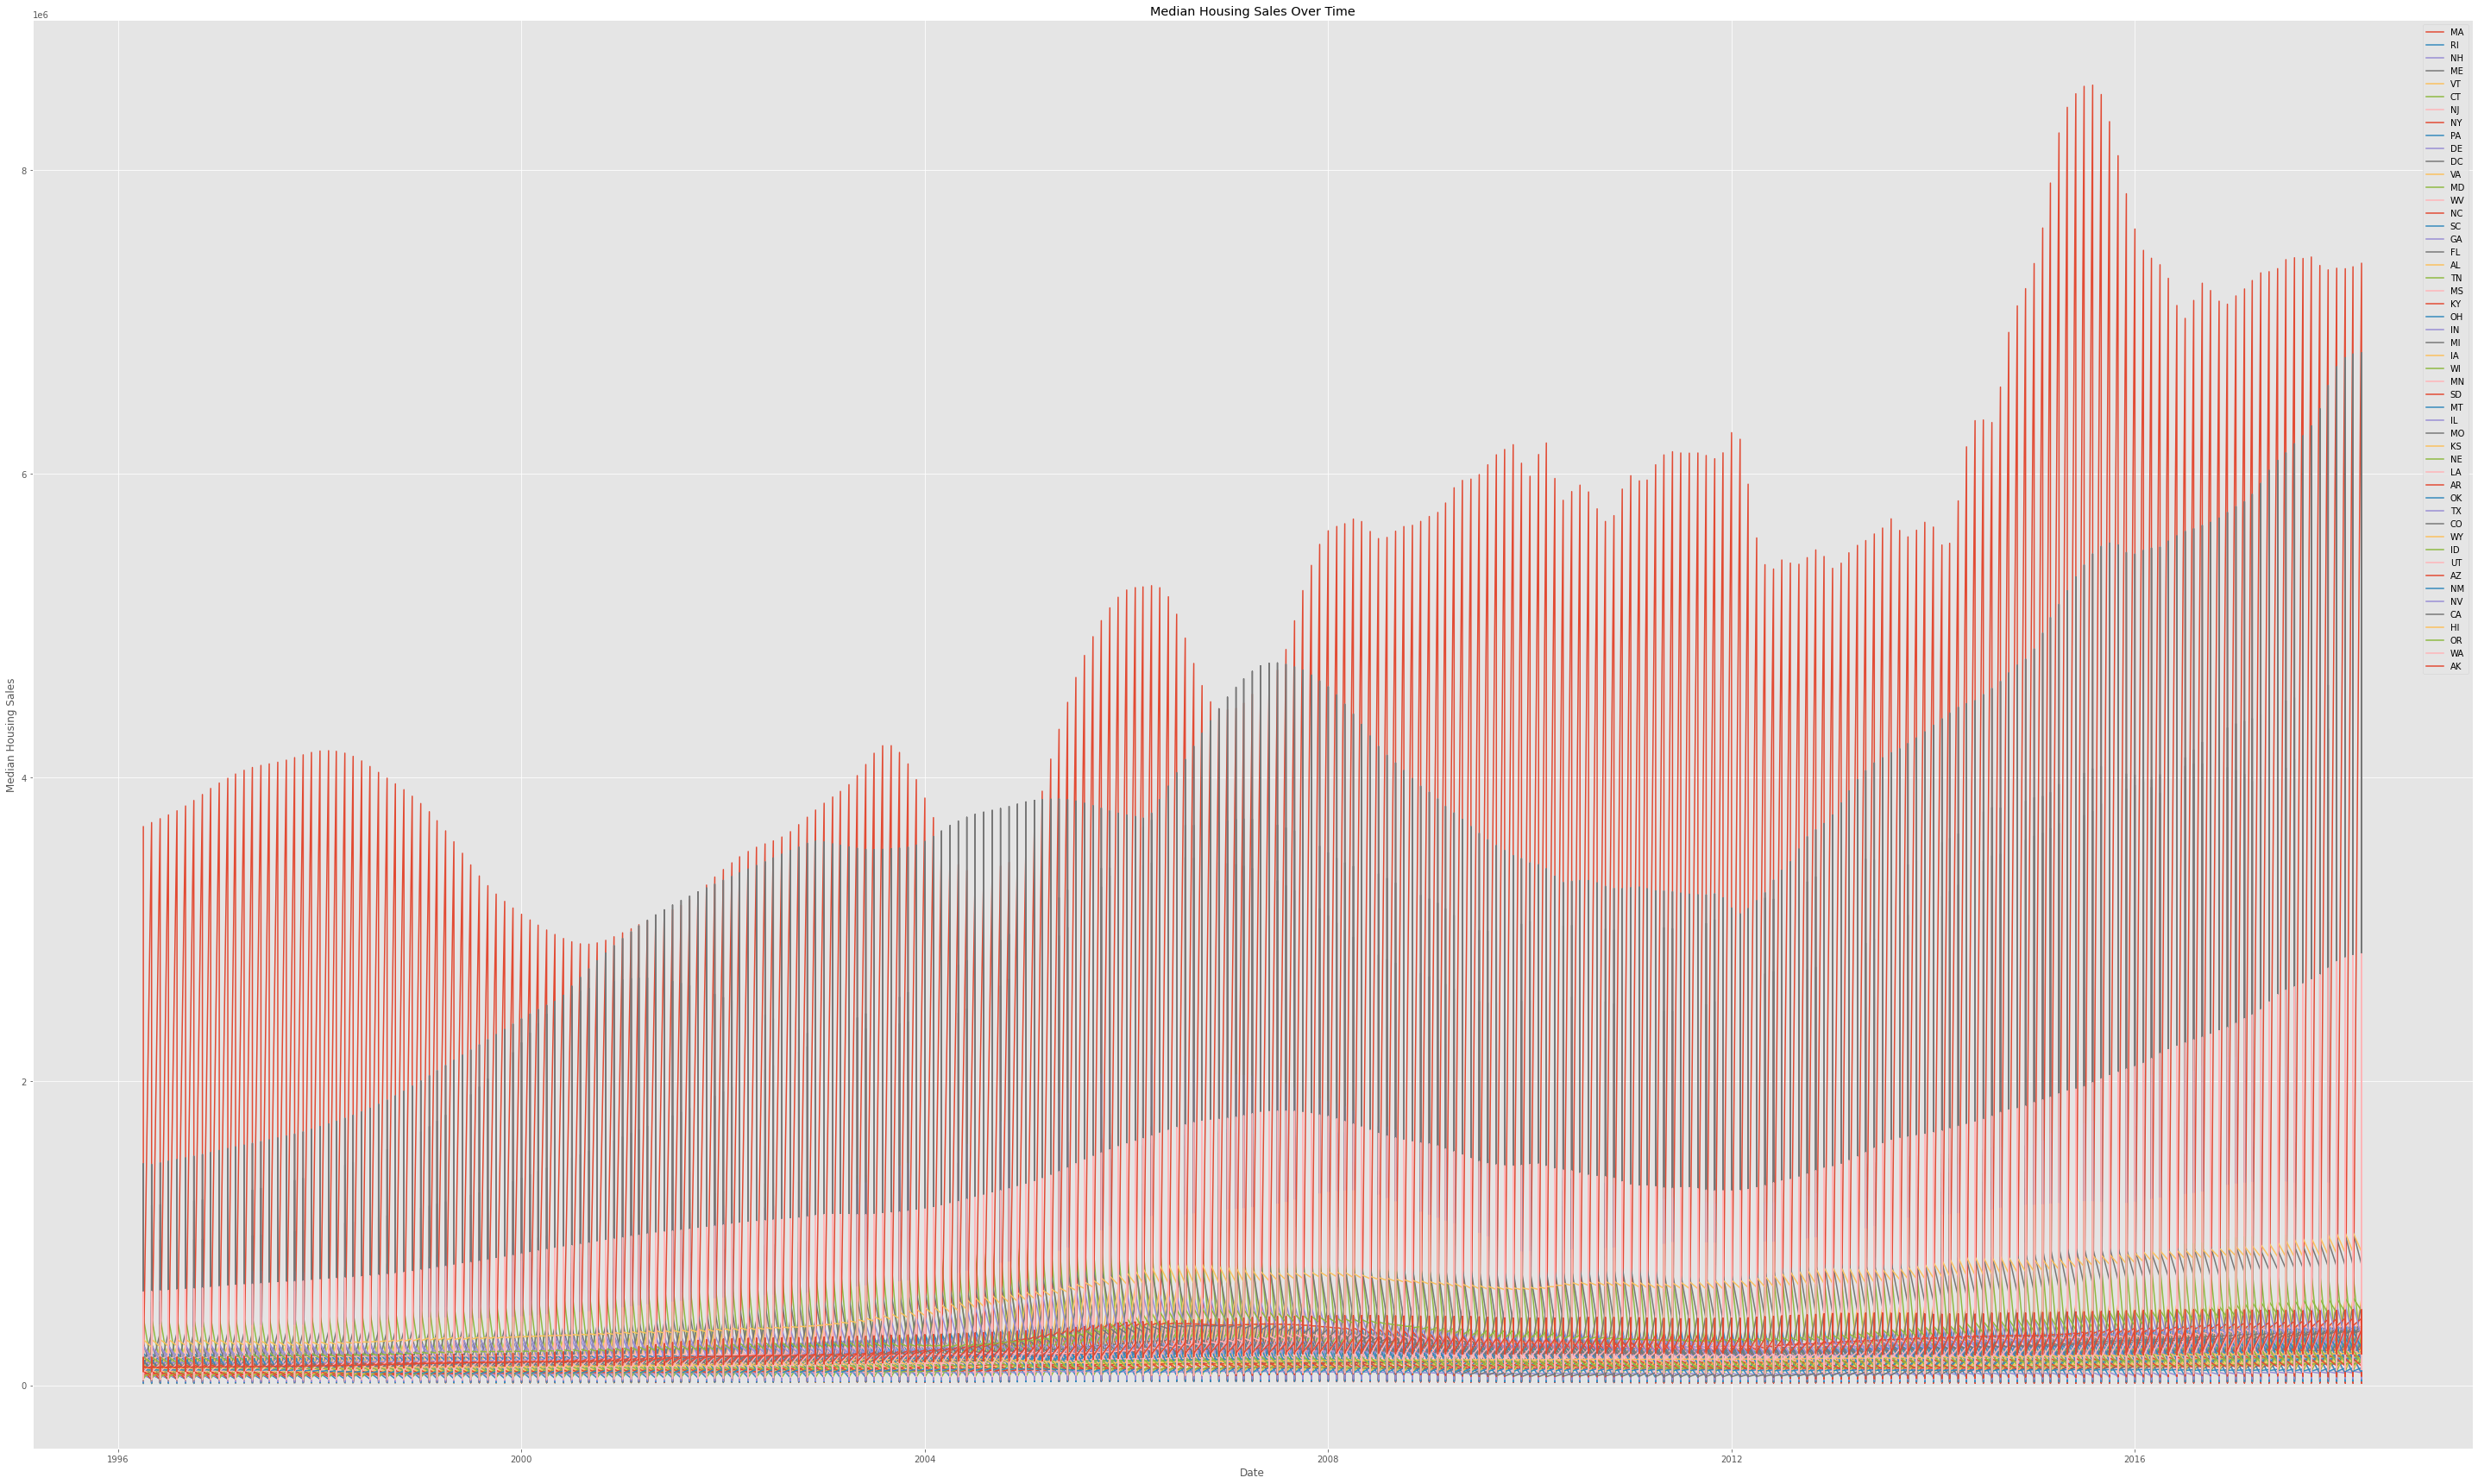

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24))

# Plotting
for region in final_df['State'].unique():
    data = final_df[final_df['State'] == region]
    plt.plot(data['Date'], data['MedianHousingSales'], label=region)

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time')
plt.legend()
plt.tight_layout()  # Ensures proper spacing of the plot elements
plt.savefig('housesales.png', dpi=200, bbox_inches='tight')



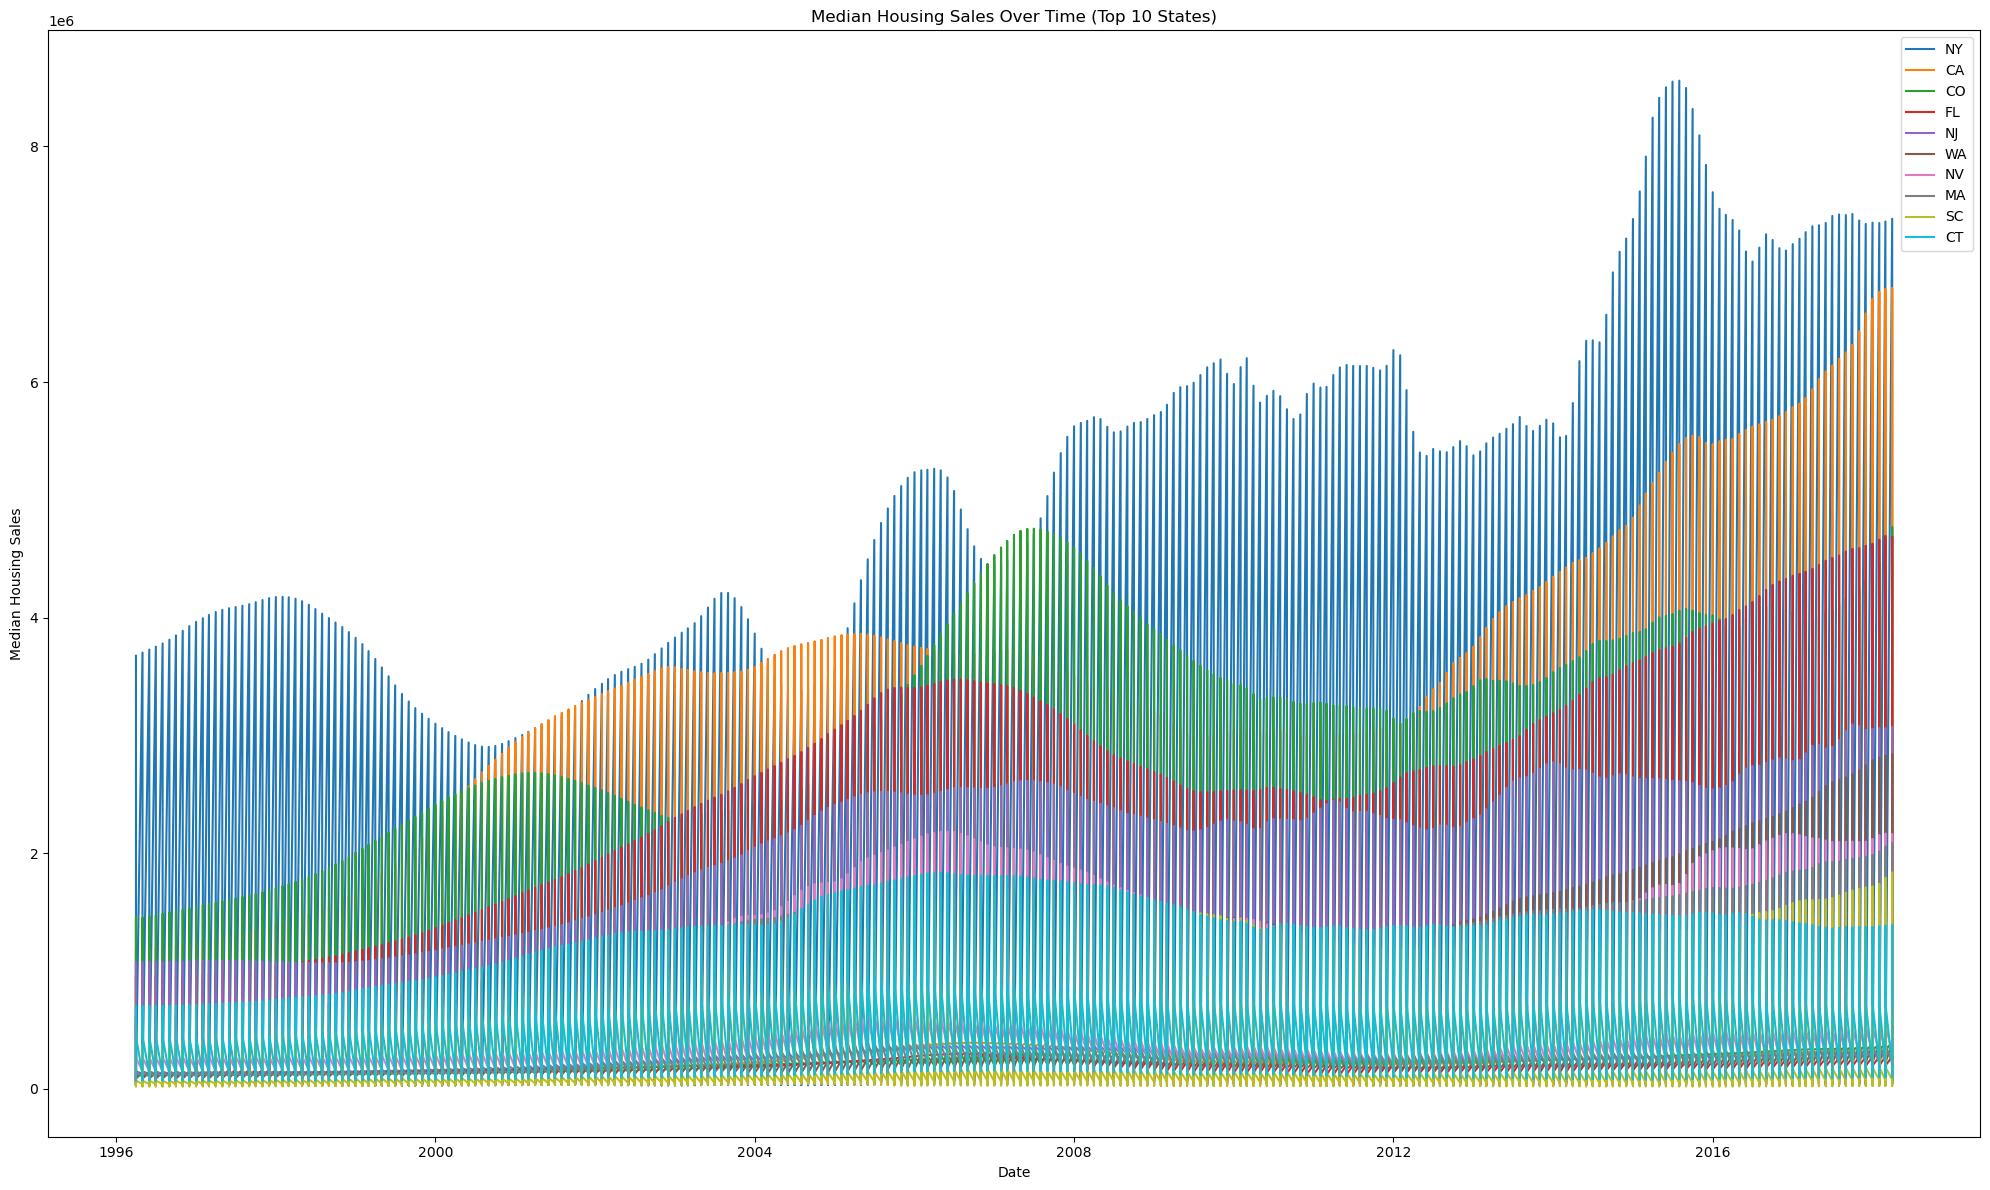

In [24]:
import matplotlib.pyplot as plt

# Sort the final_df dataframe by median housing sales in descending order
sorted_df = final_df.sort_values(by='MedianHousingSales', ascending=False)

# Get the top 10 states by median housing sales
top_10_states = sorted_df['State'].unique()[:10]

# Plotting
plt.figure(figsize=(20, 12))
for region in top_10_states:
    data = final_df[final_df['State'] == region]
    plt.plot(data['Date'], data['MedianHousingSales'], label=region)

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time (Top 10 States)')
plt.legend()
plt.tight_layout()  
# plt.savefig('housesales.png', dpi=200, bbox_inches='tight')


In [340]:
from PIL import Image
# img = Image.open('housesales.png')
img = Image.open('Median_house_DC.png')

img.show()


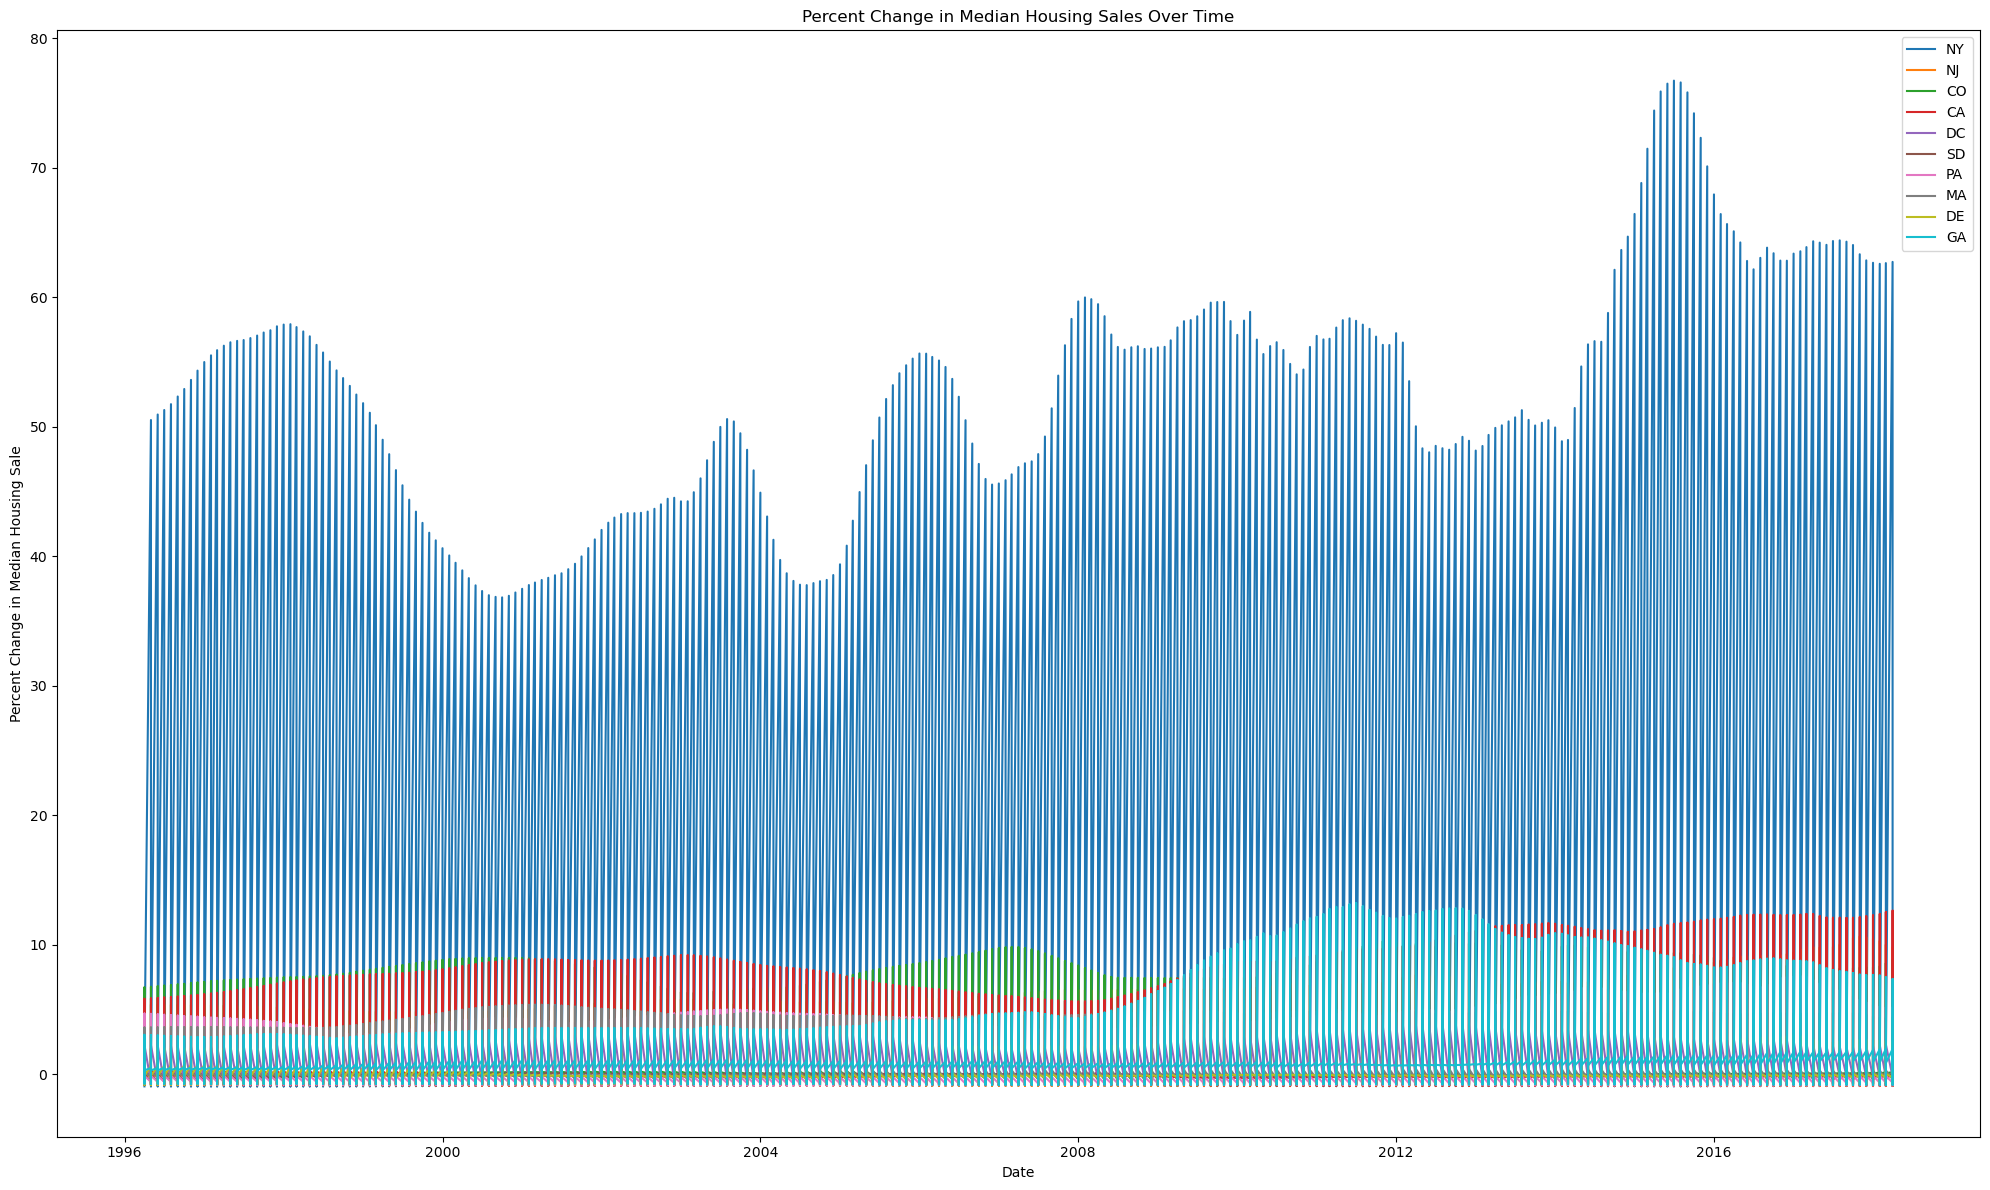

In [26]:
import matplotlib.pyplot as plt

# Calculate the percent change in median housing sales for each year
final_df['PercentChange'] = final_df.groupby('State')['MedianHousingSales'].pct_change()

# Sort the final_df dataframe by median housing sales in descending order
sorted_df = final_df.sort_values(by='pct_change', ascending=False)

# Get the top 10 states by median housing sales
top_10_states = sorted_df['State'].unique()[:10]

# Plotting
plt.figure(figsize=(20, 12))
for region in top_10_states:
    data = final_df[final_df['State'] == region]
    plt.plot(data['Date'], data['PercentChange'], label=region)

plt.xlabel('Date')
plt.ylabel('Percent Change in Median Housing Sale')
plt.title('Percent Change in Median Housing Sales Over Time')
plt.legend()
plt.tight_layout()  
# plt.savefig('percent_change2.png', dpi=200, bbox_inches='tight') 


In [294]:
top_10_states = sorted_df['State'].unique()[:10]
top_10_states

array(['NY', 'NJ', 'CO', 'CA', 'DC', 'SD', 'PA', 'MA', 'DE', 'GA'],
      dtype=object)

In [44]:
data[data['Date'] > '2017']

Date      RegionID       zipcode     SizeRank  pct_change  \
250 2017-02-01  62687.913462  12587.987179  8586.597222    1.384285   
251 2017-03-01  62687.913462  12587.987179  8586.597222    1.384285   
252 2017-04-01  62687.913462  12587.987179  8586.597222    1.384285   
253 2017-05-01  62687.913462  12587.987179  8586.597222    1.384285   
254 2017-06-01  62687.913462  12587.987179  8586.597222    1.384285   
255 2017-07-01  62687.913462  12587.987179  8586.597222    1.384285   
256 2017-08-01  62687.913462  12587.987179  8586.597222    1.384285   
257 2017-09-01  62687.913462  12587.987179  8586.597222    1.384285   
258 2017-10-01  62687.913462  12587.987179  8586.597222    1.384285   
259 2017-11-01  62687.913462  12587.987179  8586.597222    1.384285   
260 2017-12-01  62687.913462  12587.987179  8586.597222    1.384285   
261 2018-01-01  62687.913462  12587.987179  8586.597222    1.384285   
262 2018-02-01  62687.913462  12587.987179  8586.597222    1.384285   
263 2018-03-01  62687.913462  12587.987179  8586.597222    1.384285   
264 2018-04-01  62687.913462  12587.987179  8586.597222    1.384285   

     MedianHousingSales  
250       324346.260684  
251       325578.205128  
252       327108.119658  
253       329135.042735  
254       331460.042735  
255       333945.192308  
256       335925.320513  
257       337628.205128  
258       339142.841880  
259       340411.645299  
260       341879.914530  
261       343502.136752  
262       345303.952991  
263       347868.696581  
264       350235.363248

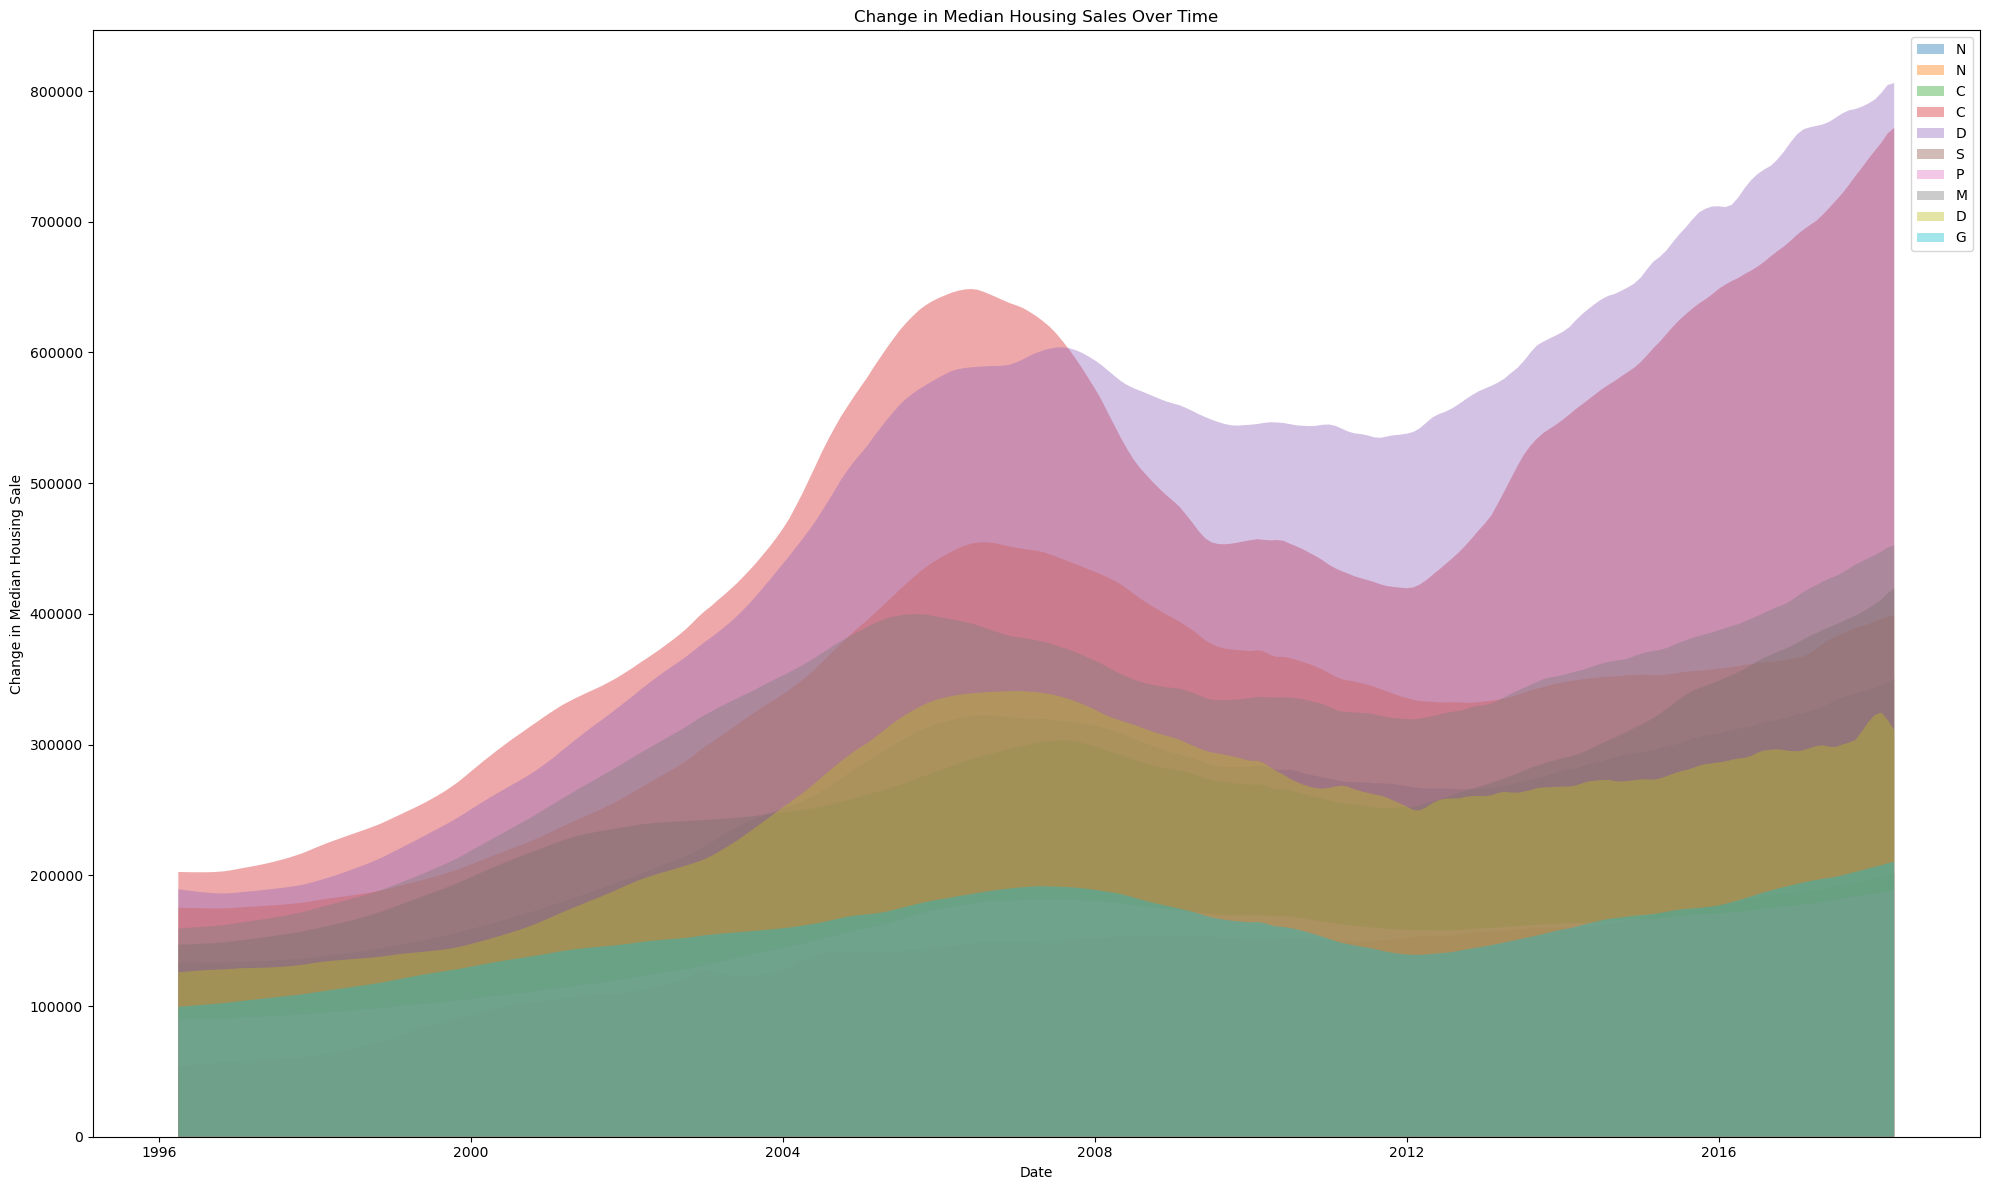

In [268]:
import matplotlib.pyplot as pl
import matplotlib.cm as cm

# Calculate the percent change in median housing sales for each year
# final_df['PercentChange'] = final_df.groupby('State')['MedianHousingSales'].pct_change()
# # final_df['PercentChange'] = final_df.groupby('Date').mean().reset_index()


# Sort the final_df dataframe by median housing sales in descending order
sorted_df = final_df.sort_values(by='pct_change', ascending=False)

# colors = cm.tab10(np.linspace(0, 1, 10))

# Set the new default color for the plot
# plt.style.use('dark_background')
plt.style.use('default')

# Get the top 10 states by median housing sales
# top_10_states = ['DC']
top_10_states = sorted_df['State'].unique()[:10]

# Plotting
plt.figure(figsize=(20, 12))
for region in top_10_states:
#     data = final_df[final_df['State'] == region]
    data = final_df[final_df['State'] == region].groupby('Date').mean().reset_index()
 
    plt.stackplot(data['Date'], data['MedianHousingSales'], alpha=0.4, labels=region)#, label=region)

plt.xlabel('Date')
plt.ylabel('Change in Median Housing Sale')
plt.title('Change in Median Housing Sales Over Time')
plt.legend()
plt.tight_layout()
# plt.savefig('plots/Median_house_DC.png', dpi=200, bbox_inches='tight')


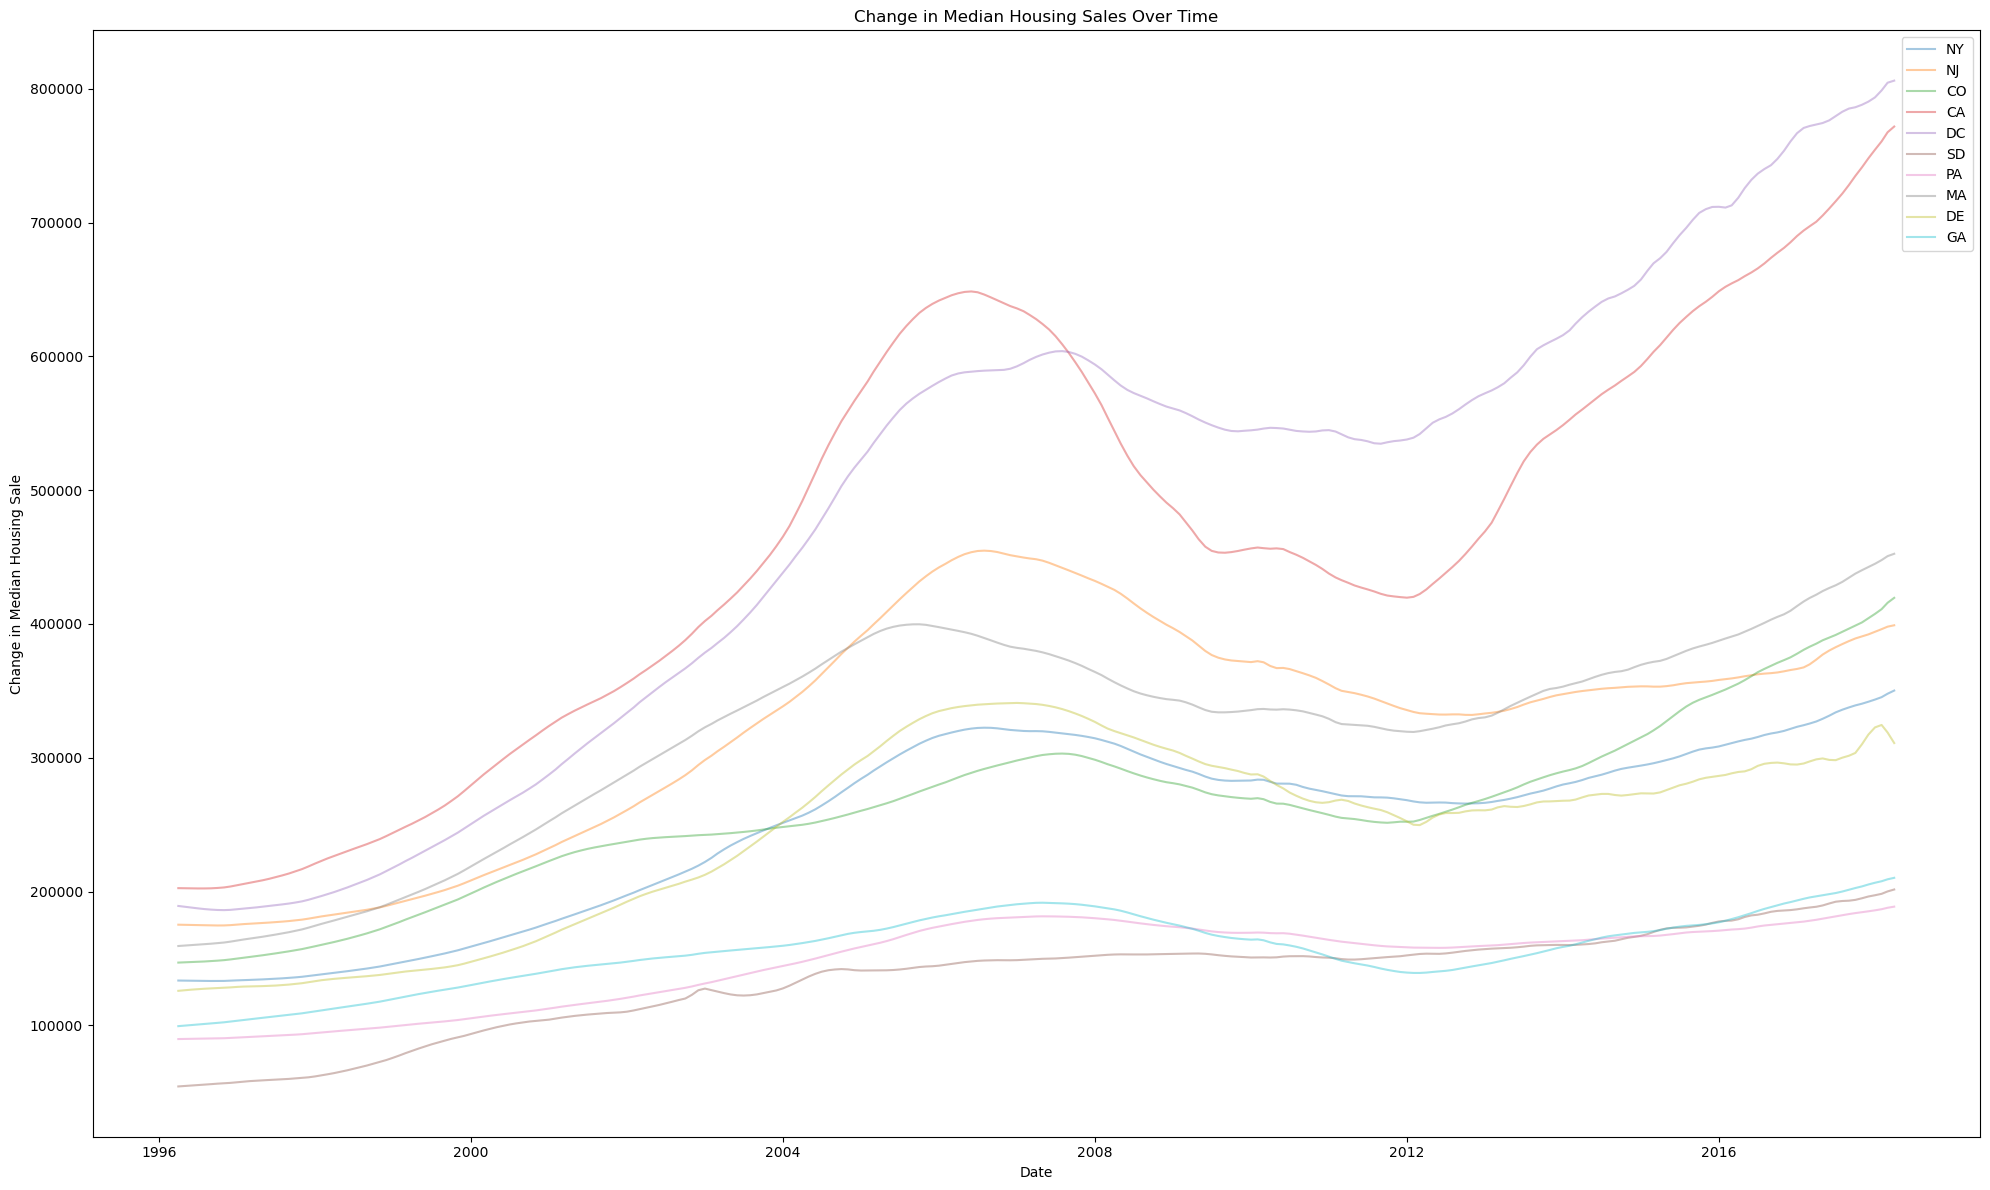

In [271]:
import matplotlib.pyplot as pl
import matplotlib.cm as cm

# Calculate the percent change in median housing sales for each year
# final_df['PercentChange'] = final_df.groupby('State')['MedianHousingSales'].mean().pct_change()


# Sort the final_df dataframe by median housing sales in descending order
sorted_df = final_df.sort_values(by='pct_change', ascending=False)

# colors = cm.tab10(np.linspace(0, 1, 10))

# Set the new default color for the plot
# plt.style.use('dark_background')
plt.style.use('default')

# Get the top 10 states by median housing sales
# top_10_states = ['DC']
top_10_states = sorted_df['State'].unique()[:10]

# Plotting
plt.figure(figsize=(20, 12))
for region in top_10_states:
#     data = final_df[final_df['State'] == region]
    data = final_df[final_df['State'] == region].groupby('Date').mean().reset_index()
 
    plt.plot(data['Date'], data['MedianHousingSales'], alpha=0.4, label=region)

plt.xlabel('Date')
plt.ylabel('Change in Median Housing Sale')
plt.title('Change in Median Housing Sales Over Time')
plt.legend()
plt.tight_layout()
# plt.savefig('Median_house_DC.png', dpi=200, bbox_inches='tight')

In [29]:
plt.style.use('default')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


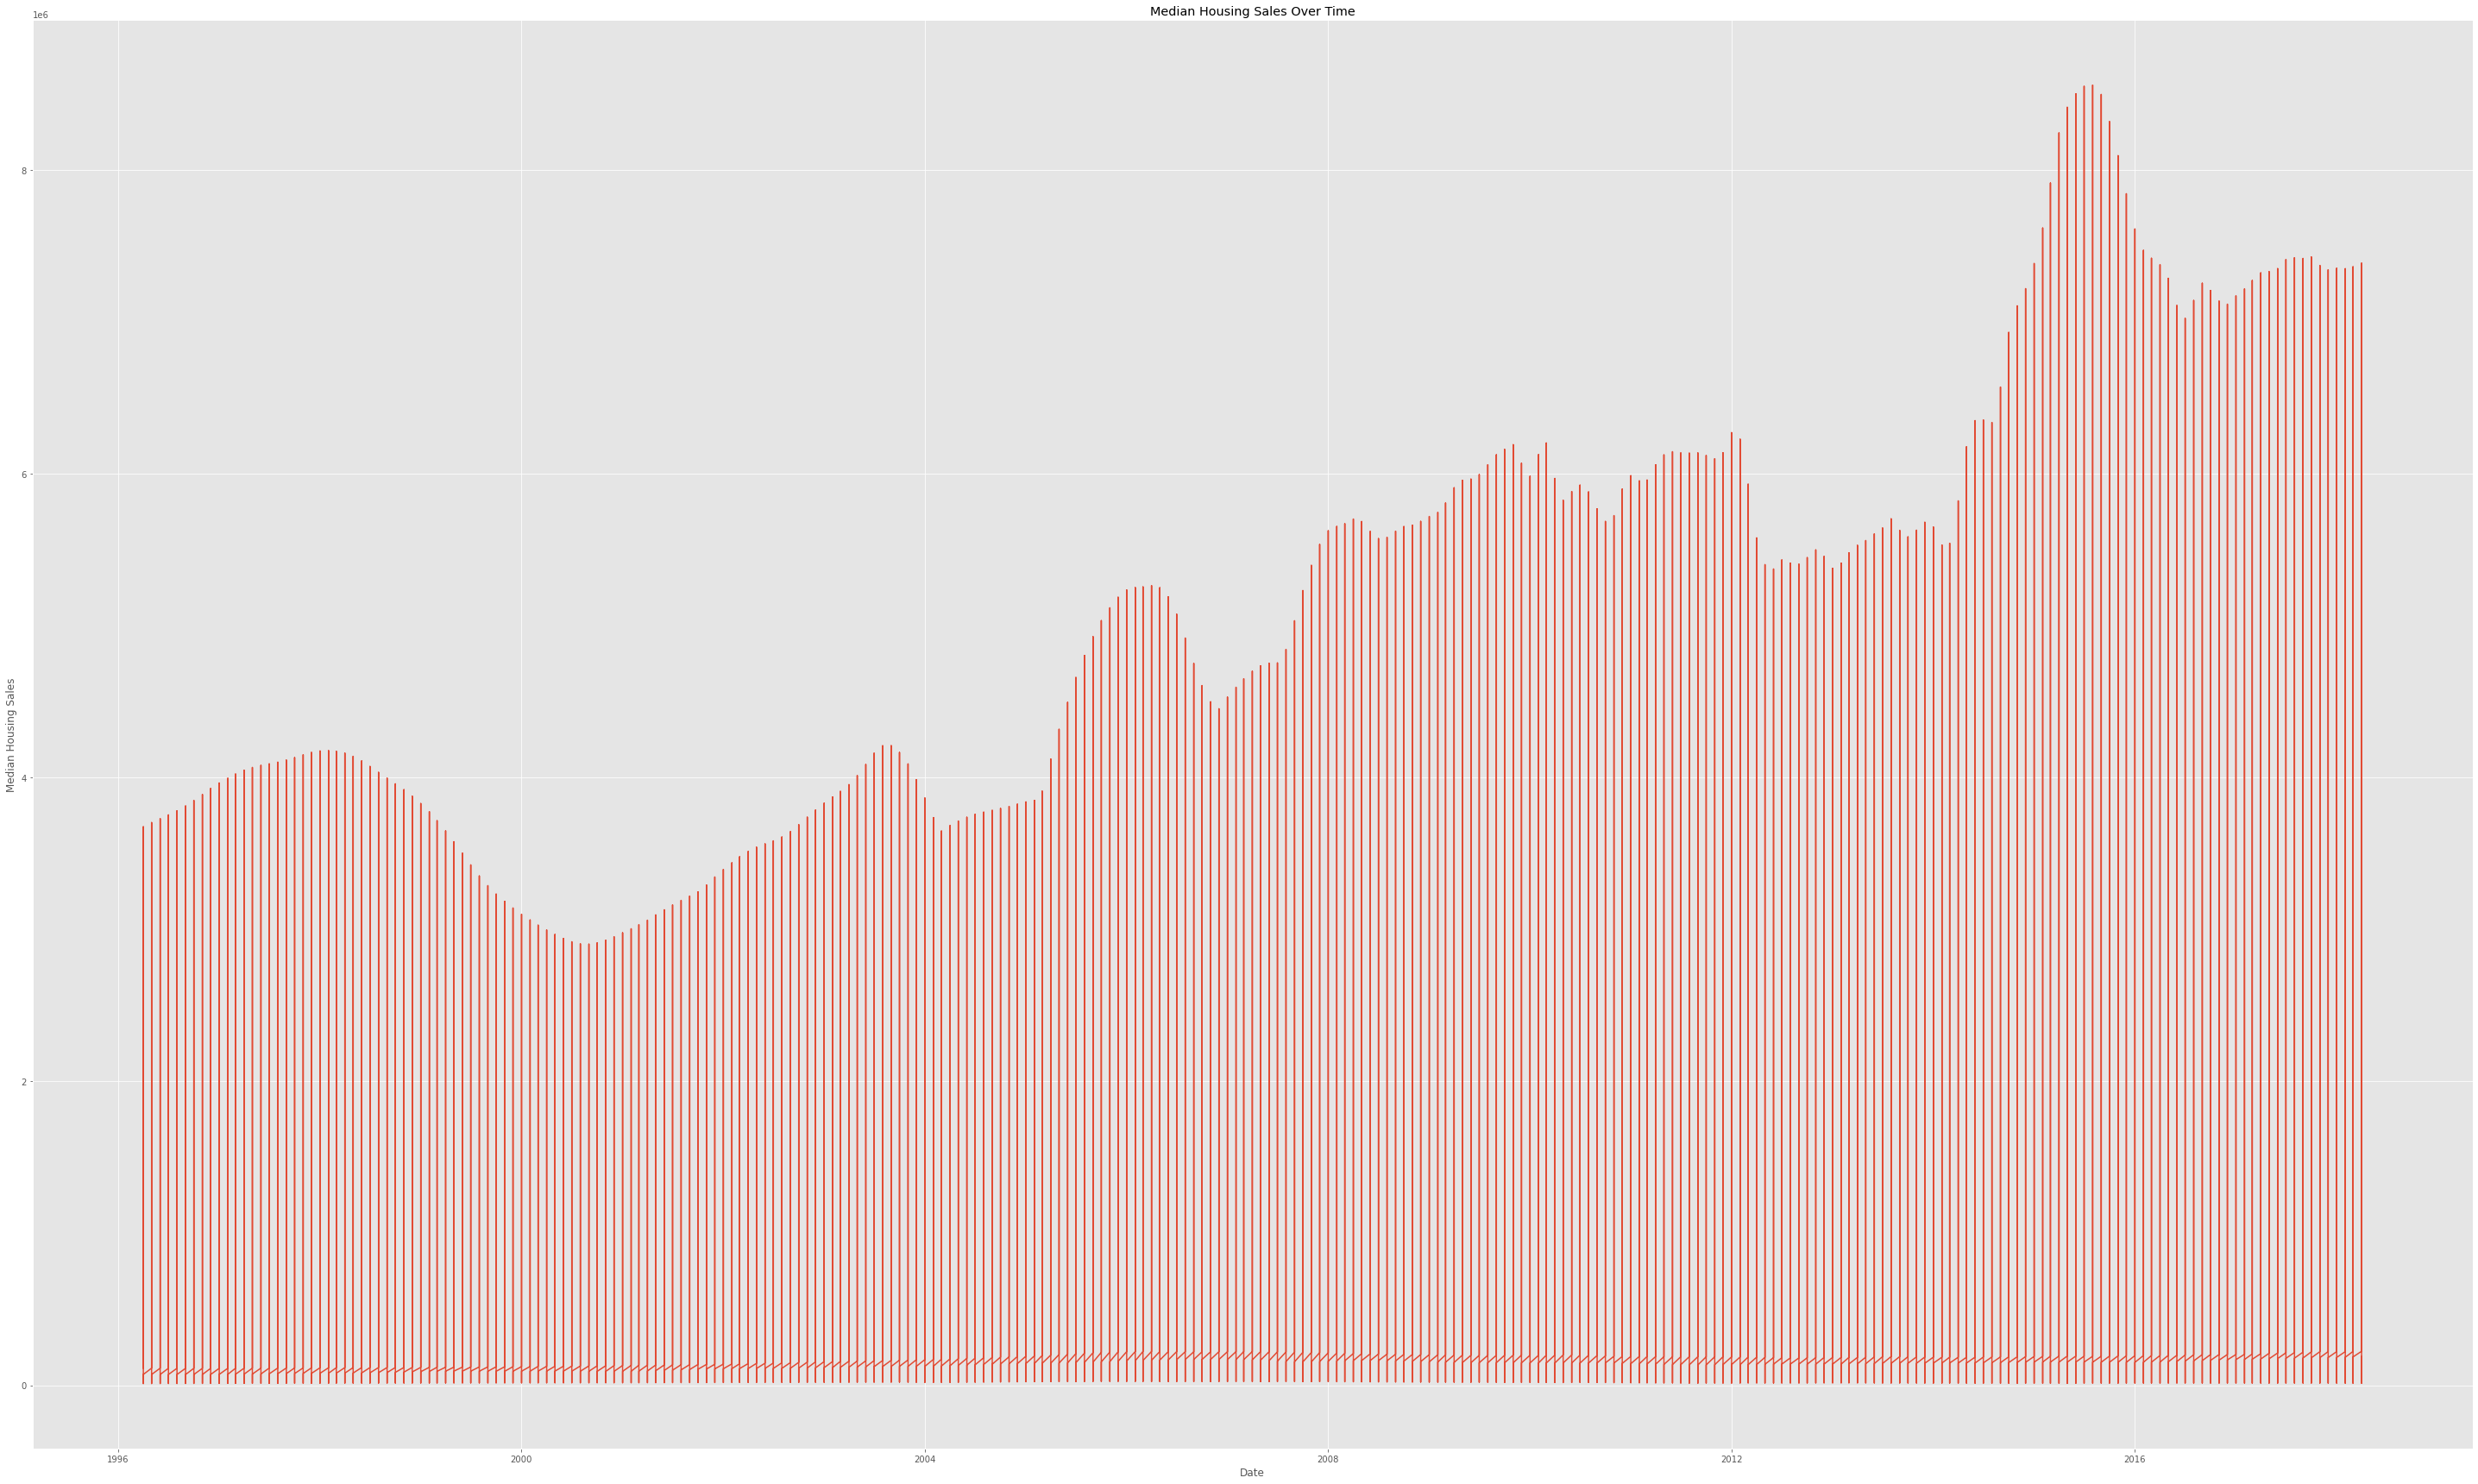

In [220]:
plt.figure(figsize=(40, 24))

# Plotting
plt.plot(final_df['Date'], final_df['MedianHousingSales'])

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time')
plt.tight_layout()  # Ensures proper spacing of the plot elements
plt.show()

In [351]:
# # Plotting
# plt.figure(figsize=(30, 18))
# plt.boxplot([final_df[final_df['Date'] == date]['MedianHousingSales'] for date in final_df['Date'].unique()],
#             labels=final_df['Date'].unique())

# plt.xlabel('Date')
# plt.ylabel('Median Housing Sales')
# plt.title('Distribution of Median Housing Sales for Each Month')
# plt.xticks(rotation=45)
# plt.show()


In [352]:
# import seaborn as sns

# # Pivot the data to create a pivot table with Date as index, RegionName as columns, and MedianHousingSales as values
# pivot_df = final_df.pivot(index='Date', columns='RegionName', values='MedianHousingSales')

# # Plotting
# plt.figure(figsize=(30, 16))
# sns.heatmap(pivot_df, cmap='YlGnBu')

# plt.xlabel('Region')
# plt.ylabel('Date')
# plt.title('Median Housing Sales Heatmap')
# plt.show()


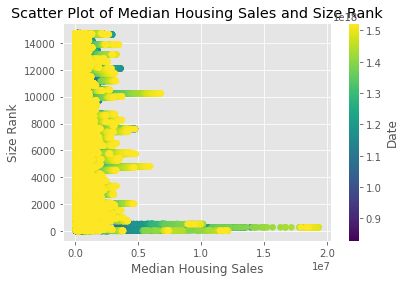

In [16]:
# Plotting
plt.scatter(final_df['MedianHousingSales'], final_df['SizeRank'], c=final_df['Date'], cmap='viridis')

plt.xlabel('Median Housing Sales')
plt.ylabel('Size Rank')
plt.title('Scatter Plot of Median Housing Sales and Size Rank')
plt.colorbar(label='Date')
plt.show()


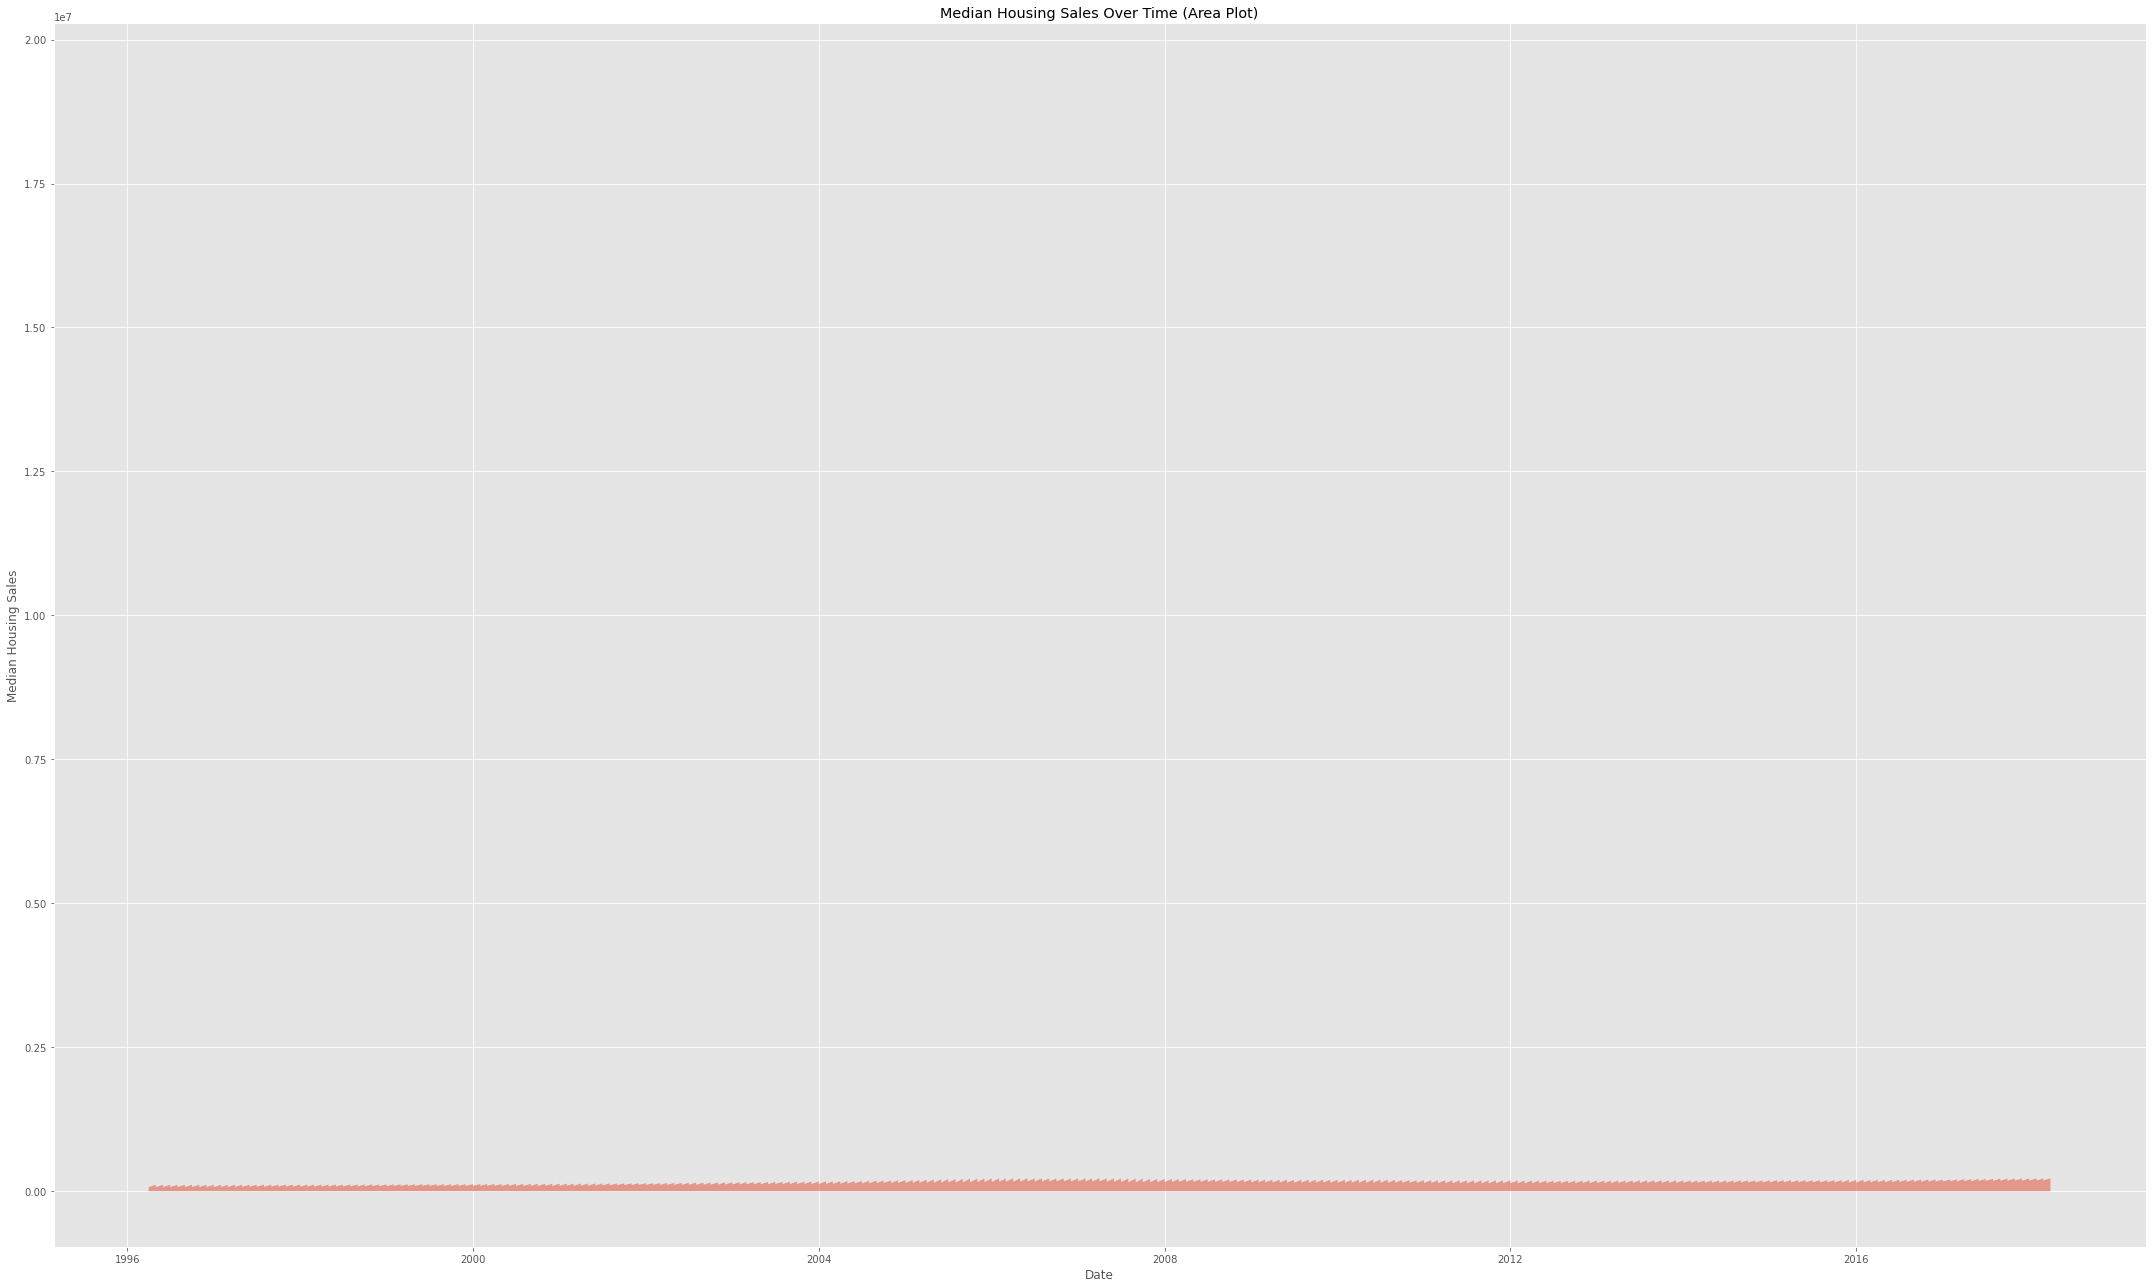

In [27]:
plt.figure(figsize=(30, 18))
plt.fill_between(final_df['Date'], final_df['MedianHousingSales'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time (Area Plot)')
plt.tight_layout()
plt.show()

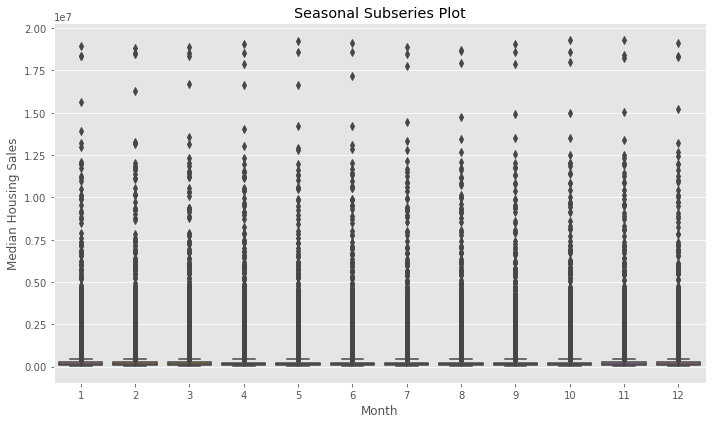

In [28]:

final_df['Month'] = final_df['Date'].dt.month

plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='MedianHousingSales', data=final_df)
plt.xlabel('Month')
plt.ylabel('Median Housing Sales')
plt.title('Seasonal Subseries Plot')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(final_df['Date'], final_df['MedianHousingSales'])
plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time (Bar Plot)')
plt.tight_layout()
plt.show()

# Creating Series

In [730]:
selected_states = ['DC']#, 'NY', 'CO']
dc_df = final_df[final_df['State'].isin(selected_states)]
# creating percent change
dc_df['PercentChange'] = dc_df.groupby('zipcode')['MedianHousingSales'].pct_change() *100

limited_df = dc_df.groupby('Date')['MedianHousingSales'].mean()
limited_df = limited_df.resample('MS').mean()
# limited_df = limited_df.asfreq('MS')
# limited_df = limited_df.fillna(filler)

# Creating various transformations
diff_df = limited_df.diff().dropna()
diff_df2 = limited_df.diff().diff().dropna()
diff_df3 = limited_df.diff().diff().diff().dropna()

sqrt_df = np.sqrt(limited_df)
log_df = np.log(limited_df)
log_dff = log_df.diff().diff().dropna()
# pdq_fitting(limited_df['MedianHousingSales'], summary=True)

In [602]:
limited_df

Date
1996-04-01    189216.666667
1996-05-01    188611.111111
1996-06-01    188011.111111
1996-07-01    187438.888889
1996-08-01    186900.000000
1996-09-01    186494.444444
1996-10-01    186222.222222
1996-11-01    186116.666667
1996-12-01    186305.555556
1997-01-01    186750.000000
1997-02-01    187261.111111
1997-03-01    187677.777778
1997-04-01    188144.444444
1997-05-01    188683.333333
1997-06-01    189227.777778
1997-07-01    189800.000000
1997-08-01    190394.444444
1997-09-01    191033.333333
1997-10-01    191777.777778
1997-11-01    192655.555556
1997-12-01    193827.777778
1998-01-01    195233.333333
1998-02-01    196688.888889
1998-03-01    198083.333333
1998-04-01    199622.222222
1998-05-01    201266.666667
1998-06-01    203027.777778
1998-07-01    204850.000000
1998-08-01    206722.222222
1998-09-01    208655.555556
1998-10-01    210700.000000
1998-11-01    212861.111111
1998-12-01    215261.111111
1999-01-01    217816.666667
1999-02-01    220333.333333
1999-03-01    2

# Stationarity

In [455]:
def stationary(*args):
    pv = []
    for data in args:
        if adfuller(data)[1]< .05:
            print(f'{adfuller(data)[1]< .05} With a pvlaue of {adfuller(data)[1]}\n')
            pv.append(adfuller(data)[1])
        else:
            print(f'{False}\n')
    if pv:
        print(min(pv))
stationary(limited_df, diff_df, diff_df2, sqrt_df, log_df, log_dff, diff_df3)

False

False

True With a pvlaue of 0.0018426103473226276

False

False

True With a pvlaue of 0.015916794971073026

True With a pvlaue of 6.93958140822798e-13

6.93958140822798e-13


<AxesSubplot:xlabel='Date'>

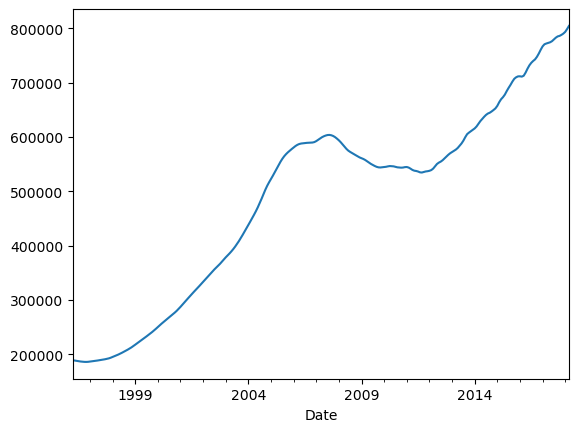

In [351]:
limited_df.plot()

<AxesSubplot:xlabel='Date'>

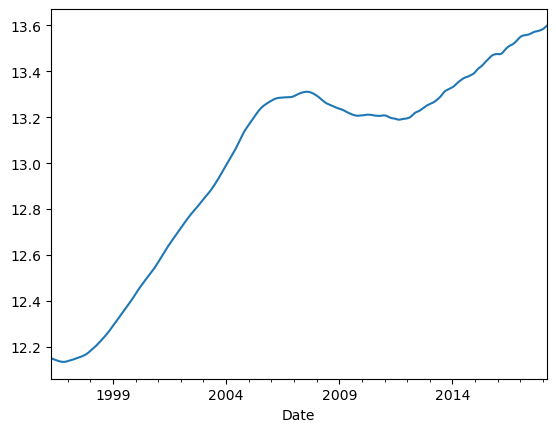

In [352]:
log_df.plot()

<AxesSubplot:xlabel='Date'>

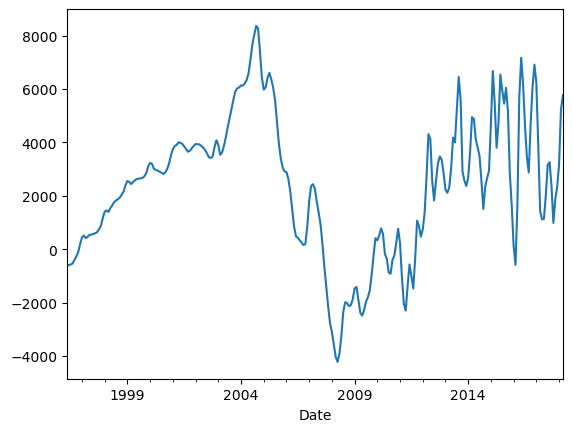

In [353]:
diff_df.plot()

<AxesSubplot:xlabel='Date'>

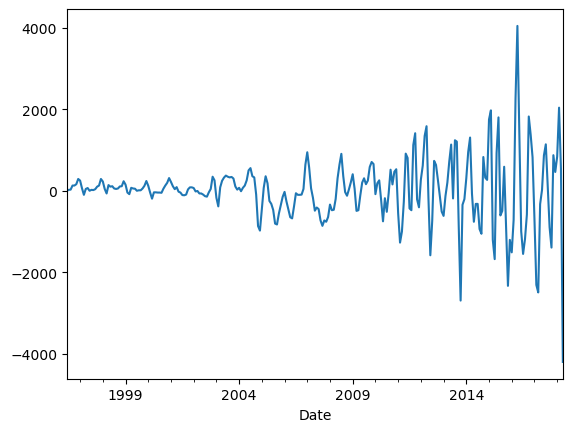

In [456]:
diff_df2.plot()

<AxesSubplot:xlabel='Date'>

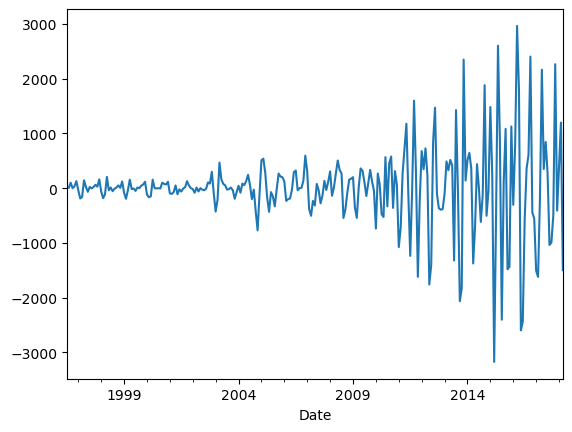

In [355]:
diff_df3.plot()

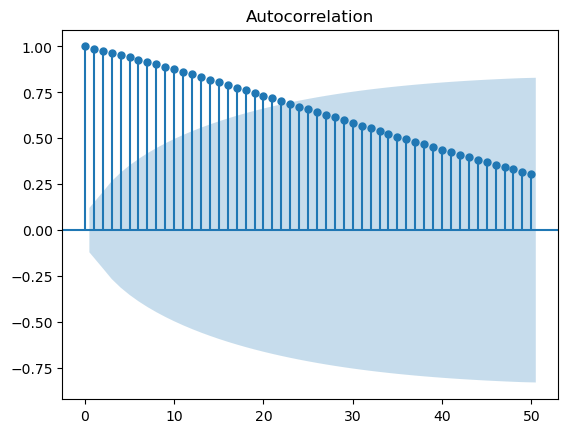

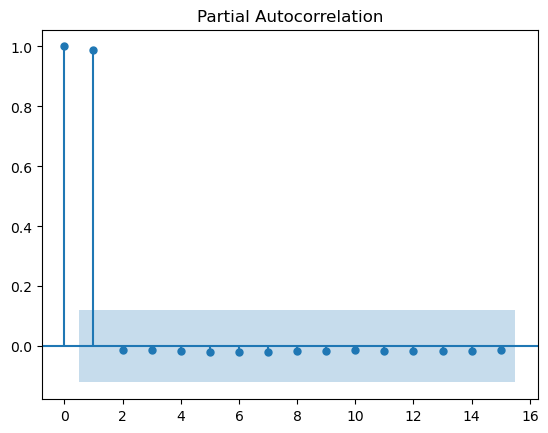

In [356]:
# Plot the ACF
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(limited_df, lags=50);
plot_pacf(limited_df,lags=15, method='ywm');

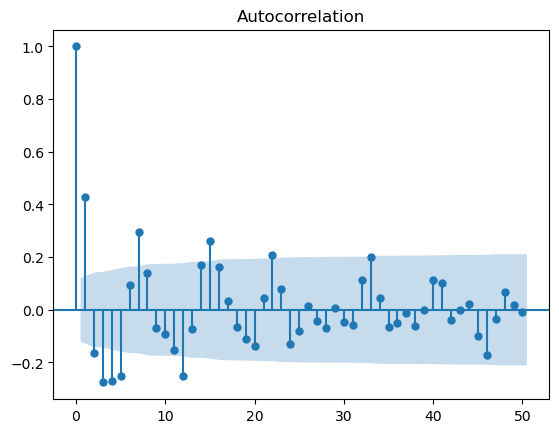

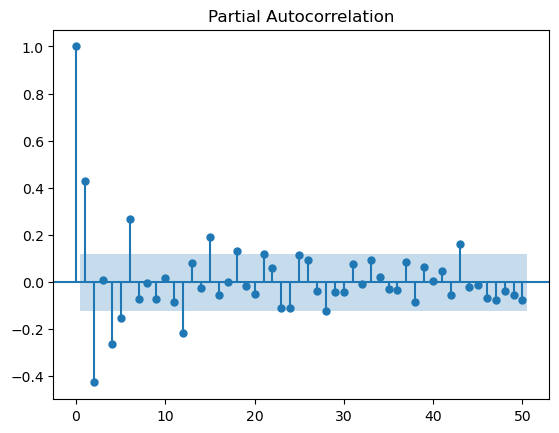

In [639]:
plot_acf(diff_df2, lags=50);
plot_pacf(diff_df2,lags=50, method='ywm');

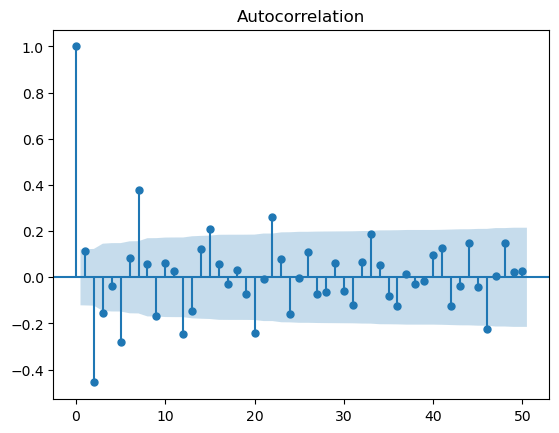

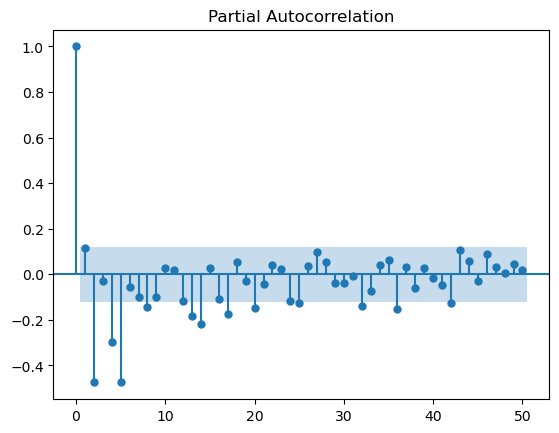

In [358]:
plot_acf(diff_df3, lags=50);
plot_pacf(diff_df3,lags=50, method='ywm');

# Creating Roll-Forward Partitioning

In [ ]:
for train_index, test_index in split.split(data):
    train = data.iloc[train_index]
    test = data.iloc[test_index]

In [ ]:
class roll(self, data):
    
    def __init__(self):
        # creating cutoff
        cutoff = round(ts_weekly.shape[0]* .8)

        # creating train and test
        self.train = ts_weekly[:cutoff]
        self.test = ts_weekly[cutoff:]
            
    def baseline(self):
        baseline = self.train.shift(1)
        
        mean_squared_error(self.train[1:], baseline.dropna(), squared=False)
        
        fig, ax = plt.subplots()
        residuals = baseline[1:] - self.train[1:]
        ax.plot(residuals.index, residuals)
        ax.plot(residuals.index, residuals.rolling(30).std());

        
        
        fig, ax = plt.subplots()
        ax.plot(residuals.index, residuals.rolling(30).var());
        

        def cross(self):
            
            split = TimeSeriesSplit()

            for train_ind, val_ind in split.split(self.train):
                ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
                preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
                true = train_with_ind.iloc[val_ind, -1]
                print(np.sqrt(mean_squared_error(true, preds)))

            ouotputs = {'train' : train, 'test' : test, }

            return outputs

In [406]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(limited_df.reset_index()):
    ar = ARIMA(endog=limited_df.reset_index().iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = limited_df.reset_index().iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))


66860.6813829898
77708.29140485467
60145.016283072044
45709.386445697935
100601.6685723868


# Train Test Split

In [468]:
def ttsplit(data):
        cutoff = round(data.shape[0]* .8)
        # creating train and test
        train = data[:cutoff]
        test = data[cutoff:]
        return(train, test)
train, test = ttsplit(limited_df)

In [444]:
test

53

In [446]:
train

Date
1996-04-01    189216.666667
1996-05-01    188611.111111
1996-06-01    188011.111111
1996-07-01    187438.888889
1996-08-01    186900.000000
1996-09-01    186494.444444
1996-10-01    186222.222222
1996-11-01    186116.666667
1996-12-01    186305.555556
1997-01-01    186750.000000
1997-02-01    187261.111111
1997-03-01    187677.777778
1997-04-01    188144.444444
1997-05-01    188683.333333
1997-06-01    189227.777778
1997-07-01    189800.000000
1997-08-01    190394.444444
1997-09-01    191033.333333
1997-10-01    191777.777778
1997-11-01    192655.555556
1997-12-01    193827.777778
1998-01-01    195233.333333
1998-02-01    196688.888889
1998-03-01    198083.333333
1998-04-01    199622.222222
1998-05-01    201266.666667
1998-06-01    203027.777778
1998-07-01    204850.000000
1998-08-01    206722.222222
1998-09-01    208655.555556
1998-10-01    210700.000000
1998-11-01    212861.111111
1998-12-01    215261.111111
1999-01-01    217816.666667
1999-02-01    220333.333333
1999-03-01    2

# Step 5: ARIMA Modeling

In [471]:
def pdq_fitting(data, convergenceWarning=False, summary=False):
    import warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error
    '''
    Function loops through finding the best p, d, q sequence
    convergenceWarning: True = ignore convergence warnings, False = don't ignore
    Summary: print for each pdq check
    '''
    results = []
    
#     data = data.reset_index()

    for p in range(5):
        for d in range(5):
            for q in range(5):
                # try, except to catch warnings and errors
                try:
                    # Catching Warnings
                    with warnings.catch_warnings(record=True) as warn:
                        if convergenceWarning:    
                            warnings.simplefilter("ignore", ConvergenceWarning)
                        
#                         split = TimeSeriesSplit()
#                         for train_ind, val_ind in split.split(data):
#                             model = ARIMA(endog=data.iloc[train_ind, -1], order=(p, d, q)).fit()


                        model = ARIMA(data, order=(p, d, q)).fit()
                    # If there is a warning, remove
                    if warn: 
                        if summary:
                            print(f"\n\033[1m\033[93m{warn[0].message}\nWarning while fitting ARIMA model with p={p}, d={d}, q={q}. Skipping\033[0m")
                            print(f"{'-'*100}\n")
                        else:
                            continue
                    # No Warning, keep
                    else:    
                        aic_score = model.aic
                        results.append((aic_score, p, d, q))
                        if summary:
                            print("P of: ",p)
                            print("d of: ",d)
                            print("q of: ",q)
                            print("AIC score: ", aic_score)
                            print(f"{'-'*100}\n")

                except Exception as e:
                    print(f"\033[1m\033[91m{e}\nFailed to fit ARIMA model with p={p}, d={d}, q={q}. Skipping\033[0m")
                    print(f"{'-'*100}\n")

    results.sort()
    print(f"Best p, d, q for lowest AIC score: {results[0][0]}")
    print("P of: ", results[0][1])
    print("d of: ", results[0][2])
    print("q of: ", results[0][3])

In [607]:
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import Parallel, delayed
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def pdqs_fitting(data, S, n, convergenceWarning=False, summary=False, n_jobs=-1, ):
    
    # replacing for loop with array
    options = np.array(list(itertools.product(np.arange(n), repeat=6)))
    
    results = []
    
#     data = data.reset_index()

    def fit_model(p, d, q, P, D, Q, S, summary, convergenceWarning):
        # try, except to catch warnings and errors
        try:
            # Catching Warnings
            warnings.filterwarnings("ignore", message= "Example message")
           
            with warnings.catch_warnings(record=True) as warn:
                if convergenceWarning: 
                    warnings.simplefilter("ignore", ConvergenceWarning)
                    
#                 split = TimeSeriesSplit()
#                 for train_ind, val_ind in split.split(data):
#                     model = SARIMAX(endog=data.iloc[train_ind, -1], order=(p, d, q), seasonal_order=(P, D, Q, S),
#                                     enforce_stationarity=False, enforce_invertibility=False).fit()

                
                model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S),
                               enforce_stationarity=False, enforce_invertibility=False).fit()

            # If there is a warning, remove
            if warn: 
                if summary:
                    print(f"\n\033[1m\033[93m{warn[0].message}\nWarning while fitting ARIMA model with p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={S}. Skipping\033[0m")
                    print(f"{'-'*100}\n")
                else:
                    pass
            # No Warning, keep
            else:    
                air_score = model.aic
                if summary:
                    sys.stdout.write(f"({p},{d},{q})\n({P},{D},{Q},{S})")
                    print("AIC score: ", air_score)
                    print(f"{'-'*100}\n")
                return ((air_score, (p, d, q), (P, D, Q, S)))

        except Exception as e:
            print(f"\033[1m\033[91m{e}\nFailed to fit ARIMA model with p={p}, d={d}, q={q}, d={d}, P={P}, D={D}, Q={Q}, s={S}. Skipping\033[0m")
            print(f"{'-'*100}\n")
            
    # running in parallel
    
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(fit_model)(p, d, q, P, D, Q, S, summary, convergenceWarning)
        for p, d, q, P, D, Q in options)
    

    new_results = [r for r in results if r is not None]
    

    new_results.sort()
    print(f"Best p, d, q and P, D, Q, s for lowest AIC score: {new_results[0][0]}")
    print(f"pdq= {new_results[0][1]}")
    print(f"PDQs= {new_results[0][2]}")

In [609]:
pdqs_fitting(train, 12,4, summary=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed: 60.5min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed: 80.8min


Best p, d, q and P, D, Q, s for lowest AIC score: 2240.298784487236
pdq= (1, 3, 3)
PDQs= (0, 2, 3, 12)


[Parallel(n_jobs=-1)]: Done 4096 out of 4096 | elapsed: 82.6min finished


In [611]:
# Frequency = MS
pdqs_fitting(train, 12,3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min


Best p, d, q and P, D, Q, s for lowest AIC score: 2480.9609486571035
pdq= (0, 2, 2)
PDQs= (0, 2, 2, 12)


[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  5.0min finished


In [362]:
# freqency is M
pdqs_fitting(diff_df2, 12,3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min


Best p, d, q and P, D, Q, s for lowest AIC score: 3355.1068719360815
pdq= (1, 0, 2)
PDQs= (0, 2, 2, 12)


[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  7.5min finished


In [277]:
pdqs_fitting(diff_df2, 12,5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 121.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 167.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 209.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 266.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 329.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 407.7min


KeyboardInterrupt: 

In [112]:
start_time = time.time()

res1 = pdqs_fitting(limited_df, 12, 3, summary=True)

end_time = time.time()
print(f"Time taken: {end_time - start_time}")

(0,0,0)
(0,0,0,12)
AIC score:  7701.276380246601
----------------------------------------------------------------------------------------------------

(0,0,0)
(0,0,1,12)
AIC score:  7198.024090316051
----------------------------------------------------------------------------------------------------

(0,0,0)
(0,0,2,12)
AIC score:  11930.788202967724
----------------------------------------------------------------------------------------------------

(0,0,0)
(0,1,0,12)
AIC score:  6062.371889194669
----------------------------------------------------------------------------------------------------

(0,0,0)
(0,1,1,12)
AIC score:  5786.662950605822
----------------------------------------------------------------------------------------------------

(0,0,0)
(0,1,2,12)
AIC score:  5284.893045826581
----------------------------------------------------------------------------------------------------

(0,0,0)
(0,2,0,12)
AIC score:  5448.326948659928
--------------------------------------------

(0,0,2)
(0,0,2,12)
AIC score:  649595.073979294
----------------------------------------------------------------------------------------------------

(0,0,2)
(0,1,0,12)
AIC score:  5821.82715470067
----------------------------------------------------------------------------------------------------

(0,0,2)
(0,1,1,12)
AIC score:  8357.838331743287
----------------------------------------------------------------------------------------------------

(0,0,2)
(0,1,2,12)
AIC score:  6668.32375510075
----------------------------------------------------------------------------------------------------

(0,0,2)
(0,2,0,12)
AIC score:  5187.681106486736
----------------------------------------------------------------------------------------------------

(0,0,2)
(0,2,1,12)
AIC score:  6269.390502720105
----------------------------------------------------------------------------------------------------

(0,0,2)
(0,2,2,12)
AIC score:  5798.94463564738
-------------------------------------------------

(0,1,1)
(0,1,1,12)
AIC score:  4136.771899719595
----------------------------------------------------------------------------------------------------

(0,1,1)
(0,1,2,12)
AIC score:  3913.8233869291894
----------------------------------------------------------------------------------------------------

(0,1,1)
(0,2,0,12)
AIC score:  4445.113347547886
----------------------------------------------------------------------------------------------------

(0,1,1)
(0,2,1,12)
AIC score:  4185.952744866729
----------------------------------------------------------------------------------------------------

(0,1,1)
(0,2,2,12)
AIC score:  3831.8162921221287
----------------------------------------------------------------------------------------------------

(0,1,1)
(1,0,0,12)
AIC score:  4632.008207205855
----------------------------------------------------------------------------------------------------

(0,1,1)
(1,0,1,12)
AIC score:  4356.23986478579
--------------------------------------------

(0,2,0)
(0,1,2,12)
AIC score:  3779.2105808482543
----------------------------------------------------------------------------------------------------

(0,2,0)
(0,2,0,12)
AIC score:  4314.096288358376
----------------------------------------------------------------------------------------------------

(0,2,0)
(0,2,1,12)
AIC score:  3975.8897453891677
----------------------------------------------------------------------------------------------------

(0,2,0)
(0,2,2,12)
AIC score:  3761.956240803461
----------------------------------------------------------------------------------------------------

(0,2,0)
(1,0,0,12)
AIC score:  4049.1825585118117
----------------------------------------------------------------------------------------------------

(0,2,0)
(1,0,1,12)
AIC score:  4035.67193609641
----------------------------------------------------------------------------------------------------

(0,2,0)
(1,0,2,12)
AIC score:  3824.9213516714
---------------------------------------------

(0,2,2)
(0,1,2,12)
AIC score:  3556.895782878669
----------------------------------------------------------------------------------------------------

(0,2,2)
(0,2,0,12)
AIC score:  4152.448137083519
----------------------------------------------------------------------------------------------------

(0,2,2)
(0,2,1,12)
AIC score:  3876.995969925964
----------------------------------------------------------------------------------------------------

(0,2,2)
(0,2,2,12)
AIC score:  3584.196053915248
----------------------------------------------------------------------------------------------------

(0,2,2)
(1,0,0,12)
AIC score:  3930.697068774234
----------------------------------------------------------------------------------------------------

(0,2,2)
(1,0,1,12)
AIC score:  3844.478551468647
----------------------------------------------------------------------------------------------------

(0,2,2)
(1,0,2,12)
AIC score:  3642.909833980344
---------------------------------------------

(1,0,1)
(0,2,0,12)
AIC score:  4662.216294381515
----------------------------------------------------------------------------------------------------

(1,0,1)
(0,2,1,12)
AIC score:  4164.178955102747
----------------------------------------------------------------------------------------------------

(1,0,1)
(0,2,2,12)
AIC score:  3869.1448830972595
----------------------------------------------------------------------------------------------------

(1,0,1)
(1,0,0,12)
AIC score:  4497.50684540852
----------------------------------------------------------------------------------------------------

(1,0,1)
(1,0,1,12)
AIC score:  4459.586067581617
----------------------------------------------------------------------------------------------------

(1,0,1)
(1,0,2,12)
AIC score:  4250.668731405482
----------------------------------------------------------------------------------------------------

(1,0,1)
(1,1,0,12)
AIC score:  4193.5621928381715
--------------------------------------------

(1,1,0)
(0,2,0,12)
AIC score:  4314.3867937337145
----------------------------------------------------------------------------------------------------

(1,1,0)
(0,2,1,12)
AIC score:  4049.2075437622116
----------------------------------------------------------------------------------------------------

(1,1,0)
(0,2,2,12)
AIC score:  3800.042145625488
----------------------------------------------------------------------------------------------------

(1,1,0)
(1,0,0,12)
AIC score:  4049.5245138147397
----------------------------------------------------------------------------------------------------

(1,1,0)
(1,0,1,12)
AIC score:  4051.081251668506
----------------------------------------------------------------------------------------------------

(1,1,0)
(1,0,2,12)
AIC score:  3844.29304308616
----------------------------------------------------------------------------------------------------

(1,1,0)
(1,1,0,12)
AIC score:  3996.0342312810717
------------------------------------------

(1,1,2)
(0,2,1,12)
AIC score:  4011.3454886282884
----------------------------------------------------------------------------------------------------

(1,1,2)
(0,2,2,12)
AIC score:  3563.9544029826084
----------------------------------------------------------------------------------------------------

(1,1,2)
(1,0,0,12)
AIC score:  3912.437736735582
----------------------------------------------------------------------------------------------------

(1,1,2)
(1,0,1,12)
AIC score:  3853.431057578232
----------------------------------------------------------------------------------------------------

(1,1,2)
(1,0,2,12)
AIC score:  3676.8138360149674
----------------------------------------------------------------------------------------------------

(1,1,2)
(1,1,0,12)
AIC score:  3886.9463270715064
----------------------------------------------------------------------------------------------------

(1,1,2)
(1,1,1,12)
AIC score:  3832.1211867919646
----------------------------------------

(1,2,1)
(0,2,1,12)
AIC score:  3980.7715205555696
----------------------------------------------------------------------------------------------------

(1,2,1)
(0,2,2,12)
AIC score:  3642.914033247296
----------------------------------------------------------------------------------------------------

(1,2,1)
(1,0,0,12)
AIC score:  3939.0919042434493
----------------------------------------------------------------------------------------------------

(1,2,1)
(1,0,1,12)
AIC score:  3886.721538167333
----------------------------------------------------------------------------------------------------

(1,2,1)
(1,0,2,12)
AIC score:  3680.622036317637
----------------------------------------------------------------------------------------------------

(1,2,1)
(1,1,0,12)
AIC score:  3939.4703341191025
----------------------------------------------------------------------------------------------------

(1,2,1)
(1,1,1,12)
AIC score:  3905.230703751663
------------------------------------------

(2,0,0)
(0,2,2,12)
AIC score:  3888.731979579137
----------------------------------------------------------------------------------------------------

(2,0,0)
(1,0,0,12)
AIC score:  4051.0141833324637
----------------------------------------------------------------------------------------------------

(2,0,0)
(1,0,1,12)
AIC score:  4573.133216574428
----------------------------------------------------------------------------------------------------

(2,0,0)
(1,0,2,12)
AIC score:  4672.935823444478
----------------------------------------------------------------------------------------------------

(2,0,0)
(1,1,0,12)
AIC score:  4003.9894680737502
----------------------------------------------------------------------------------------------------

(2,0,0)
(1,1,1,12)
AIC score:  4275.453282850549
----------------------------------------------------------------------------------------------------

Batch 5 completed in 159.99 seconds
(2,0,0)
(1,1,2,12)
AIC score:  3947.767407470473
-------

(2,0,2)
(0,2,2,12)
AIC score:  4150.535010100462
----------------------------------------------------------------------------------------------------

(2,0,2)
(1,0,0,12)
AIC score:  3985.4908364575276
----------------------------------------------------------------------------------------------------

(2,0,2)
(1,0,1,12)
AIC score:  4873.840420312093
----------------------------------------------------------------------------------------------------

(2,0,2)
(1,0,2,12)
AIC score:  4692.733636737667
----------------------------------------------------------------------------------------------------

(2,0,2)
(1,1,0,12)
AIC score:  3890.088488436475
----------------------------------------------------------------------------------------------------

(2,0,2)
(1,1,1,12)
AIC score:  4151.0140462876825
----------------------------------------------------------------------------------------------------

(2,0,2)
(1,1,2,12)
AIC score:  3884.6591445118647
------------------------------------------

(2,1,1)
(0,2,2,12)
AIC score:  3637.2599177225393
----------------------------------------------------------------------------------------------------

(2,1,1)
(1,0,0,12)
AIC score:  3929.1921407965456
----------------------------------------------------------------------------------------------------

(2,1,1)
(1,0,1,12)
AIC score:  3902.494765377864
----------------------------------------------------------------------------------------------------

(2,1,1)
(1,0,2,12)
AIC score:  3694.172663737761
----------------------------------------------------------------------------------------------------

(2,1,1)
(1,1,0,12)
AIC score:  3911.839302417381
----------------------------------------------------------------------------------------------------

(2,1,1)
(1,1,1,12)
AIC score:  3886.256426735801
----------------------------------------------------------------------------------------------------

(2,1,1)
(1,1,2,12)
AIC score:  3596.4461005176995
------------------------------------------

(2,2,0)
(1,0,2,12)
AIC score:  3684.736315020512
----------------------------------------------------------------------------------------------------

(2,2,0)
(1,1,0,12)
AIC score:  3853.900477591368
----------------------------------------------------------------------------------------------------

(2,2,0)
(1,1,1,12)
AIC score:  3854.8613954185516
----------------------------------------------------------------------------------------------------

(2,2,0)
(1,1,2,12)
AIC score:  3685.18271485303
----------------------------------------------------------------------------------------------------

(2,2,0)
(1,2,0,12)
AIC score:  3815.669990050401
----------------------------------------------------------------------------------------------------

(2,2,0)
(1,2,1,12)
AIC score:  3815.899394650033
----------------------------------------------------------------------------------------------------

(2,2,0)
(1,2,2,12)
AIC score:  3636.7786430900583
--------------------------------------------

(2,2,2)
(1,0,2,12)
AIC score:  3647.520211114877
----------------------------------------------------------------------------------------------------

(2,2,2)
(1,1,0,12)
AIC score:  3854.483274835054
----------------------------------------------------------------------------------------------------

(2,2,2)
(1,1,1,12)
AIC score:  3830.407207881569
----------------------------------------------------------------------------------------------------

(2,2,2)
(1,1,2,12)
AIC score:  3598.7865431285136
----------------------------------------------------------------------------------------------------

(2,2,2)
(1,2,0,12)
AIC score:  3816.6111383832013
----------------------------------------------------------------------------------------------------

(2,2,2)
(1,2,1,12)
AIC score:  3786.5722992187093
----------------------------------------------------------------------------------------------------

(2,2,2)
(1,2,2,12)
AIC score:  3680.8110807995126
-----------------------------------------

In [472]:
pdq_fitting(limited_df, summary=True)

P of:  0
d of:  0
q of:  0
AIC score:  8382.193081140813
----------------------------------------------------------------------------------------------------

P of:  0
d of:  0
q of:  1
AIC score:  6970.186354457843
----------------------------------------------------------------------------------------------------

P of:  0
d of:  0
q of:  2
AIC score:  6916.265679211723
----------------------------------------------------------------------------------------------------

P of:  0
d of:  0
q of:  3
AIC score:  6897.138631942097
----------------------------------------------------------------------------------------------------

P of:  0
d of:  0
q of:  4
AIC score:  6886.12000316144
----------------------------------------------------------------------------------------------------

P of:  0
d of:  1
q of:  0
AIC score:  5059.558351689123
----------------------------------------------------------------------------------------------------

P of:  0
d of:  1
q of:  1
AIC score:  5041.040

P of:  1
d of:  4
q of:  3
AIC score:  4228.022935489138
----------------------------------------------------------------------------------------------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
Warning while fitting ARIMA model with p=1, d=4, q=4. Skipping
----------------------------------------------------------------------------------------------------

P of:  2
d of:  0
q of:  0
AIC score:  4297.513709523148
----------------------------------------------------------------------------------------------------

P of:  2
d of:  0
q of:  1
AIC score:  4179.761011996737
----------------------------------------------------------------------------------------------------

P of:  2
d of:  0
q of:  2
AIC score:  4133.41349750764
----------------------------------------------------------------------------------------------------

P of:  2
d of:  0
q of:  3
AIC score:  4085.4003983038087
-----------------------------------------------------------------------

P of:  3
d of:  3
q of:  1
AIC score:  4225.181791007597
----------------------------------------------------------------------------------------------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
Warning while fitting ARIMA model with p=3, d=3, q=2. Skipping
----------------------------------------------------------------------------------------------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
Warning while fitting ARIMA model with p=3, d=3, q=3. Skipping
----------------------------------------------------------------------------------------------------


Maximum Likelihood optimization failed to converge. Check mle_retvals
Warning while fitting ARIMA model with p=3, d=3, q=4. Skipping
----------------------------------------------------------------------------------------------------

P of:  3
d of:  4
q of:  0
AIC score:  4315.059431514539
----------------------------------------------------------------------------

# Model parameters

     ARIMA            SARIMAX      SARIMAX
 --------------
    p of: 1           p of: 2      p of: 1
    d of: 1           d of: 0      d of: 0
    q of: 4           q of: 2      q of: 2
                      P of: 2      P of: 0
                      D of: 2      D of: 2
                      Q of: 2      Q of: 2
                      s of: 12     s of: 12

{'fopt': 7.637688847078926, 'gopt': array([-1.52429092e-04,  2.66453527e-10, -7.07223435e-04,  3.83736243e-04,
       -3.45281137e-05, -2.10942375e-07]), 'fcalls': 504, 'warnflag': 1, 'converged': False, 'iterations': 50}
                               SARIMAX Results                                
Dep. Variable:     MedianHousingSales   No. Observations:                  263
Model:                 ARIMA(1, 1, 4)   Log Likelihood               -2008.712
Date:                Tue, 09 May 2023   AIC                           4029.424
Time:                        22:39:00   BIC                           4050.834
Sample:                    06-01-1996   HQIC                          4038.030
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

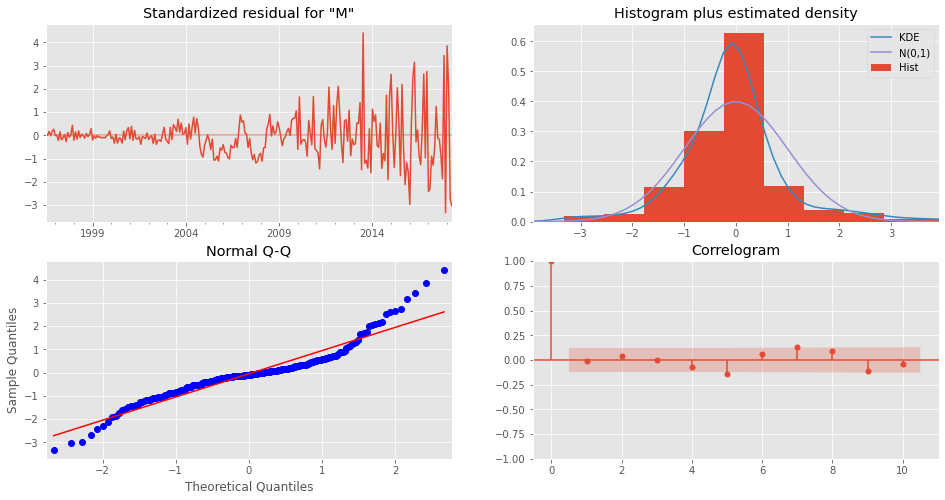

In [366]:
from statsmodels.tsa.arima.model import ARIMA
def ts_performance(data, pdq):
    '''
    pdq : (p,d,q)
    '''
    arma = ARIMA(data,order= pdq).fit()
    print(arma.mle_retvals)
    print(arma.summary())
    arma.plot_diagnostics(figsize=(16, 8))
ts_performance(diff_df2, (1,1,4))

{'fopt': 6.71014802433106, 'gopt': array([ 2.79058554e-05,  6.85718149e-06, -2.84631874e-05, -2.23128450e-04]), 'fcalls': 95, 'warnflag': 0, 'converged': True, 'iterations': 16}
                                      SARIMAX Results                                      
Dep. Variable:                  MedianHousingSales   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1422.551
Date:                             Thu, 11 May 2023   AIC                           2853.103
Time:                                     09:43:38   BIC                           2866.006
Sample:                                 04-01-1996   HQIC                          2858.332
                                      - 11-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

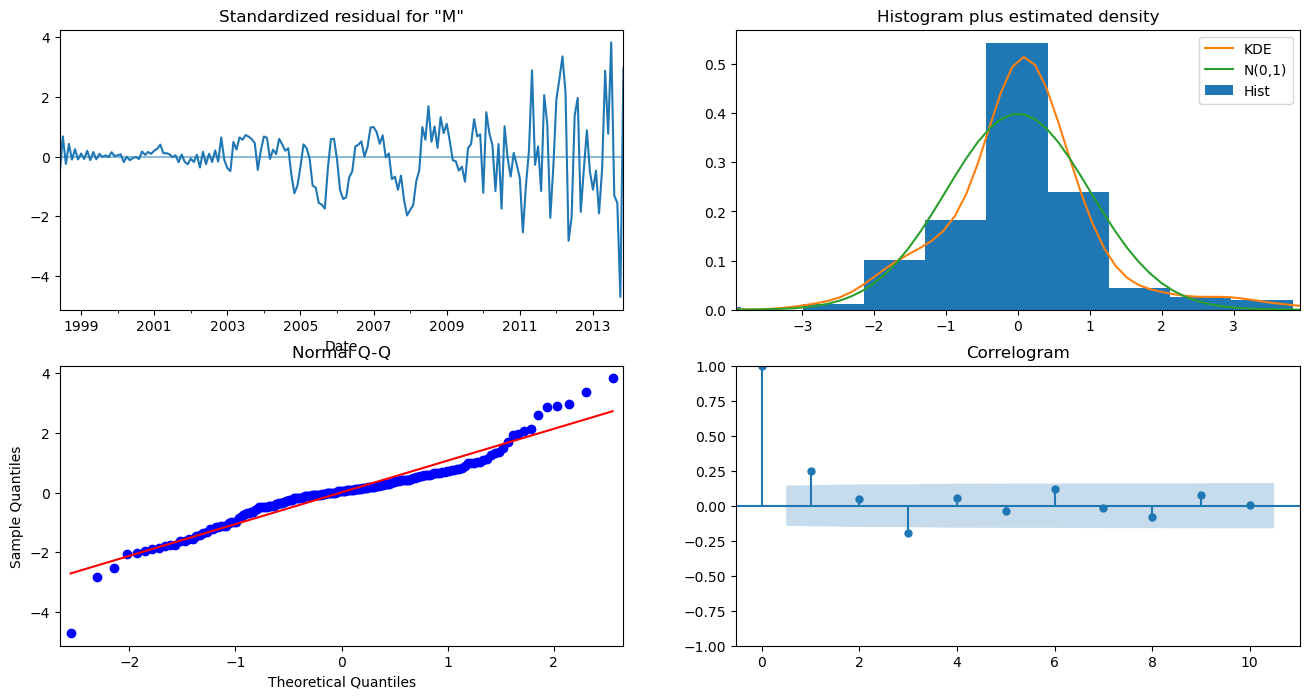

In [640]:
def ts_performance(data, pdq, pdqs):
    '''
    pdq : (p,d,q)
    '''
    model = SARIMAX(data, order=pdq, seasonal_order=pdqs,
                enforce_stationarity=False, enforce_invertibility=False).fit()
    print(model.mle_retvals)
    print(model.summary())
    fig = model.plot_diagnostics(figsize=(16, 8))
    fig.savefig('final_plots/diagnostics.png')
    fig
    return model
sari_model = ts_performance(train, (1,1,1), (1,1,0,12))

{'fopt': 5.24598769605638, 'gopt': array([ 1.37058365e-05,  2.12549978e-06, -5.47736967e-05,  7.36686268e-05,
        6.59178490e-05,  3.07116110e-05,  2.13192131e-05, -1.59250391e-07]), 'fcalls': 396, 'warnflag': 0, 'converged': True, 'iterations': 41}
                                     SARIMAX Results                                      
Dep. Variable:                 MedianHousingSales   No. Observations:                  212
Model:             SARIMAX(1, 3, 3)x(0, 2, 3, 12)   Log Likelihood               -1112.149
Date:                            Thu, 11 May 2023   AIC                           2240.299
Time:                                    09:27:24   BIC                           2264.113
Sample:                                04-01-1996   HQIC                          2249.975
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
                 c

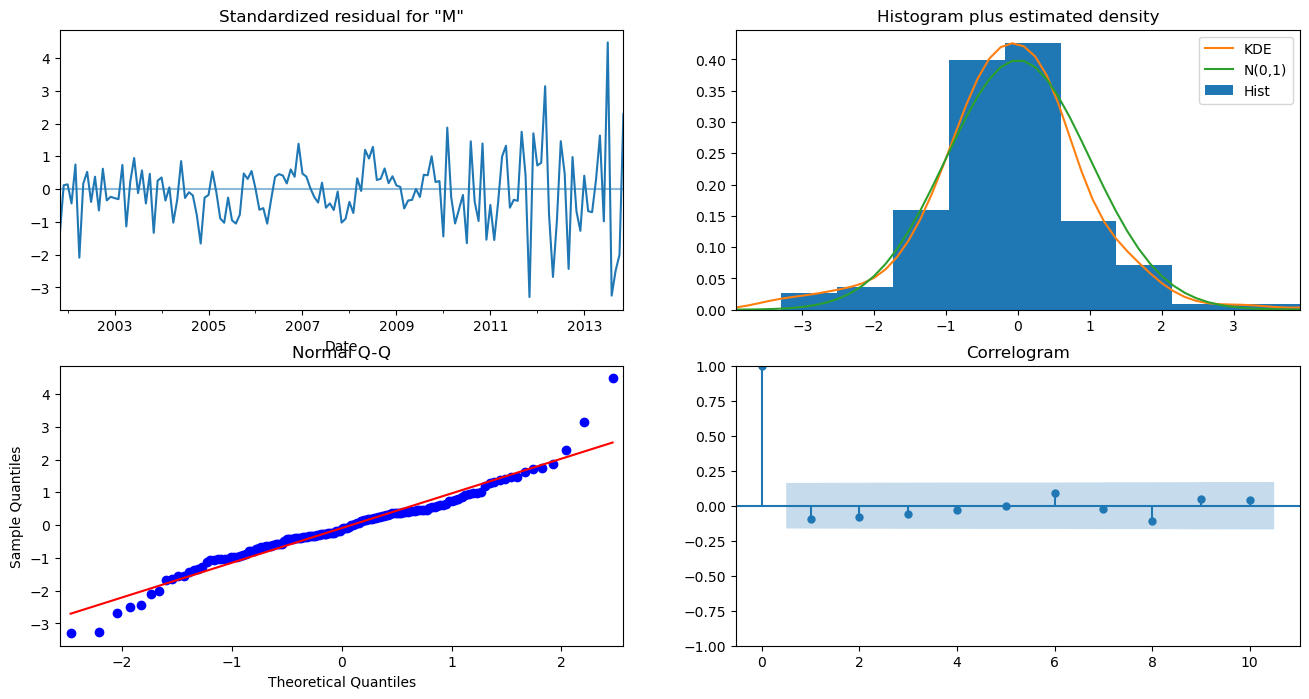

In [629]:
def ts_performance(data, pdq, pdqs):
    '''
    pdq : (p,d,q)
    '''
    model = SARIMAX(data, order=pdq, seasonal_order=pdqs,
                enforce_stationarity=False, enforce_invertibility=False).fit()
    print(model.mle_retvals)
    print(model.summary())
    model.plot_diagnostics(figsize=(16, 8))
    return model
sari_model = ts_performance(train, (1,3,3), (0,2,3,12))

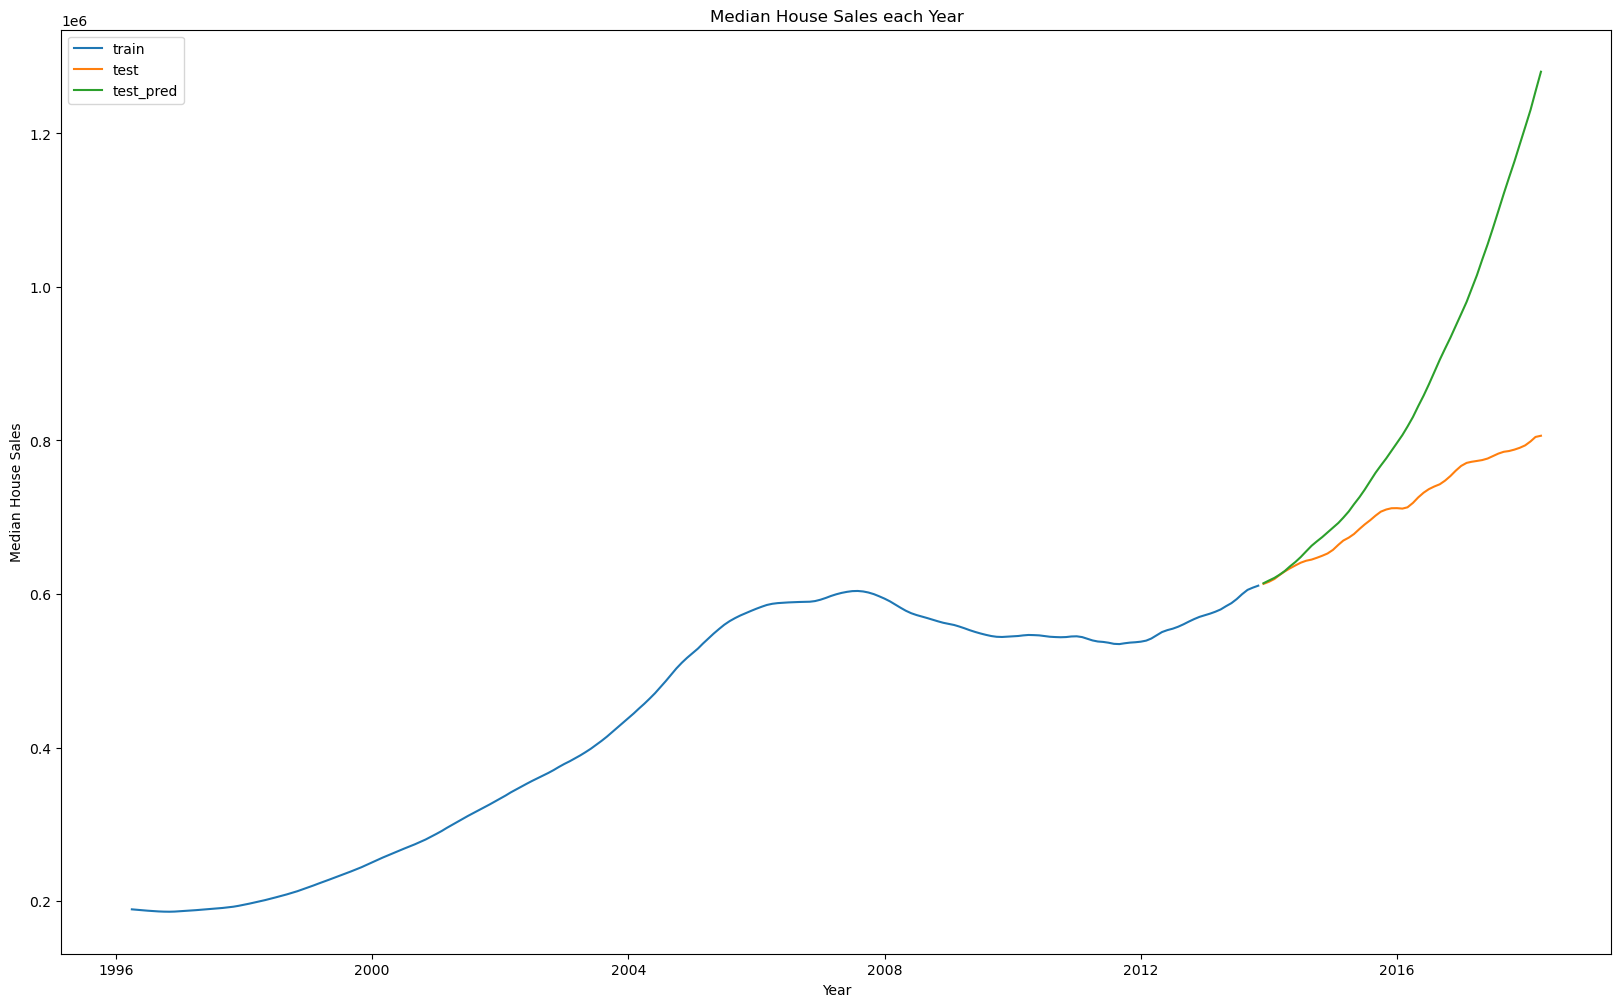

In [630]:
y_hat_train = sari_model.predict(typ='levels')
y_hat_test = sari_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(train, label='train')
ax.plot(test, label='test')
# ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')
ax.set_xlabel('Year')
ax.set_ylabel('Median House Sales')
ax.set_title('Median House Sales each Year')
# ax.set_xticks(limited_df.index)
# ax.set_xticklabels(limited_df.index)
plt.legend();
# plt.savefig('forcasting.png',dpi=300)

In [613]:
# def rolling_ts_performance(data, pdq, pdqs):
#     '''
#     pdq : (p,d,q)
#     '''
#     split = TimeSeriesSplit()
#     data = data.reset_index()
#     for train_ind, val_ind in split.split(data):
        
#         model = SARIMAX(data.iloc[train_ind, -1], order=pdq, seasonal_order=pdqs,
#                        enforce_stationarity=False, enforce_invertibility=False).fit()
#     print(model.mle_retvals)
#     print(model.summary())
#     model.plot_diagnostics(figsize=(16, 8))
#     return model
# sari_model = rolling_ts_performance(train, (1,3,3), (0,2,3,12))

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Median Housing Sales')

Text(0.5, 1.0, 'ARIMA Model')

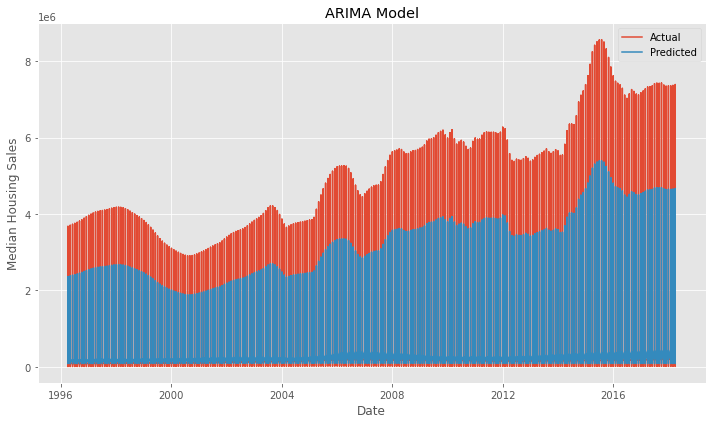

In [371]:
model = ARIMA(final_df['MedianHousingSales'], order=(1, 0, 0))
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=0, end=len(final_df)-1)

# Plot the original data and predictions
plt.figure(figsize=(10, 6))
plt.plot(final_df['Date'], final_df['MedianHousingSales'], label='Actual')
plt.plot(final_df['Date'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('ARIMA Model')
plt.legend()
plt.tight_layout();

# Step 6: Interpreting Results

- Arima model shows:










# Forecasting


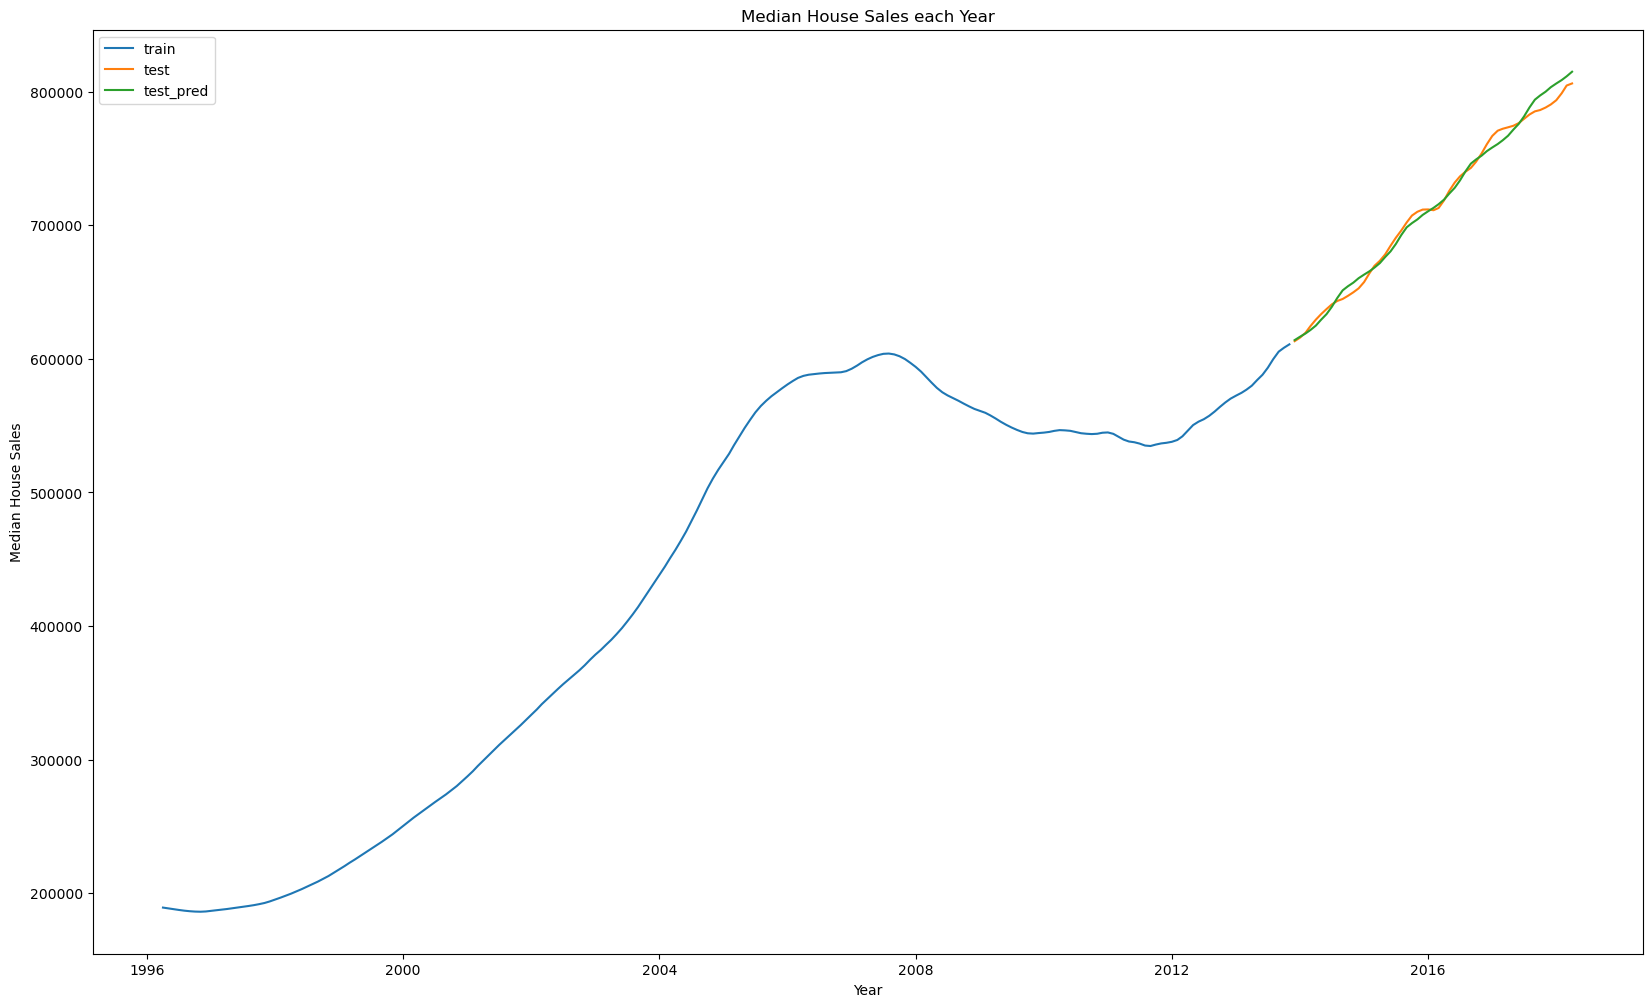

In [642]:
y_hat_train = sari_model.predict(typ='levels')
y_hat_test = sari_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(train, label='train')
ax.plot(test, label='test')
# ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')
ax.set_xlabel('Year')
ax.set_ylabel('Median House Sales')
ax.set_title('Median House Sales each Year')
# ax.set_xticks(limited_df.index)
# ax.set_xticklabels(limited_df.index)
plt.legend();
# plt.savefig('final_plots/forcasting.png',dpi=300)

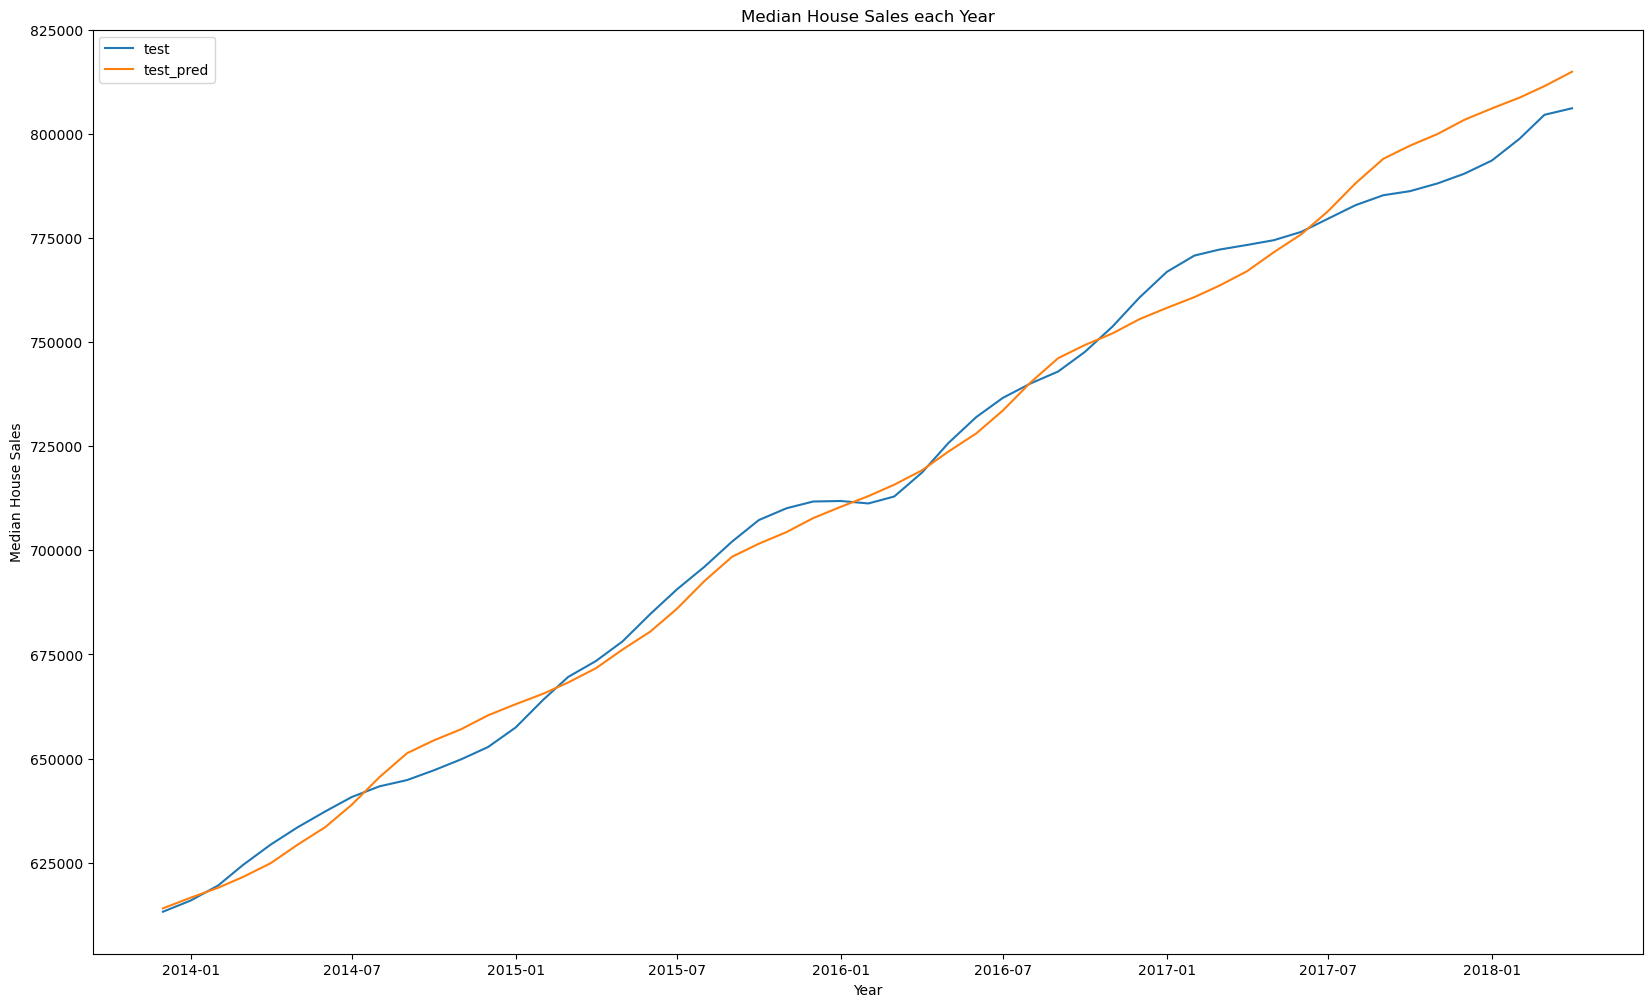

In [633]:
y_hat_train = sari_model.predict(typ='levels')
y_hat_test = sari_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(20,12))
# ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_test, label='test_pred')
ax.set_xlabel('Year')
ax.set_ylabel('Median House Sales')
ax.set_title('Median House Sales each Year')
# ax.set_xticks(test.index)
# ax.set_xticklabels(test.index)
plt.legend();
plt.savefig('final_plots/forcasted.png',dpi=300)

In [657]:
forecast

2013-12-01    614035.507890
2014-01-01    616583.395524
2014-02-01    618989.209372
2014-03-01    621585.100539
2014-04-01    624887.706310
2014-05-01    629301.586377
2014-06-01    633505.461553
2014-07-01    638924.797454
2014-08-01    645536.981183
2014-09-01    651288.871136
2014-10-01    654357.427230
2014-11-01    657076.381436
2014-12-01    660390.424974
2015-01-01    663062.220003
2015-02-01    665582.531787
2015-03-01    668284.206038
2015-04-01    671684.547641
2015-05-01    676188.809285
2015-06-01    680476.276001
2015-07-01    685972.954910
2015-08-01    692656.652757
2015-09-01    698474.593056
2015-10-01    701604.087068
2015-11-01    704379.353620
2015-12-01    707745.486421
2016-01-01    710465.425761
2016-02-01    713030.235664
2016-03-01    715773.038112
2016-04-01    719211.393174
2016-05-01    723750.788916
2016-06-01    728070.728402
2016-07-01    733597.420142
2016-08-01    740308.857531
2016-09-01    746152.436737
2016-10-01    749305.628511
2016-11-01    752102

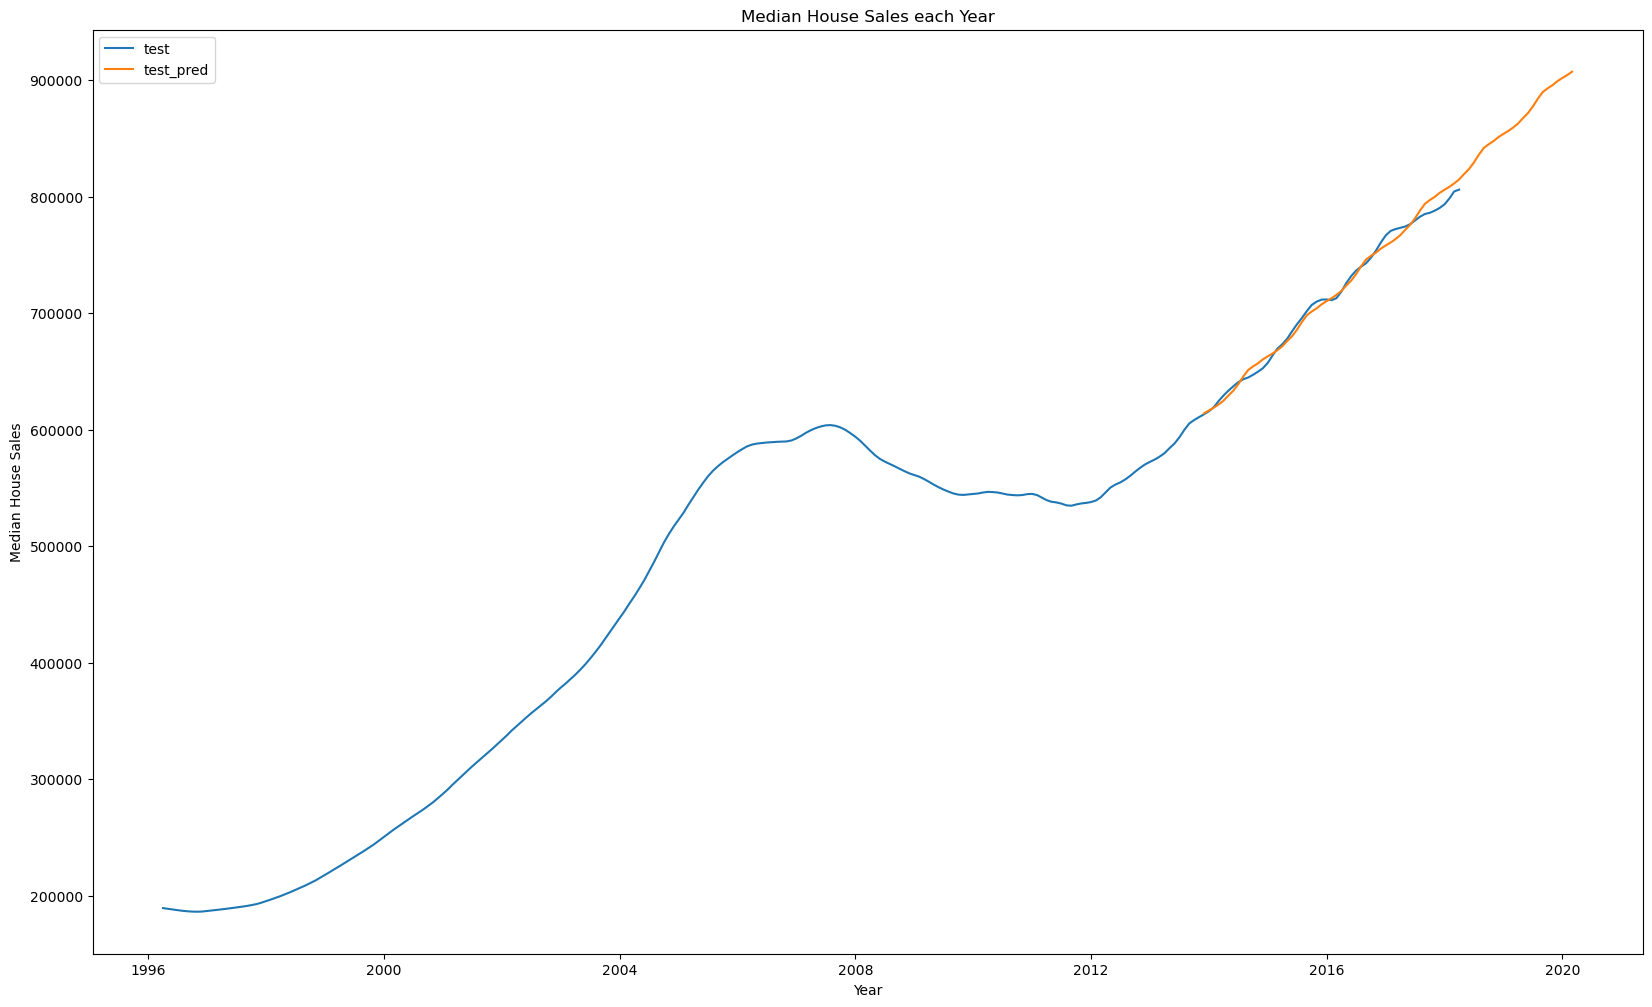

In [656]:
# y_hat_train = sari_model.predict(typ='levels')
# y_hat_test = sari_model.predict(start=test.index[0], end=test.index[-1],typ='levels')
forecast = sari_model.forecast(steps=76)
fig, ax = plt.subplots(figsize=(20,12))
# ax.plot(train, label='train')
ax.plot(limited_df, label='test')
ax.plot(forecast, label='test_pred')
ax.set_xlabel('Year')
ax.set_ylabel('Median House Sales')
ax.set_title('Median House Sales each Year')
# ax.set_xticks(test.index)
# ax.set_xticklabels(test.index)
plt.legend();
# plt.savefig('final_plots/forcasted.png',dpi=300)

In [661]:
print(f'The Root Mean Squared Error: {np.sqrt(mean_squared_error(test, y_hat_test))},\nOur model devieates from the real price by ${np.sqrt(mean_squared_error(test, y_hat_test))}')

The Root Mean Squared Error: 5756.916515359893,
Our model devieates from the real price by $5756.916515359893


In [752]:
df5 = limited_df[limited_df.index > '2015-12-01']
df5

Date
2016-01-01    711855.555556
2016-02-01    711266.666667
2016-03-01    712933.333333
2016-04-01    718650.000000
2016-05-01    725816.666667
2016-06-01    731994.444444
2016-07-01    736627.777778
2016-08-01    740077.777778
2016-09-01    742950.000000
2016-10-01    747650.000000
2016-11-01    753733.333333
2016-12-01    760644.444444
2017-01-01    766872.222222
2017-02-01    770794.444444
2017-03-01    772227.777778
2017-04-01    773338.888889
2017-05-01    774477.777778
2017-06-01    776488.888889
2017-07-01    779644.444444
2017-08-01    782905.555556
2017-09-01    785277.777778
2017-10-01    786261.111111
2017-11-01    788122.222222
2017-12-01    790450.000000
2018-01-01    793622.222222
2018-02-01    798838.888889
2018-03-01    804600.000000
2018-04-01    806166.666667
Freq: MS, Name: MedianHousingSales, dtype: float64

{'fopt': 7.4364701259197785, 'gopt': array([ 2.77555756e-06, -6.85522750e-06, -1.71873626e-04, -8.56883455e-05]), 'fcalls': 95, 'warnflag': 0, 'converged': True, 'iterations': 14}
                                      SARIMAX Results                                      
Dep. Variable:                  MedianHousingSales   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1970.665
Date:                             Thu, 11 May 2023   AIC                           3949.329
Time:                                     10:32:09   BIC                           3963.235
Sample:                                 04-01-1996   HQIC                          3954.933
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

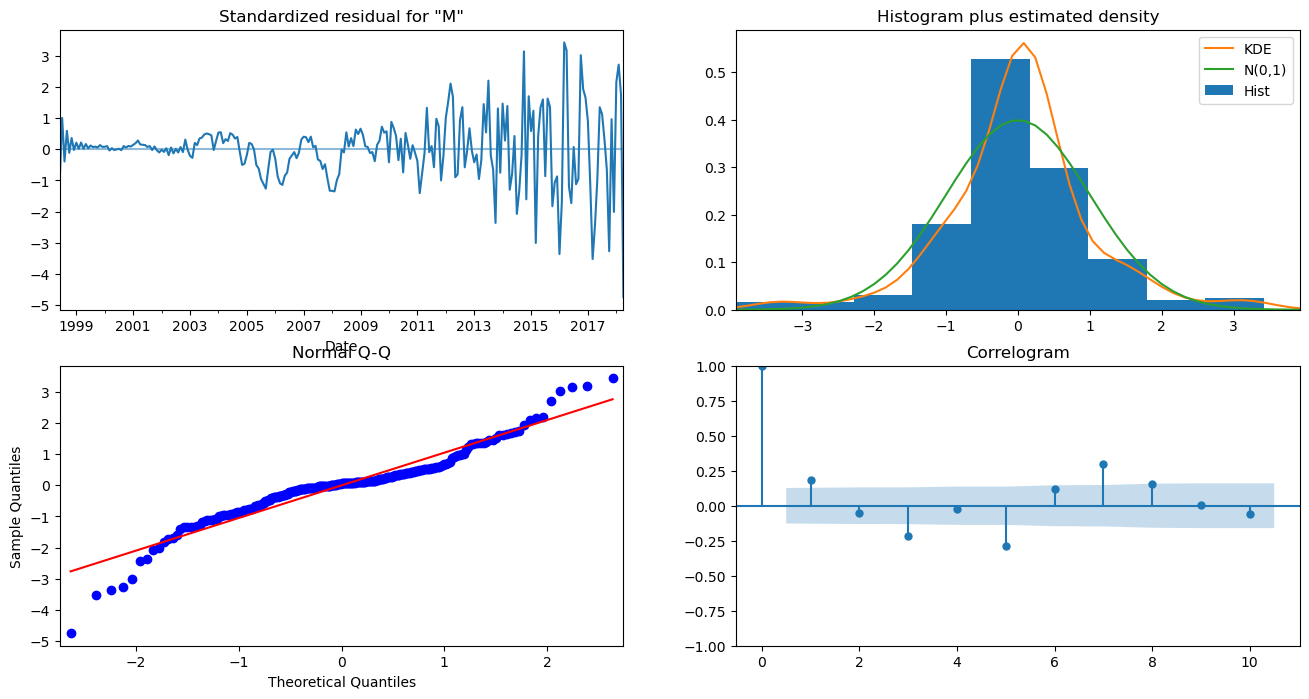

In [686]:
sari_final = ts_performance(limited_df, (1,1,1), (1,1,0,12))

In [ ]:
print(f'The Root Mean Squared Error: {np.sqrt(mean_squared_error(test, y_hat_test))},\nOur model devieates from the real price by ${np.sqrt(mean_squared_error(test, y_hat_test))}')

In [751]:
future.predicted_mean

2018-05-01    804757.925769
2018-06-01    804723.446864
2018-07-01    806212.267956
2018-08-01    808124.728447
2018-09-01    809426.661839
2018-10-01    809616.039906
2018-11-01    810866.201539
2018-12-01    812728.352548
2019-01-01    815517.855471
2019-02-01    820360.923720
2019-03-01    825763.727257
2019-04-01    827099.028449
2019-05-01    825558.656677
2019-06-01    825419.308701
2019-07-01    826825.025041
2019-08-01    828671.470630
2019-09-01    829920.586951
2019-10-01    830066.697590
2019-11-01    831281.900851
2019-12-01    833115.740893
2020-01-01    835882.843135
2020-02-01    840709.269306
2020-03-01    846099.881960
2020-04-01    847424.454141
Freq: MS, Name: predicted_mean, dtype: float64

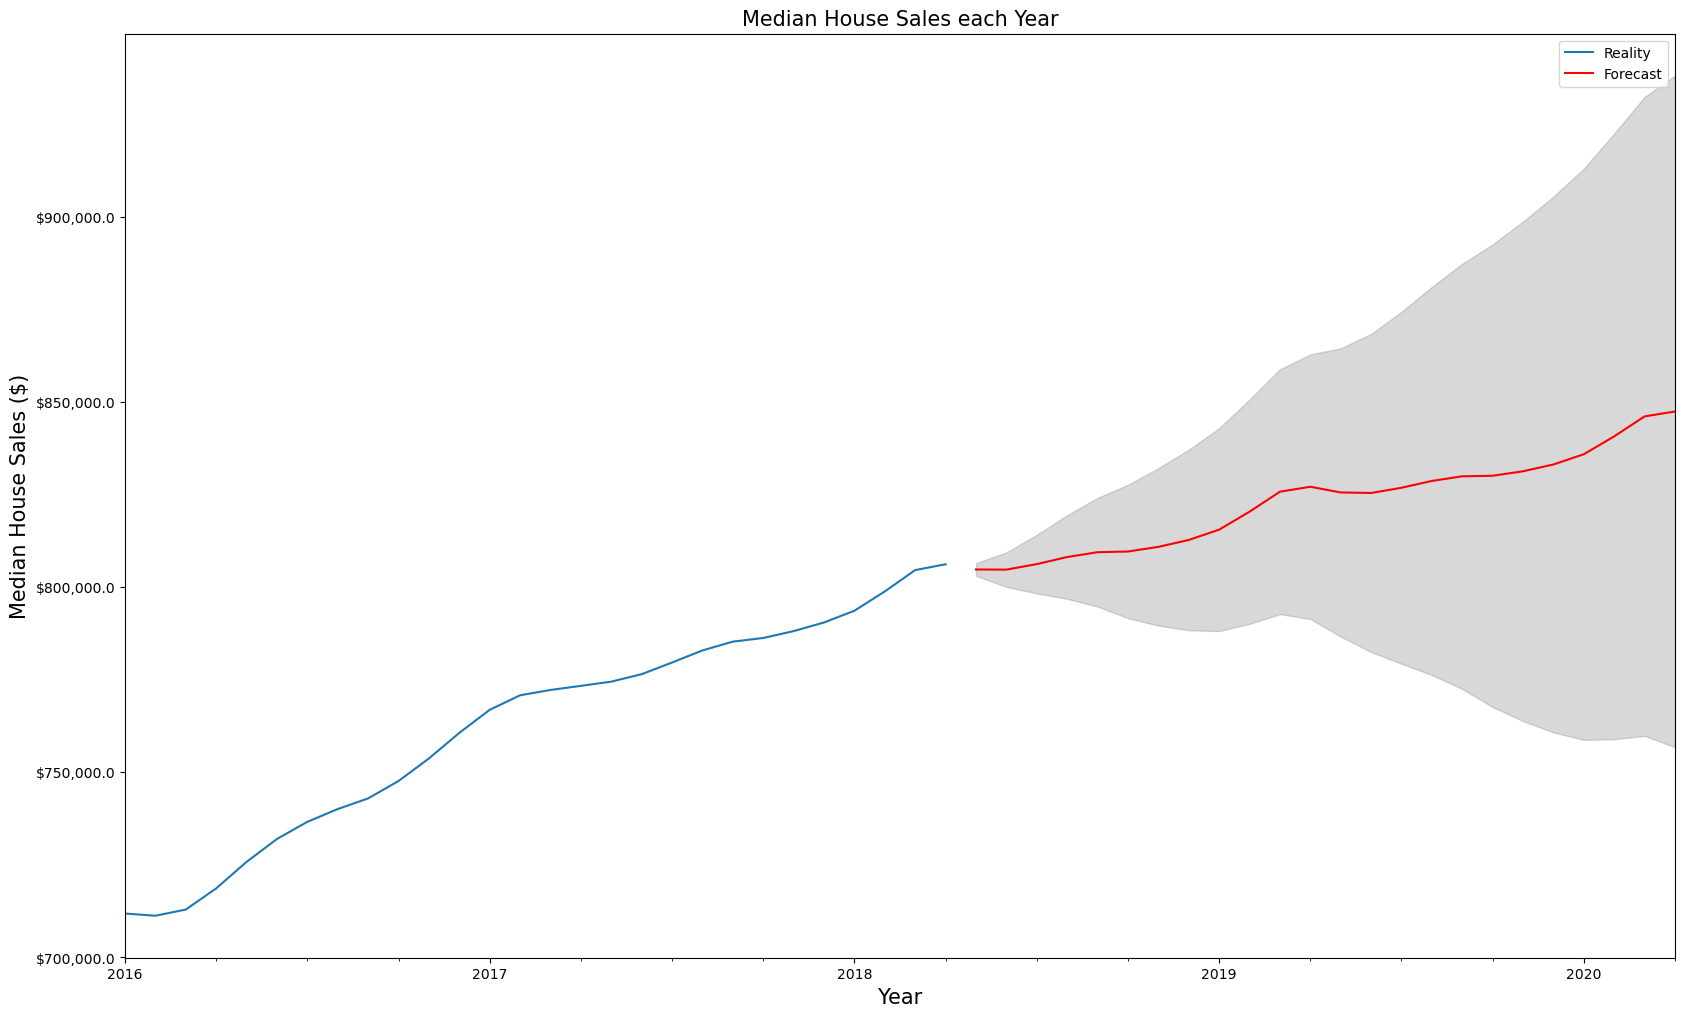

In [779]:
future = sari_final.get_forecast(steps=24)
future_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = df5.plot(label='Reality', figsize=(20, 12))

future.predicted_mean.plot(label='Forecast', ax=ax, color='r')

ax.fill_between(future_conf.index,
                future_conf.iloc[:, 0],
                future_conf.iloc[:, 1], color='grey', alpha=.3)

ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Median House Sales ($)', fontsize=15)
ax.set_title('Median House Sales each Year', fontsize=15)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.legend();
plt.savefig('final_plots/forcasted2.png',dpi=300)

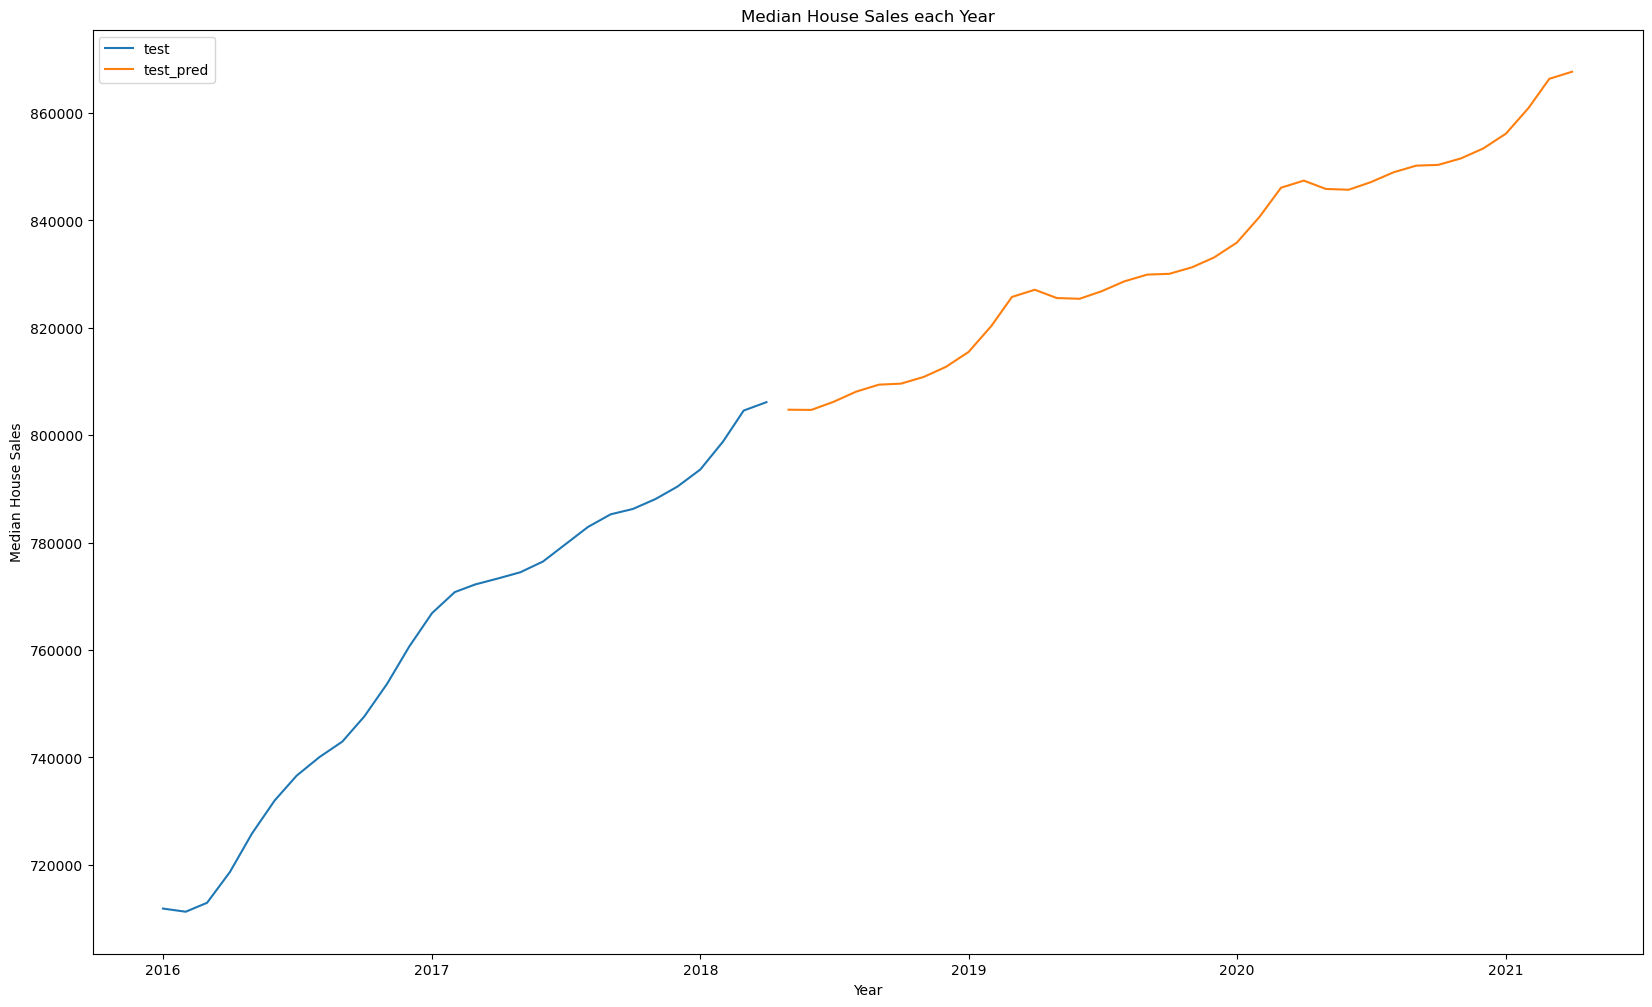

In [760]:
forecast = sari_final.forecast(steps=12*3)

fig, ax = plt.subplots(figsize=(20,12))
# ax.plot(train, label='train')
ax.plot(df5, label='test')
ax.plot(forecast, label='test_pred')

# ax.fill_between(plot())
ax.set_xlabel('Year')
ax.set_ylabel('Median House Sales')
ax.set_title('Median House Sales each Year')

plt.legend();
plt.savefig('final_plots/forcasted.png',dpi=300)


# ROI

In [717]:
dc_df

Date  RegionID  zipcode        City State       Metro  \
3103    1996-04-01     66125    20001  Washington    DC  Washington   
3104    1996-04-01     66126    20002  Washington    DC  Washington   
3105    1996-04-01     66127    20003  Washington    DC  Washington   
3106    1996-04-01     66131    20007  Washington    DC  Washington   
3107    1996-04-01     66132    20008  Washington    DC  Washington   
...            ...       ...      ...         ...   ...         ...   
3407396 2018-04-01     66142    20019  Washington    DC  Washington   
3407397 2018-04-01     66143    20020  Washington    DC  Washington   
3407398 2018-04-01     66146    20024  Washington    DC  Washington   
3407399 2018-04-01     66151    20032  Washington    DC  Washington   
3407400 2018-04-01     66155    20037  Washington    DC  Washington   

                   CountyName  SizeRank  pct_change  MedianHousingSales  \
3103     District of Columbia       259    7.622826             92000.0   
3104     District of Columbia        30    6.330859             94300.0   
3105     District of Columbia      1449    5.309231            130000.0   
3106     District of Columbia      2654    2.602346            358100.0   
3107     District of Columbia      1264    2.434570            450100.0   
...                       ...       ...         ...                 ...   
3407396  District of Columbia       247    2.380066            308600.0   
3407397  District of Columbia       403    2.224880            337000.0   
3407398  District of Columbia      5298    3.218303            885000.0   
3407399  District of Columbia      1708    2.586931            307400.0   
3407400  District of Columbia      5806    2.670266           1019600.0   

         PercentChange  
3103               NaN  
3104               NaN  
3105               NaN  
3106               NaN  
3107               NaN  
...                ...  
3407396      20.358814  
3407397      11.478664  
3407398      -0.112867  
3407399      23.901653  
3407400      10.777923  

[4770 rows x 11 columns]

In [727]:

dc_zipcode = dc_df.groupby('zipcode').mean()
dc_date = dc_df.groupby('Date').mean()

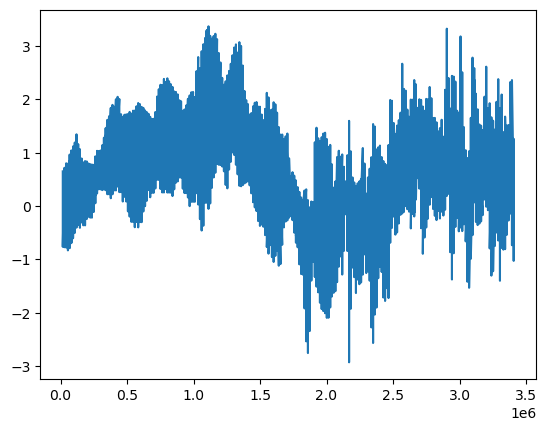

In [168]:
dc_df['PercentChange'].plot();

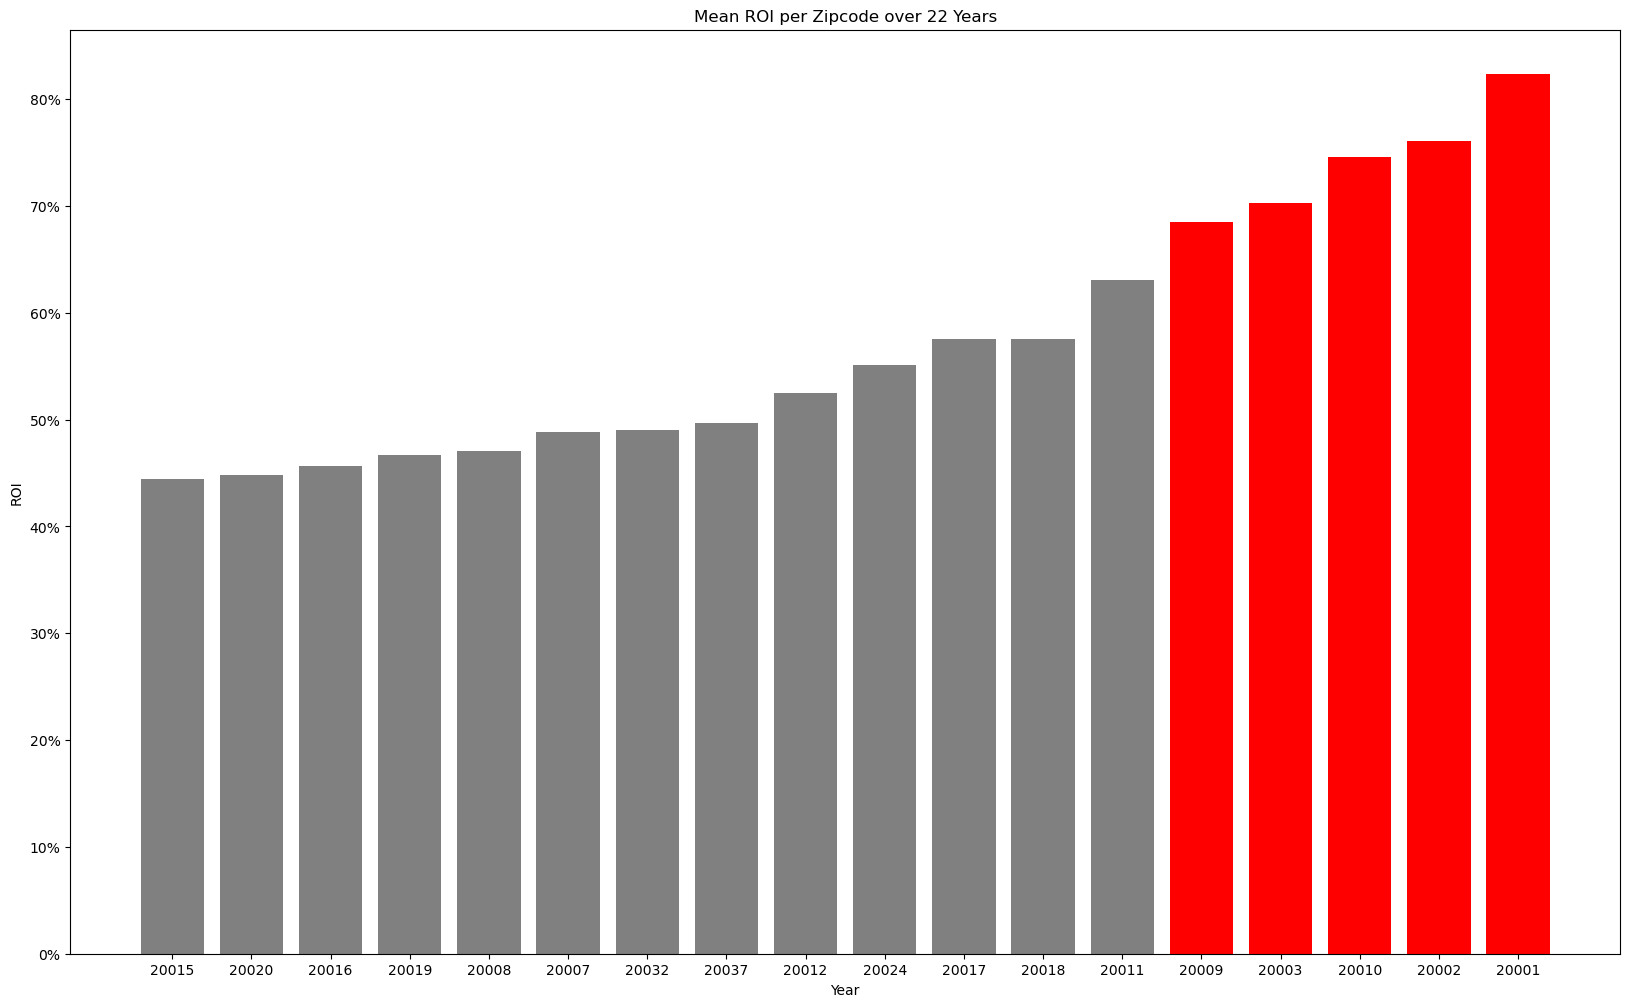

In [778]:
# make bar graphs
# clearly says what this is showing
from matplotlib.ticker import StrMethodFormatter, FuncFormatter

fig, ax = plt.subplots(figsize=(20,12))
dc_zipcode.sort_values(by='PercentChange', inplace=True)
colors = ['grey']*13 +['red']*5
# ax.plot(train, label='train')
ax.bar(dc_zipcode['PercentChange'].index.astype(str), dc_zipcode['PercentChange'].values, color=colors)
# ax.plot(y_hat_train, label='train_pred')

ax.set_xlabel('Year',)
ax.set_ylabel('ROI')
ax.set_title('Mean ROI per Zipcode over 22 Years');
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))






plt.savefig('final_plots/percentchange_bar.png',dpi=300)

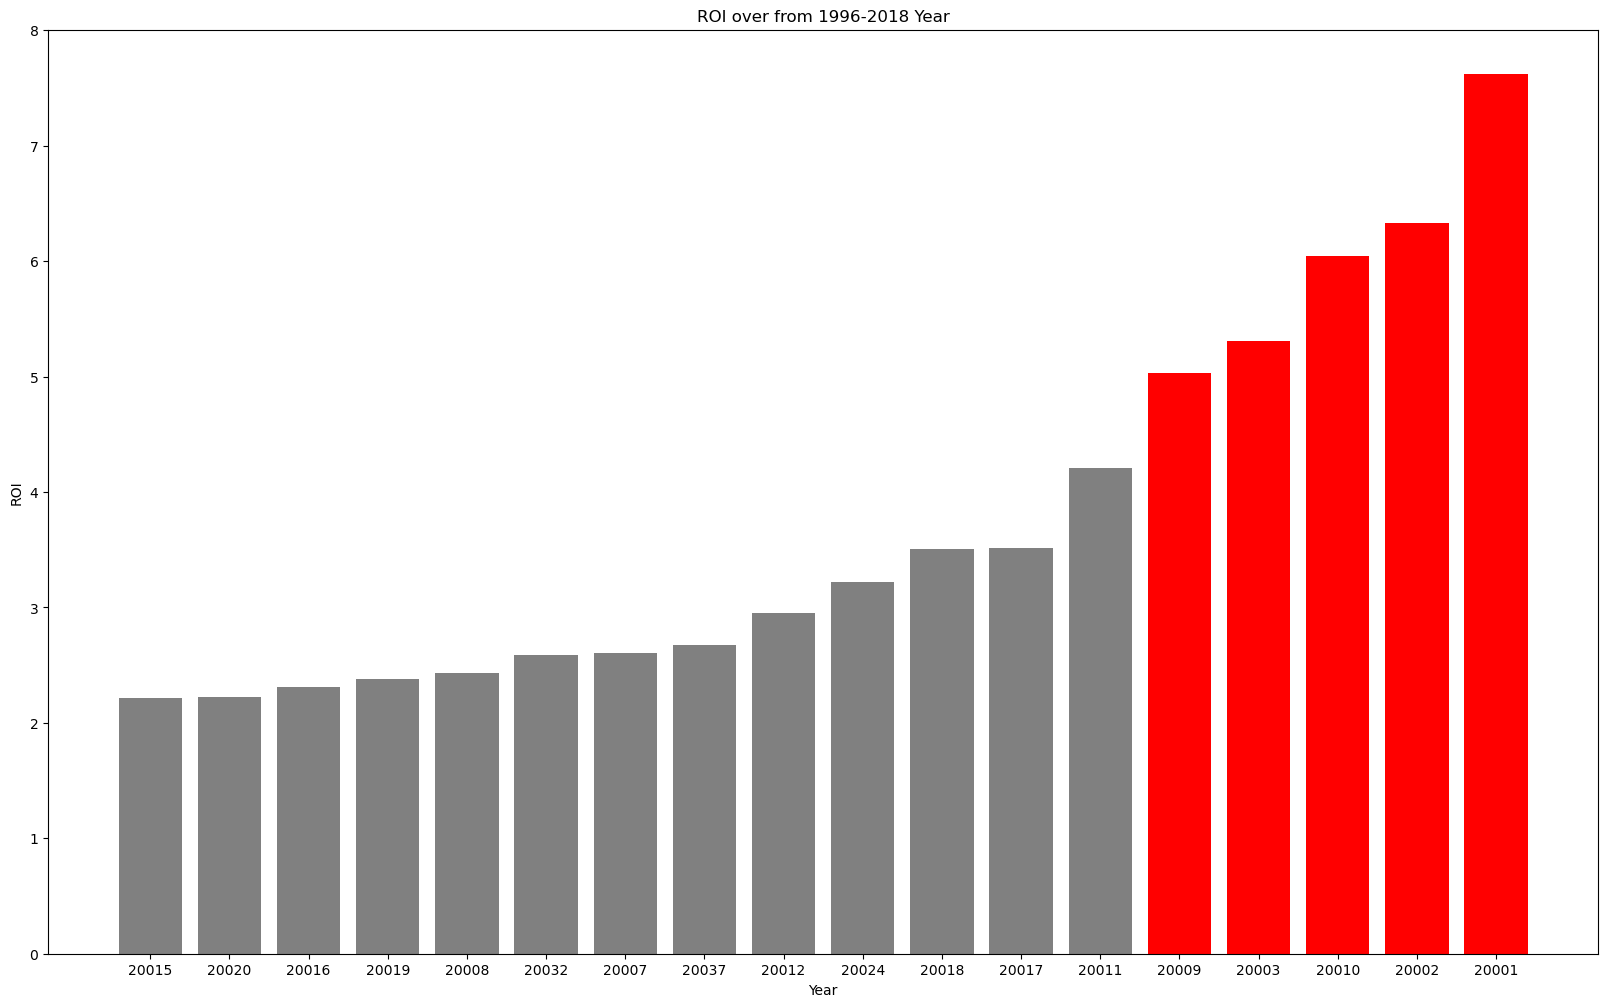

In [734]:
# make bar graphs
# clearly says what this is showing

fig, ax = plt.subplots(figsize=(20,12))
dc_zipcode.sort_values(by='pct_change', inplace=True)
colors = ['grey']*13 +['red']*5
# ax.plot(train, label='train')
ax.bar(dc_zipcode['pct_change'].index.astype(str), dc_zipcode['pct_change'].values, color=colors)
# ax.plot(y_hat_train, label='train_pred')

ax.set_xlabel('Year')
ax.set_ylabel('ROI')
ax.set_title('ROI over from 1996-2018 Year');


plt.savefig('final_plots/percentchange_bar3.png',dpi=300)

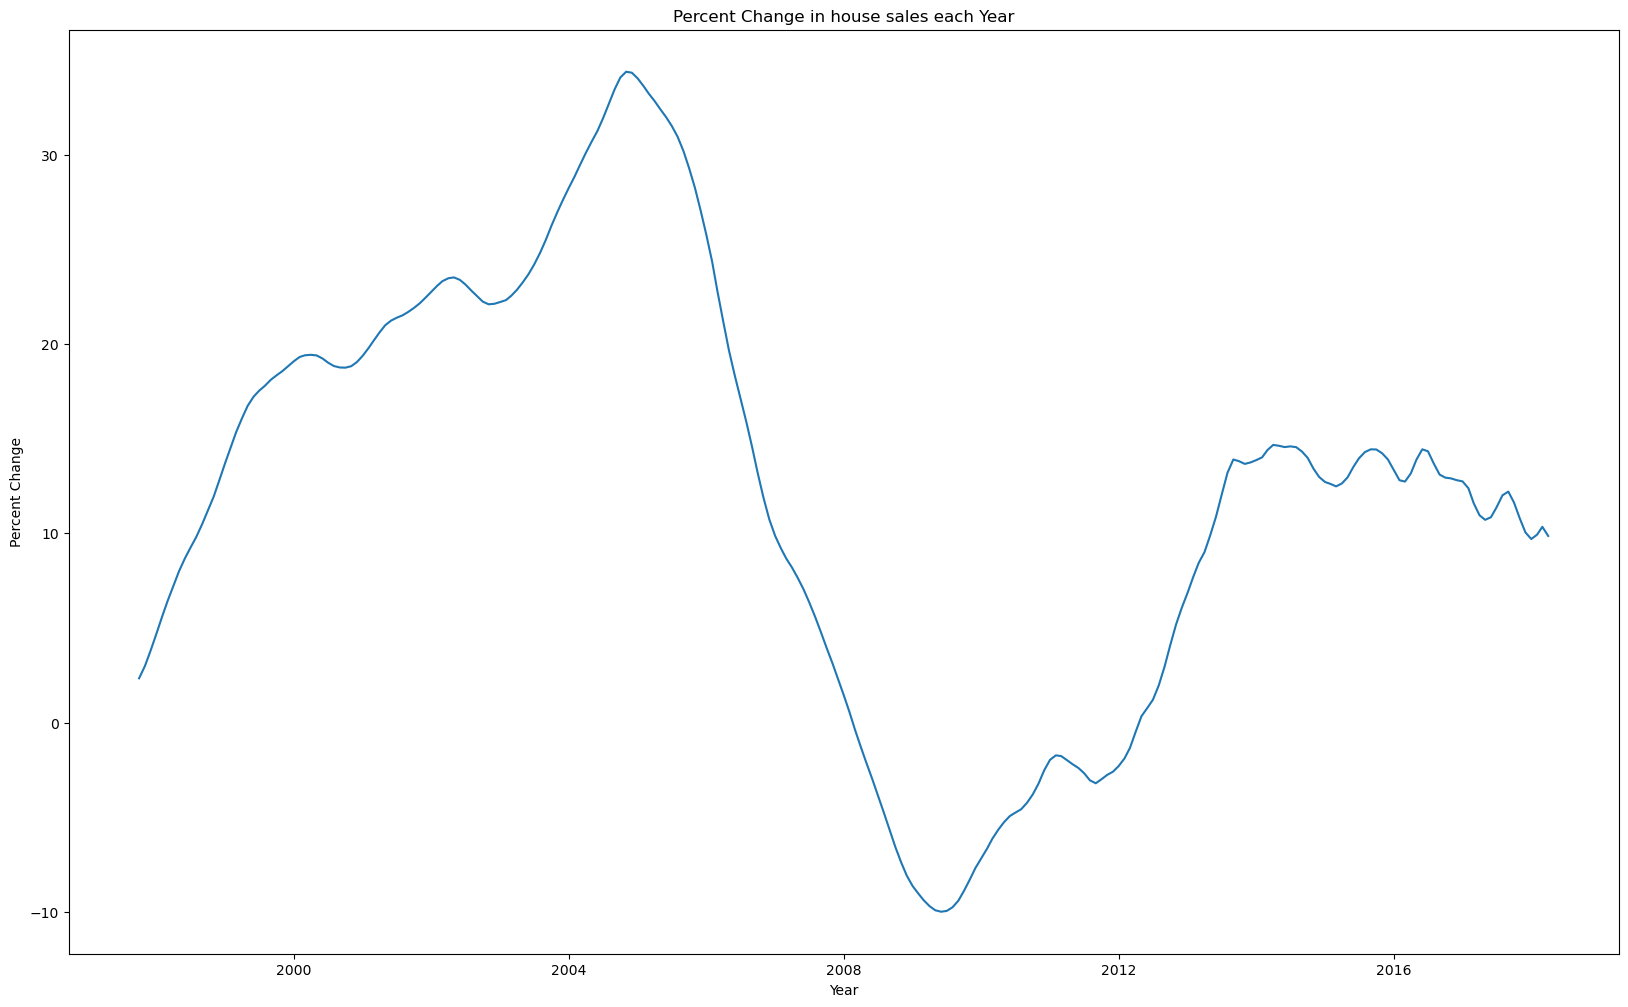

In [710]:
fig, ax = plt.subplots(figsize=(20,12))
# ax.plot(train, label='train')
ax.plot(dc_date['PercentChange'])
# ax.plot(y_hat_train, label='train_pred')

ax.set_xlabel('Year')
ax.set_ylabel('Percent Change')
ax.set_title('Percent Change in house sales each Year');


plt.savefig('final_plots/percentchange.png',dpi=300)

<AxesSubplot:xlabel='Date'>

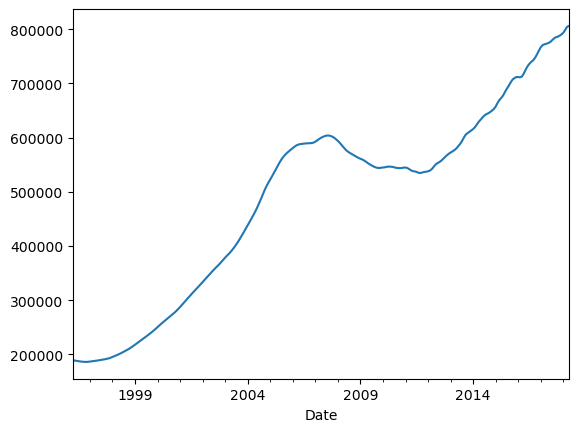

In [173]:
dc_date['MedianHousingSales'].plot()

In [280]:
dc_df

Date  RegionID  zipcode        City State       Metro  \
3103    1996-04-01     66125    20001  Washington    DC  Washington   
3104    1996-04-01     66126    20002  Washington    DC  Washington   
3105    1996-04-01     66127    20003  Washington    DC  Washington   
3106    1996-04-01     66131    20007  Washington    DC  Washington   
3107    1996-04-01     66132    20008  Washington    DC  Washington   
...            ...       ...      ...         ...   ...         ...   
3407396 2018-04-01     66142    20019  Washington    DC  Washington   
3407397 2018-04-01     66143    20020  Washington    DC  Washington   
3407398 2018-04-01     66146    20024  Washington    DC  Washington   
3407399 2018-04-01     66151    20032  Washington    DC  Washington   
3407400 2018-04-01     66155    20037  Washington    DC  Washington   

                   CountyName  SizeRank  pct_change  MedianHousingSales  \
3103     District of Columbia       259    7.622826             92000.0   
3104     District of Columbia        30    6.330859             94300.0   
3105     District of Columbia      1449    5.309231            130000.0   
3106     District of Columbia      2654    2.602346            358100.0   
3107     District of Columbia      1264    2.434570            450100.0   
...                       ...       ...         ...                 ...   
3407396  District of Columbia       247    2.380066            308600.0   
3407397  District of Columbia       403    2.224880            337000.0   
3407398  District of Columbia      5298    3.218303            885000.0   
3407399  District of Columbia      1708    2.586931            307400.0   
3407400  District of Columbia      5806    2.670266           1019600.0   

         PercentChange  
3103               NaN  
3104               NaN  
3105               NaN  
3106               NaN  
3107               NaN  
...                ...  
3407396      20.358814  
3407397      11.478664  
3407398      -0.112867  
3407399      23.901653  
3407400      10.777923  

[4770 rows x 11 columns]

In [211]:
# initail
initial_sales = dc_df.groupby('zipcode').apply(lambda x: x[x['Date'] == x['Date'].min()]['MedianHousingSales'].iloc[0])
initial_sales.name = 'InitialMedianSales'
# final
final_sales = dc_df.groupby('zipcode').apply(lambda x: x[x['Date'] == x['Date'].max()]['MedianHousingSales'].iloc[0])
final_sales.name = 'FinalMedianSales'

# merge
sales = pd.concat([initial_sales, final_sales], axis=1)

# calculate annual ROI for each zip code
sales['AnnualROI'] = ((sales['FinalMedianSales'] - sales['InitialMedianSales']) / sales['InitialMedianSales'])*100


# sort by descending annual ROI
sales = sales.sort_values(by='AnnualROI', ascending=False)#.reset_index(drop=False)
sales.index = sales.index.astype(str)

In [212]:
sales

InitialMedianSales  FinalMedianSales   AnnualROI
zipcode                                                  
20001               92000.0          793300.0  762.282609
20002               94300.0          691300.0  633.085896
20010              110500.0          778200.0  604.253394
20003              130000.0          820200.0  530.923077
20009              178800.0         1078200.0  503.020134
20011              118900.0          619100.0  420.689655
20017              121700.0          548900.0  351.027116
20018              123000.0          554100.0  350.487805
20024              209800.0          885000.0  321.830315
20012              185000.0          730700.0  294.972973
20037              277800.0         1019600.0  267.026638
20007              358100.0         1290000.0  260.234571
20032               85700.0          307400.0  258.693116
20008              450100.0         1545900.0  243.457010
20019               91300.0          308600.0  238.006572
20016              362000.0         1199500.0  231.353591
20020              104500.0          337000.0  222.488038
20015              312400.0         1004000.0  221.382843

<AxesSubplot:xlabel='zipcode'>

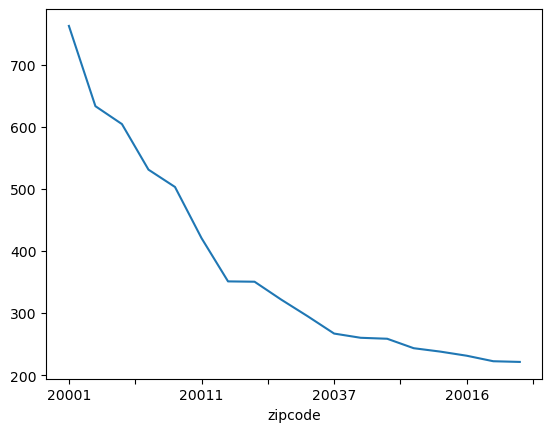

In [213]:
sales['AnnualROI'].plot()

In [262]:
c_df = final_df[final_df['State'].isin(selected_states)]
# c_df = c_df.groupby(['zipcode']).mean()
c_df['PercentChange'] = c_df.groupby('zipcode')['MedianHousingSales'].pct_change(periods=len(c_df['zipcode'].unique())) *100
c_zipcode = c_df.groupby('zipcode').mean()
c_date = c_df.groupby('Date').mean()
# c_df['Annual_Pct_Change'] = c_df['MedianHousingSales'].pct_change(periods=12)*100


In [264]:
c_df

Date  RegionID  zipcode        City State       Metro  \
3103    1996-04-01     66125    20001  Washington    DC  Washington   
3104    1996-04-01     66126    20002  Washington    DC  Washington   
3105    1996-04-01     66127    20003  Washington    DC  Washington   
3106    1996-04-01     66131    20007  Washington    DC  Washington   
3107    1996-04-01     66132    20008  Washington    DC  Washington   
...            ...       ...      ...         ...   ...         ...   
3407396 2018-04-01     66142    20019  Washington    DC  Washington   
3407397 2018-04-01     66143    20020  Washington    DC  Washington   
3407398 2018-04-01     66146    20024  Washington    DC  Washington   
3407399 2018-04-01     66151    20032  Washington    DC  Washington   
3407400 2018-04-01     66155    20037  Washington    DC  Washington   

                   CountyName  SizeRank  pct_change  MedianHousingSales  \
3103     District of Columbia       259    7.622826             92000.0   
3104     District of Columbia        30    6.330859             94300.0   
3105     District of Columbia      1449    5.309231            130000.0   
3106     District of Columbia      2654    2.602346            358100.0   
3107     District of Columbia      1264    2.434570            450100.0   
...                       ...       ...         ...                 ...   
3407396  District of Columbia       247    2.380066            308600.0   
3407397  District of Columbia       403    2.224880            337000.0   
3407398  District of Columbia      5298    3.218303            885000.0   
3407399  District of Columbia      1708    2.586931            307400.0   
3407400  District of Columbia      5806    2.670266           1019600.0   

         PercentChange  
3103               NaN  
3104               NaN  
3105               NaN  
3106               NaN  
3107               NaN  
...                ...  
3407396      20.358814  
3407397      11.478664  
3407398      -0.112867  
3407399      23.901653  
3407400      10.777923  

[4770 rows x 11 columns]

In [261]:
len(c_df['zipcode'].unique())

18

In [256]:
dc_df['PreviousMonthMedianSales'] = dc_df.groupby('zipcode')['MedianHousingSales'].shift(1)
dc_df['ROI'] = (dc_df['MedianHousingSales'] / dc_df['PreviousMonthMedianSales']) - 1


<AxesSubplot:xlabel='zipcode'>

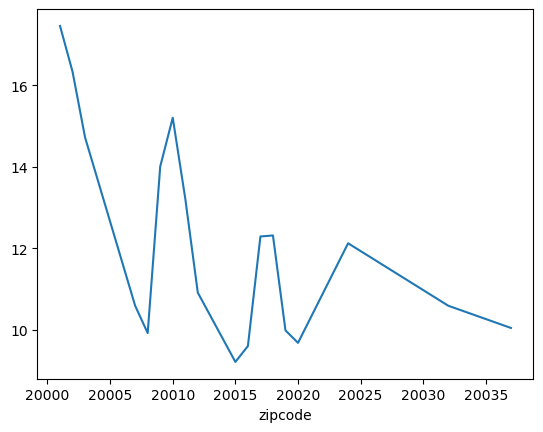

In [263]:
c_zipcode['PercentChange'].plot()